<a href="https://colab.research.google.com/github/schokoro/AttentionNMT/blob/master/en_jap_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Первым делом проверим какая карточка нам досталась. Лучшим вариантом будет `Tesla P100-PCIE-16GB`, на остальных будет считаться медленнее.

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    raise RuntimeError
else:
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [2]:
!pip install janome pandarallel  > /dev/null

In [3]:
!rm -rf AttentionNMT/
!git clone -b master https://github.com/schokoro/AttentionNMT.git > /dev/null

Cloning into 'AttentionNMT'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 84 (delta 45), reused 45 (delta 20), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [4]:
import sys
sys.path.append('/content/AttentionNMT')

In [5]:
%load_ext autoreload

In [6]:
%reload_ext autoreload
%autoreload 2
import AttentionNMT
from AttentionNMT.transformer import Transformer, Encoder, Decoder
from AttentionNMT.utils import count_parameters, initialize_weights, translate_sentence, evaluate_blue, train, evaluate, display_attention, sentence_blue

In [7]:
%autoreload 2
from typing import Dict, List, Optional
import torch.nn as nn
from matplotlib.font_manager import FontProperties
from torchtext.data import Field, BucketIterator, TabularDataset
from tqdm.notebook import tqdm
from pandarallel import pandarallel
import spacy
import warnings
import re
import random
import math
import time
from janome.tokenizer import Tokenizer as JTokenizer
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
tqdm.pandas()
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=False)

%matplotlib inline

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = False

# Подготовка данных и EDA

Для обучения англо-японского переводчика будем использовать [Tanaka Corpus](http://www.edrdg.org/wiki/index.php/Tanaka_Corpus). Прямая ссылка на скачивание [здесь](ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz).


In [9]:
!wget -q ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz 
!gunzip -f examples.utf.gz

## Подготовка корпуса

Посмотрим, как выглядит корпус:

In [10]:
!head -4 examples.utf

A: ムーリエルは２０歳になりました。	Muiriel is 20 now.#ID=1282_4707
B: は 二十歳(はたち){２０歳} になる[01]{になりました}
A: すぐに戻ります。	I will be back soon.#ID=1284_4709
B: 直ぐに{すぐに} 戻る{戻ります}


Нам нужны только строки с префиксом `A:`
Для токенизации английского языка будем использовать spacy, для японского - токенизатор janome. Для англо-японского перевода будет лучше, если японский текст мы развернём задом наперёд. Просто поверьте. Или можете проверить. Соответственно, при переводе нам будет необходимо развернуть переведённый текст обратно.

In [11]:
reverse_src = False
reverse_trg = False

In [12]:
nlp = spacy.load("en_core_web_sm")
jt = JTokenizer()
en_remove = re.compile(r'#ID=.+')
is_token = re.compile(r'\w+')


def get_pair(line: str, reverse=reverse_src) -> Dict[str, str]:
    """
    Принимает на вход строку из файла паралелльного корпуса, возвращает словарь
     с японским и английским предложениями
    """
    jap, en = line.strip().split('\t')
    jap = jap.replace('A: ', '').strip()
    en = en_remove.sub('', en)
    return {'en': en, 'jap': jap}
  
def src_tokenize(text: str, reverse=reverse_src) -> List[str]:
    """
    Токенизирует английский текст, возвращает список токенов.
    """
    tokens = [tok.text for tok in nlp.tokenizer(text)]
    if reverse:
        tokens.reverse()
    return tokens


def trg_tokenize(text: str, reverse=reverse_trg) -> List[str]:
    """
    Токенизирует японский текст, возвращает список токенов в обратном порядке

    """
    tokens = [token.base_form for token in jt.tokenize(text)]
    if reverse:
        tokens.reverse()
    return tokens


dicts = []
with open('examples.utf', 'r') as fobj:
    for i, line in enumerate(fobj):
        if line.startswith('A:'):
            dicts.append(get_pair(line))


corpus_df = pd.DataFrame(dicts)   

Посчитаем длины предложений в символах и посмотрим их корреляцию.

In [13]:
corpus_df['en_len'] = corpus_df['en'].map(lambda x: len(x))
corpus_df['jap_len'] = corpus_df['jap'].map(lambda x: len(x))

In [14]:
corpus_df[['en_len','jap_len' ]].corr()

,en_len,jap_len
en_len,1.00000,0.80946
jap_len,0.80946,1.00000


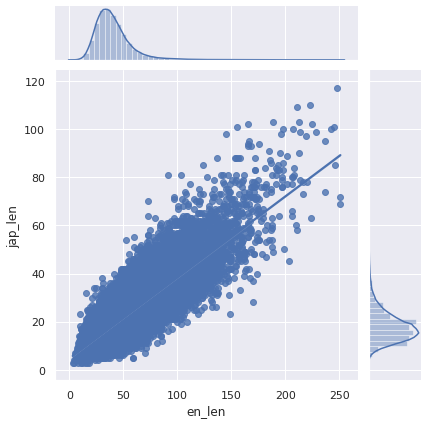

In [15]:
sns.jointplot("en_len", "jap_len", data=corpus_df, kind="reg");

А теперь - длины предложений в токенах и их корреляцию.

In [16]:
%time corpus_df['en_tok_len'] = corpus_df['en'].parallel_apply(lambda x: len(src_tokenize(x)))

CPU times: user 47.9 ms, sys: 81.4 ms, total: 129 ms
Wall time: 4.76 s


In [17]:
%time corpus_df['jap_tok_len'] = corpus_df['jap'].parallel_apply(lambda x: len(trg_tokenize(x)))

CPU times: user 102 ms, sys: 103 ms, total: 205 ms
Wall time: 2min 4s


In [18]:
corpus_df[['en_tok_len','jap_tok_len' ]].corr()

,en_tok_len,jap_tok_len
en_tok_len,1.000000,0.775551
jap_tok_len,0.775551,1.000000


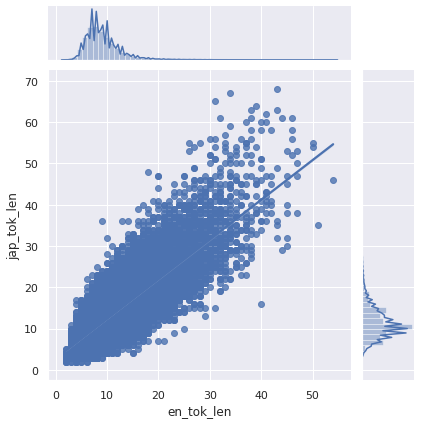

In [19]:
sns.jointplot("en_tok_len", "jap_tok_len", data=corpus_df, kind="reg")

In [20]:
corpus_df.describe()

,en_len,jap_len,en_tok_len,jap_tok_len
count,149791.000000,149791.000000,149791.000000,149791.000000
mean,40.471257,18.378414,9.307969,11.744277
std,17.418046,7.237914,3.594725,4.449128
min,3.000000,3.000000,2.000000,2.000000
25%,29.000000,14.000000,7.000000,9.000000
50%,37.000000,17.000000,9.000000,11.000000
75%,47.000000,21.000000,11.000000,14.000000
max,251.000000,117.000000,54.000000,68.000000


Выбросим из корпуса предложения длиннее чем `quantile(0.9)` и сохраним в файл.

In [21]:
corpus_df.en_tok_len.quantile(0.9), corpus_df.jap_tok_len.quantile(0.9)

(13.0, 17.0)

In [22]:
new_corpus_df = corpus_df[
    (corpus_df.en_tok_len < corpus_df.en_tok_len.quantile(0.9)) &
    (corpus_df.jap_tok_len < corpus_df.jap_tok_len.quantile(0.9)) 
]
corpus_df.shape

(149791, 6)

In [23]:
new_corpus_df.to_csv('en_jap_corpus.csv', index=None, columns=['en', 'jap'])

In [24]:
max_src = corpus_df.en_tok_len.max() + 2
max_trg = corpus_df.jap_tok_len.max() + 2

In [25]:
SRC = Field(
            tokenize = src_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(
            tokenize = trg_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [26]:
%%time
trn_data_fields = [("src", SRC), ("trg", TRG)]

dataset = TabularDataset(
    path='en_jap_corpus.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

CPU times: user 2min 1s, sys: 459 ms, total: 2min 2s
Wall time: 2min 2s


In [27]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [28]:
SRC.build_vocab(train_data.src, min_freq=3)  # 
print(SRC.vocab.freqs.most_common(10))

TRG.build_vocab(train_data.trg, min_freq=3)
print(TRG.vocab.freqs.most_common(10))

print(f'SRC.vocab: {len(SRC.vocab)}, TRG.vocab: {len(TRG.vocab)}')

[('.', 110949), ('the', 47479), ('to', 26434), ('i', 25470), ('a', 21899), ('is', 21009), ('he', 19815), ('you', 15689), ('of', 14215), ('in', 13549)]
[('。', 121263), ('は', 93000), ('た', 51244), ('の', 48539), ('に', 48386), ('を', 47693), ('て', 34216), ('が', 30231), ('する', 27348), ('だ', 25688)]
SRC.vocab: 9050, TRG.vocab: 11158


In [29]:
BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.src), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    shuffle=True,
    device=device)

# Тренировка модели


In [30]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 2 * HID_DIM
DEC_PF_DIM = 2 * HID_DIM
ENC_DROPOUT = 0.07
DEC_DROPOUT = 0.07

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              dropout=ENC_DROPOUT, 
              device=device,
              max_length=max_src)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM,
              dropout=DEC_DROPOUT, 
              device=device,
              max_length=max_trg)

In [31]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
try:
    del model
    torch.cuda.empty_cache()
except:
    print('no model')

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

no model


Посчитаем количество параметров сети

In [32]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,033,622 trainable parameters


In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
model.apply(initialize_weights);
best_macro_bleu = 0
test_loss = np.inf

In [35]:
BEST_MODEL = 'best_blue_en_jap.pt'

In [36]:
cross_entropy = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
LEARNING_RATE = 1.25e-3
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

def criterion(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return cross_entropy(pred_flat, target_flat)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       factor=0.2,
                                                       verbose=True,
                                                       cooldown=0, 
                                                       patience=4,              
                                                       threshold=0.01,
                                                       min_lr=5e-5)

In [37]:
train_history = []
valid_history = []
blue_history = []

In [38]:
N_EPOCHS = 30
CLIP = 1

try:
    best_valid_loss = evaluate(model, valid_iterator, criterion)
except:
    best_valid_loss = float('inf')
print(f'Loss: {best_valid_loss:7.3f}')


for epoc_num, epoch in tqdm(enumerate(range(N_EPOCHS)), total=N_EPOCHS):
    curent_lr = optimizer.param_groups[0]['lr']
    start_time = time.time()
    try:
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, 1, 1)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        scheduler.step(valid_loss)
                
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print('Новая лучшая модель')

        macro_bleu = evaluate_blue(valid_data, SRC, TRG, model, device, max_trg, src_tokenize).mean()
        if macro_bleu > best_macro_bleu:
            best_macro_bleu = macro_bleu
            print('Новый лучший blue')            
            torch.save(model.state_dict(), BEST_MODEL)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        blue_history.append(macro_bleu)

        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        
        print(f'\tMacro-average BLEU: {macro_bleu:.6f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print('_' * 100)
    except KeyboardInterrupt:
        print(f"Epoch: {epoch+1:02} | LR: {optimizer.param_groups[0]['lr']}")
        break
    finally:
        pass

Loss:   9.321


Новая лучшая модель
Новый лучший blue
Epoch: 01 | Time: 1m 19s
	Macro-average BLEU: 0.397754
	Train Loss: 3.565 | Train PPL:  35.340
	 Val. Loss: 2.563 |  Val. PPL:  12.980
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 02 | Time: 1m 20s
	Macro-average BLEU: 0.417848
	Train Loss: 2.335 | Train PPL:  10.329
	 Val. Loss: 1.998 |  Val. PPL:   7.371
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 03 | Time: 1m 20s
	Macro-average BLEU: 0.437457
	Train Loss: 1.890 | Train PPL:   6.622
	 Val. Loss: 1.761 |  Val. PPL:   5.818
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 04 | Time: 1m 21s
	Macro-average BLEU: 0.445767
	Train Loss: 1.631 | Train PPL:   5.111
	 Val. Loss: 1.639 |  Val. PPL:   5.150
_____

Загрузим веса модели с наилучшим BLUE

## Анализ BLUE

In [39]:
model.load_state_dict(torch.load(BEST_MODEL))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.612 | Test PPL:   5.011 |


CPU times: user 54.8 s, sys: 123 ms, total: 54.9 s
Wall time: 54.9 s


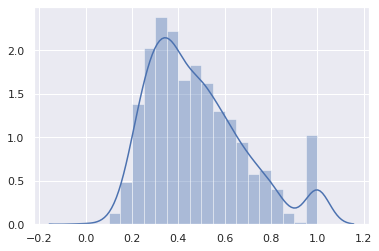

In [40]:
%%time 
valid_bleu = evaluate_blue(valid_data, SRC, TRG, model, device, max_trg, src_tokenize)
sns.distplot(valid_bleu);

CPU times: user 55 s, sys: 149 ms, total: 55.1 s
Wall time: 55.1 s


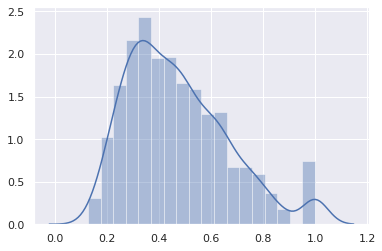

In [41]:
%%time 
test_bleu = evaluate_blue(test_data, SRC, TRG, model, device, max_trg, src_tokenize)
sns.distplot(test_bleu);

In [42]:
valid_bleu.mean(), test_bleu.mean()

(0.4776944368778359, 0.4707666278741631)

# Оценка перевода. Отображение карт внимания.

Для корректного отображения карт внимания загрузим шрифт `Osaka.ttf`. Хотя, можно взять и из репозитория.

In [43]:
!wget -q https://github.com/vuthaihoc/fonts/raw/master/JUSTRAJDEEP/Osaka.ttf

fontprop_x = FontProperties(size=20)
fontprop_y = FontProperties(fname='Osaka.ttf', size=20)

src      : i think it true .
trg      : 私 は それ が 本当 だ と 思う 。
predicted: 私 は それ を 真実 と 思う 。 <eos>
     blue: 46.13%


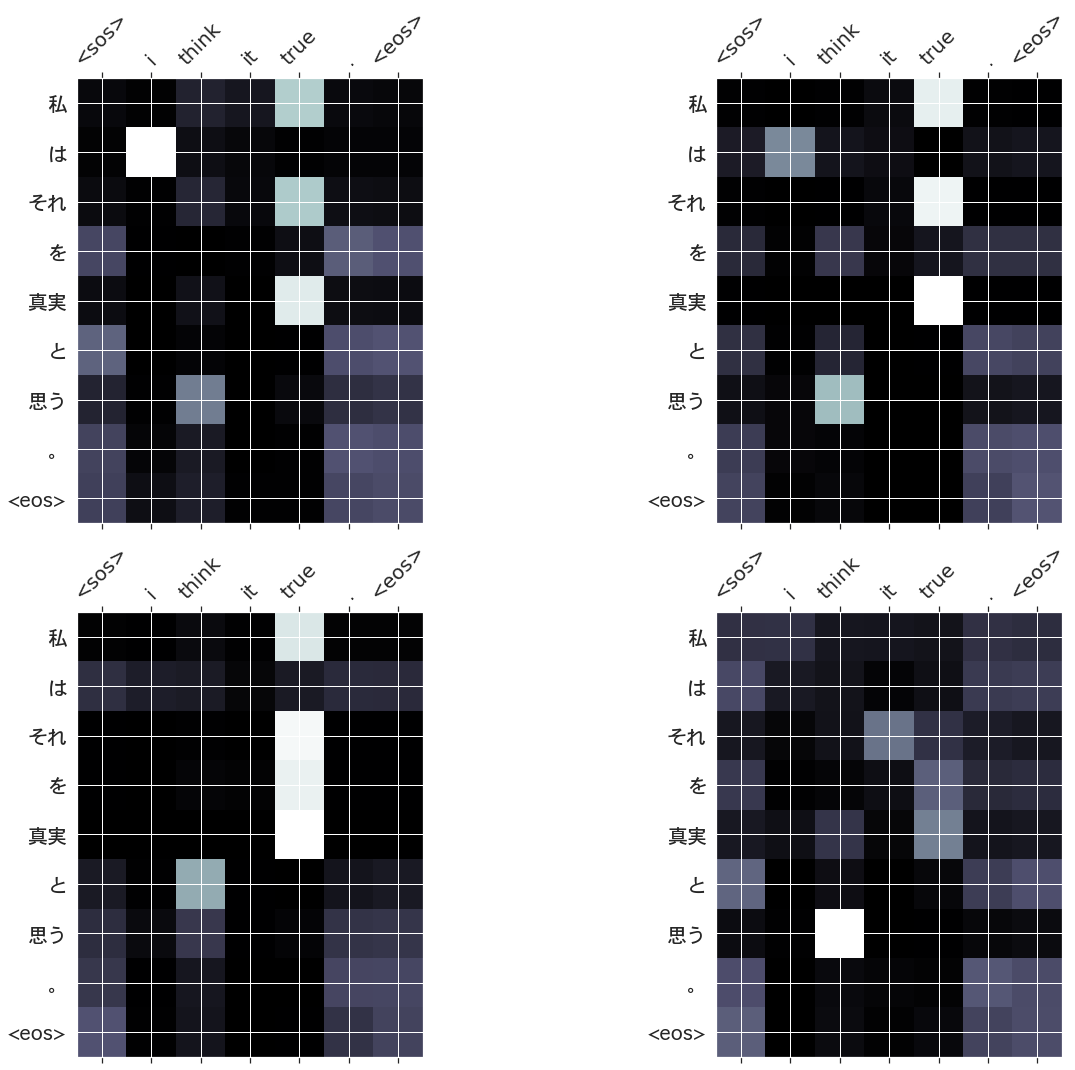

In [44]:
example_idx = random.randint(0, len(train_data) - 1)

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()

if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

src      : who did you meet there ?
trg      : そこで 誰 に 会う た の です か 。
predicted: 誰 が そこ で 会う ます た か 。 <eos>
     blue: 41.10%


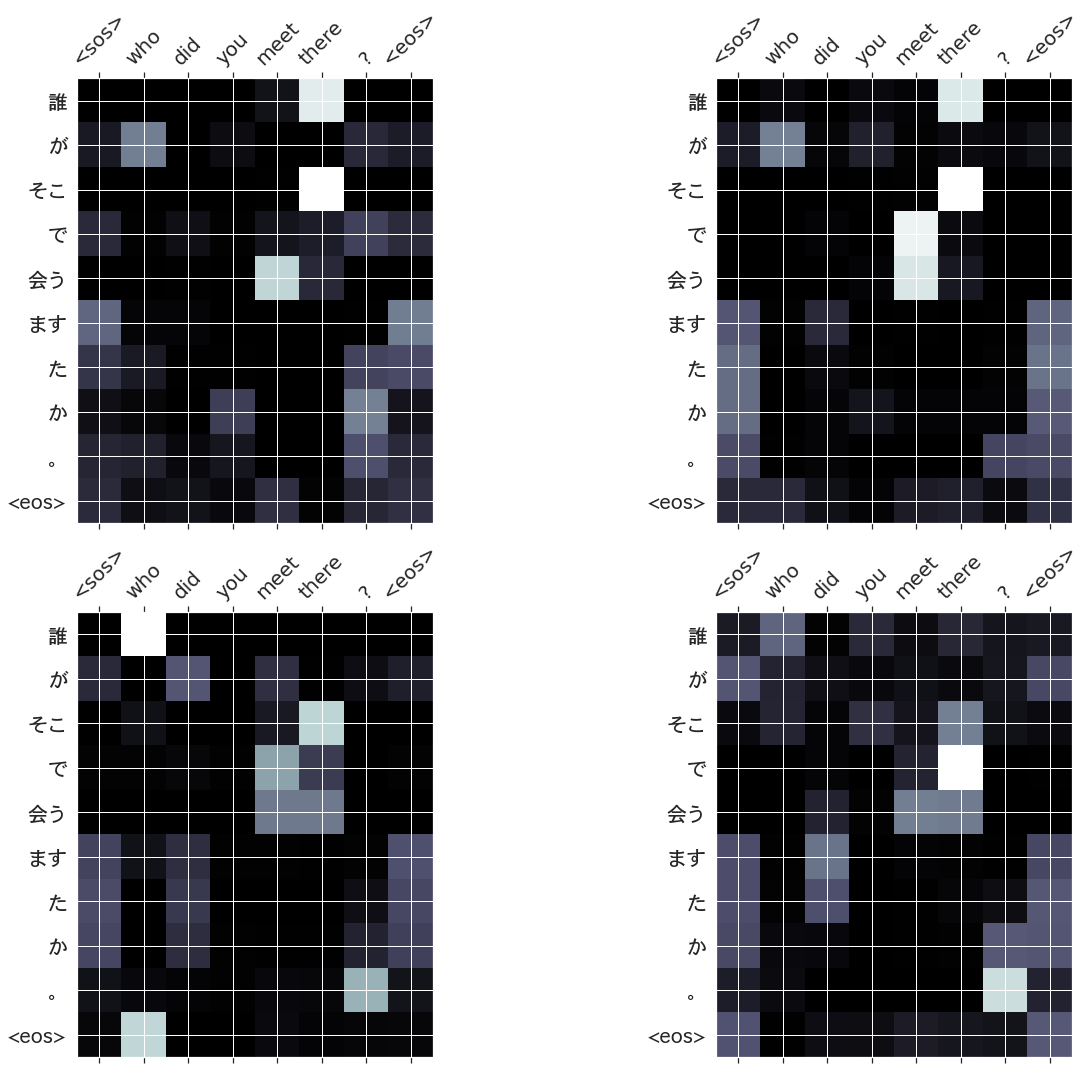

In [45]:
example_idx = random.randint(0, len(valid_data) - 1)

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()

if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

src      : my life changed , sparked by meeting mr matsukawa .
trg      : 松川 先生 と の 出会い を きっかけ に 、 私 の 人生 は 変わる た 。
predicted: 人生 は 変わる た し 、 <unk> 氏 も 愚者 に なる た 。 <eos>
     blue: 25.56%


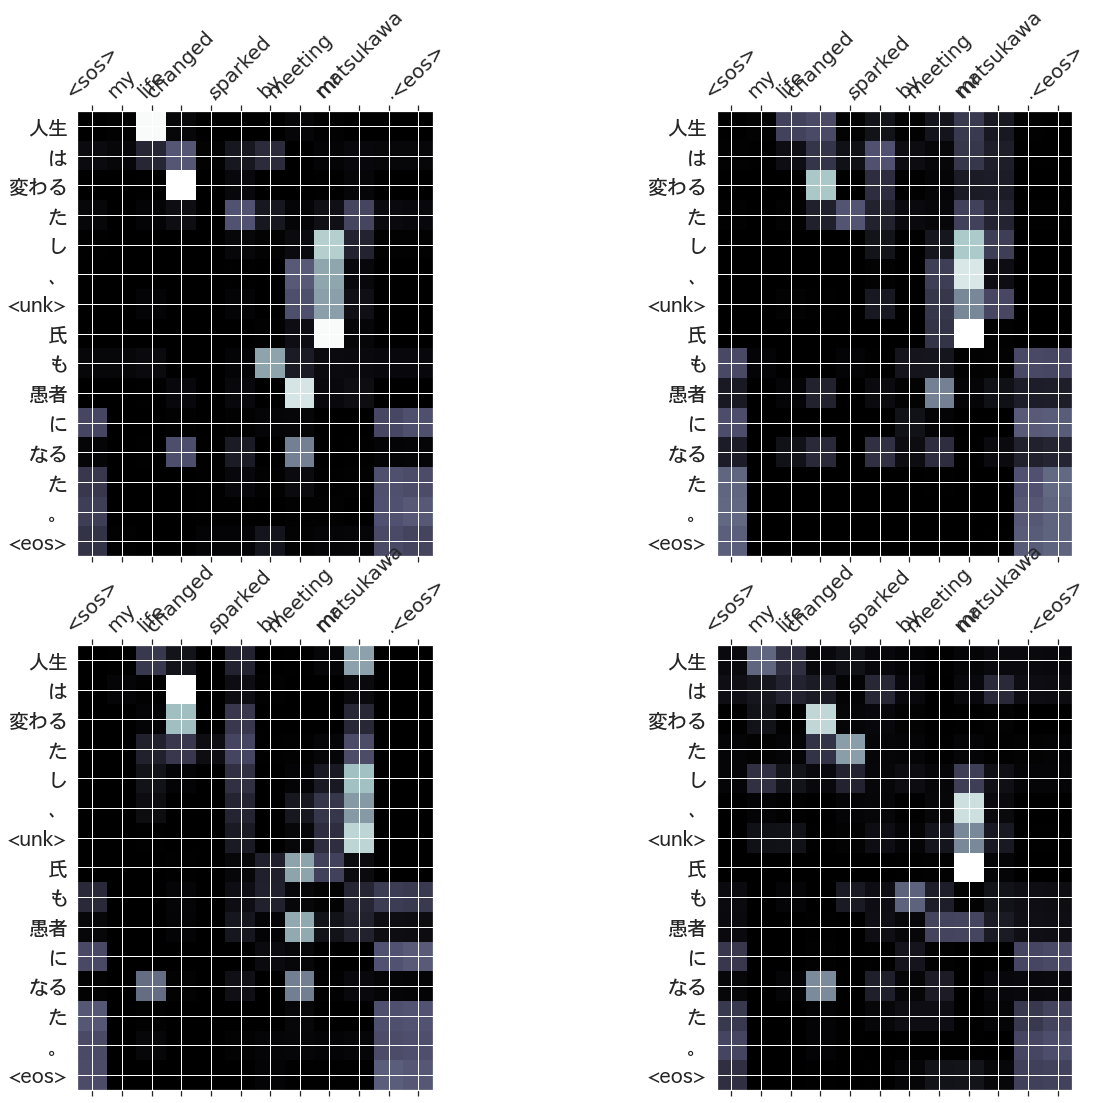

In [46]:
example_idx = random.randint(0, len(test_data) - 1)

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()
 
if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

Выведем не более 50 предложений с `BLUE` не менее 0.9

1
src      : i want to be a baseball player .
trg      : 私 は 野球 選手 に なる たい 。
predicted: 私 は 野球 選手 に なる たい 。 <eos>
     blue: 100.00%


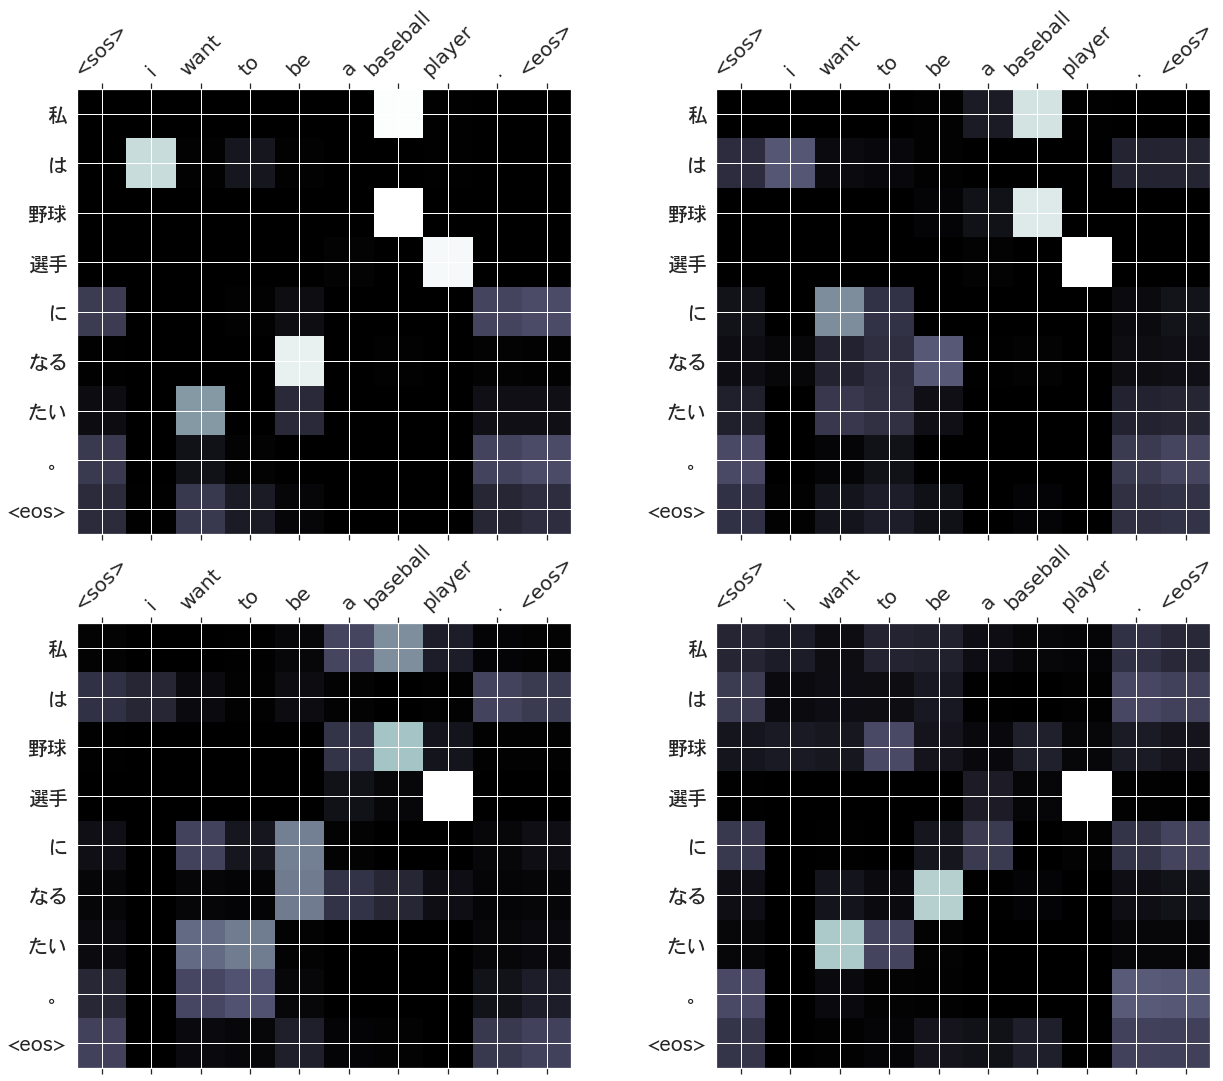

2
src      : these shoes are a little loose .
trg      : この 靴 は 少し 緩い 。
predicted: この 靴 は 少し 緩い 。 <eos>
     blue: 100.00%


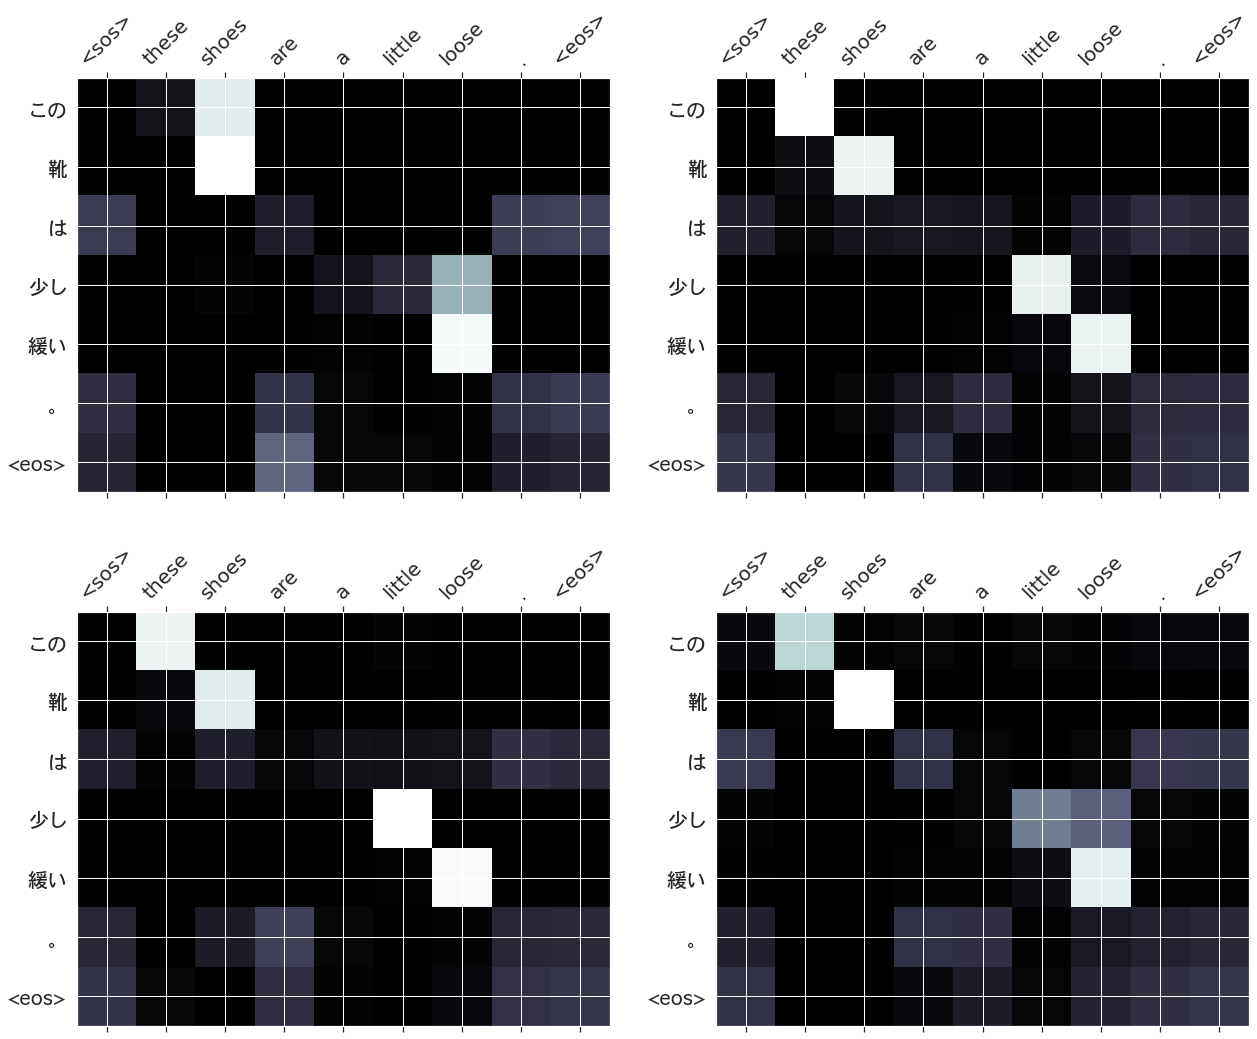

3
src      : kim and i are the same age .
trg      : キム と 私 は 同じ 年齢 だ 。
predicted: キム と 私 は 同じ 年齢 だ 。 <eos>
     blue: 100.00%


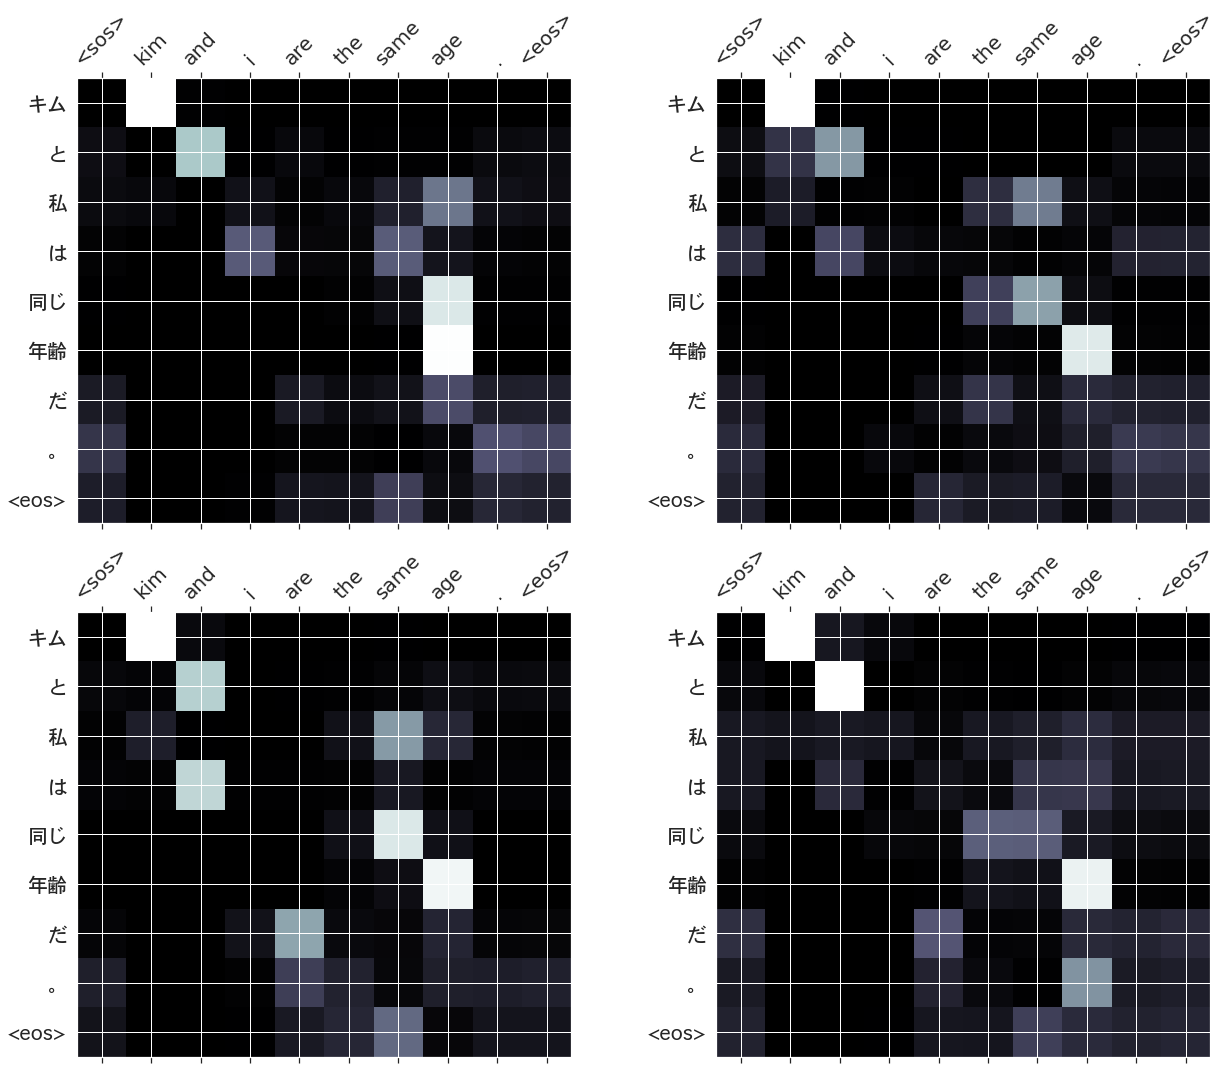

4
src      : he acknowledged it to be true .
trg      : 彼 は それ を 真実 だ と 認める た 。
predicted: 彼 は それ を 真実 だ と 認める た 。 <eos>
     blue: 100.00%


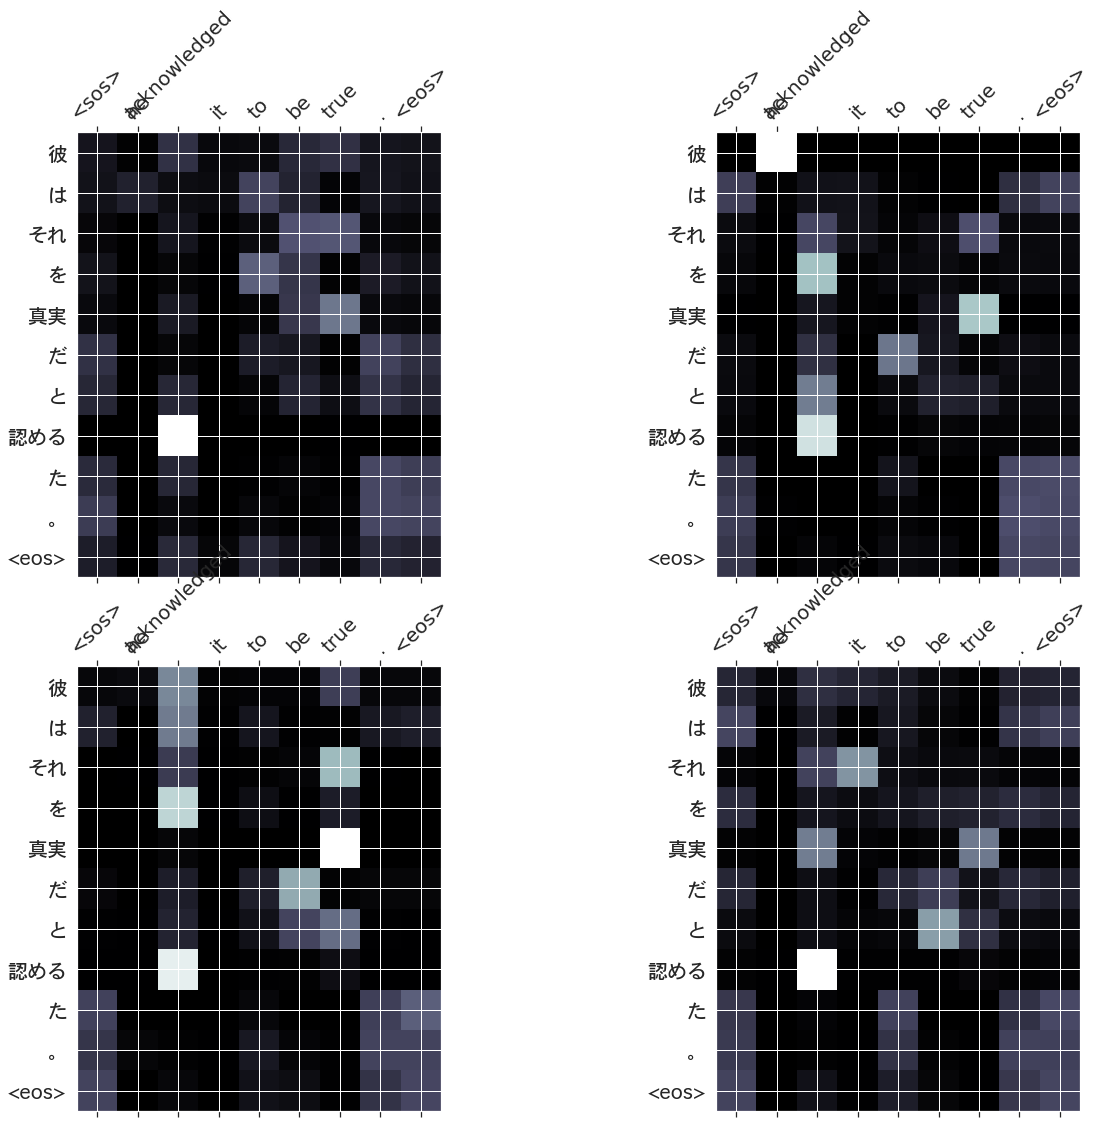

5
src      : she is hard at work .
trg      : 彼女 は 一生懸命 働く て いる 。
predicted: 彼女 は 一生懸命 働く て いる 。 <eos>
     blue: 100.00%


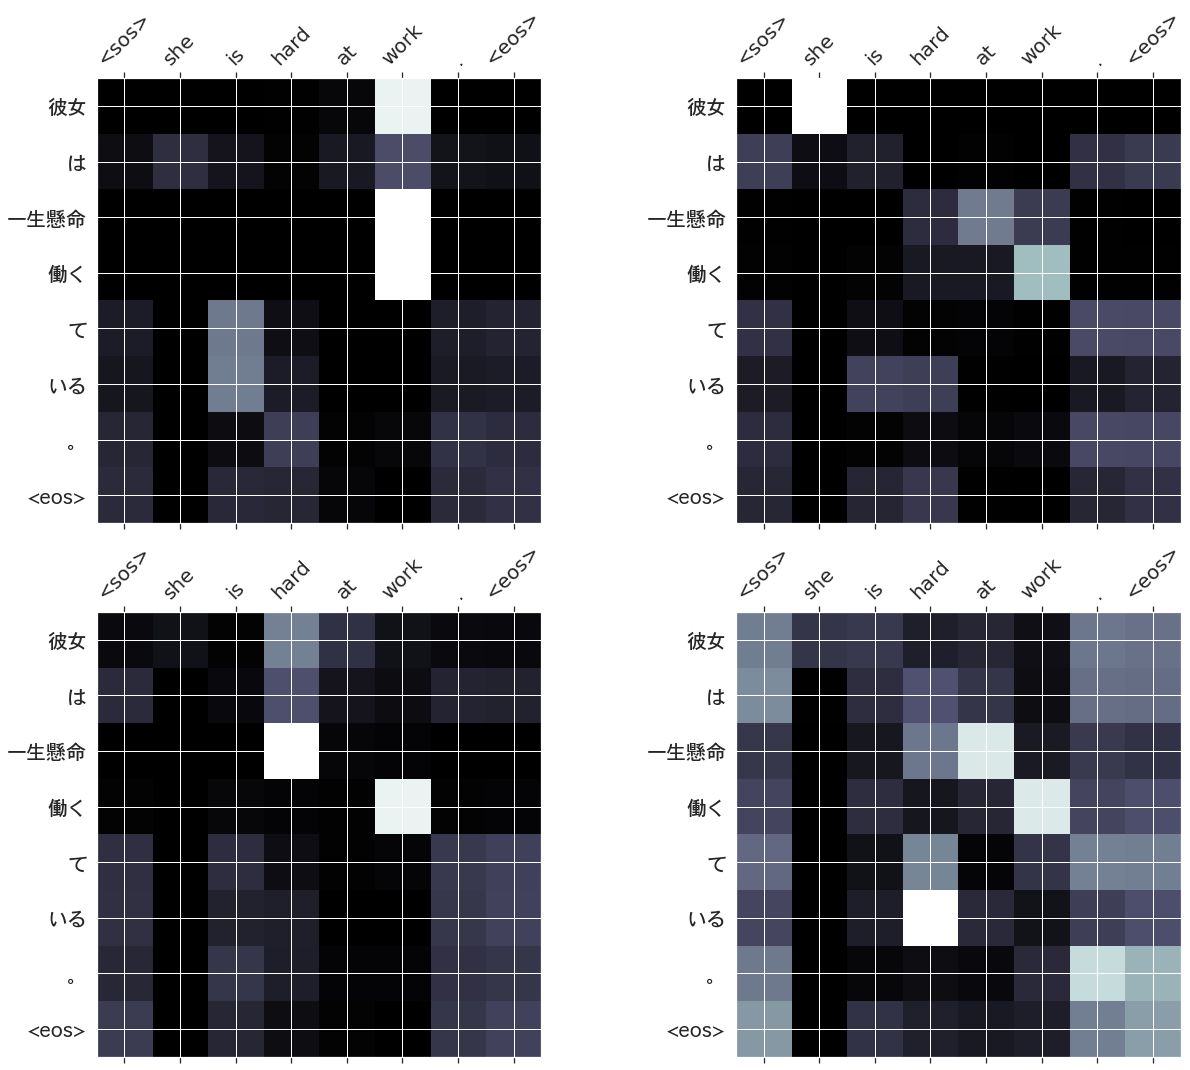

6
src      : i will go when he comes back .
trg      : 彼 が 戻る て くる た 行く ます 。
predicted: 彼 が 戻る て くる た 行く ます 。 <eos>
     blue: 100.00%


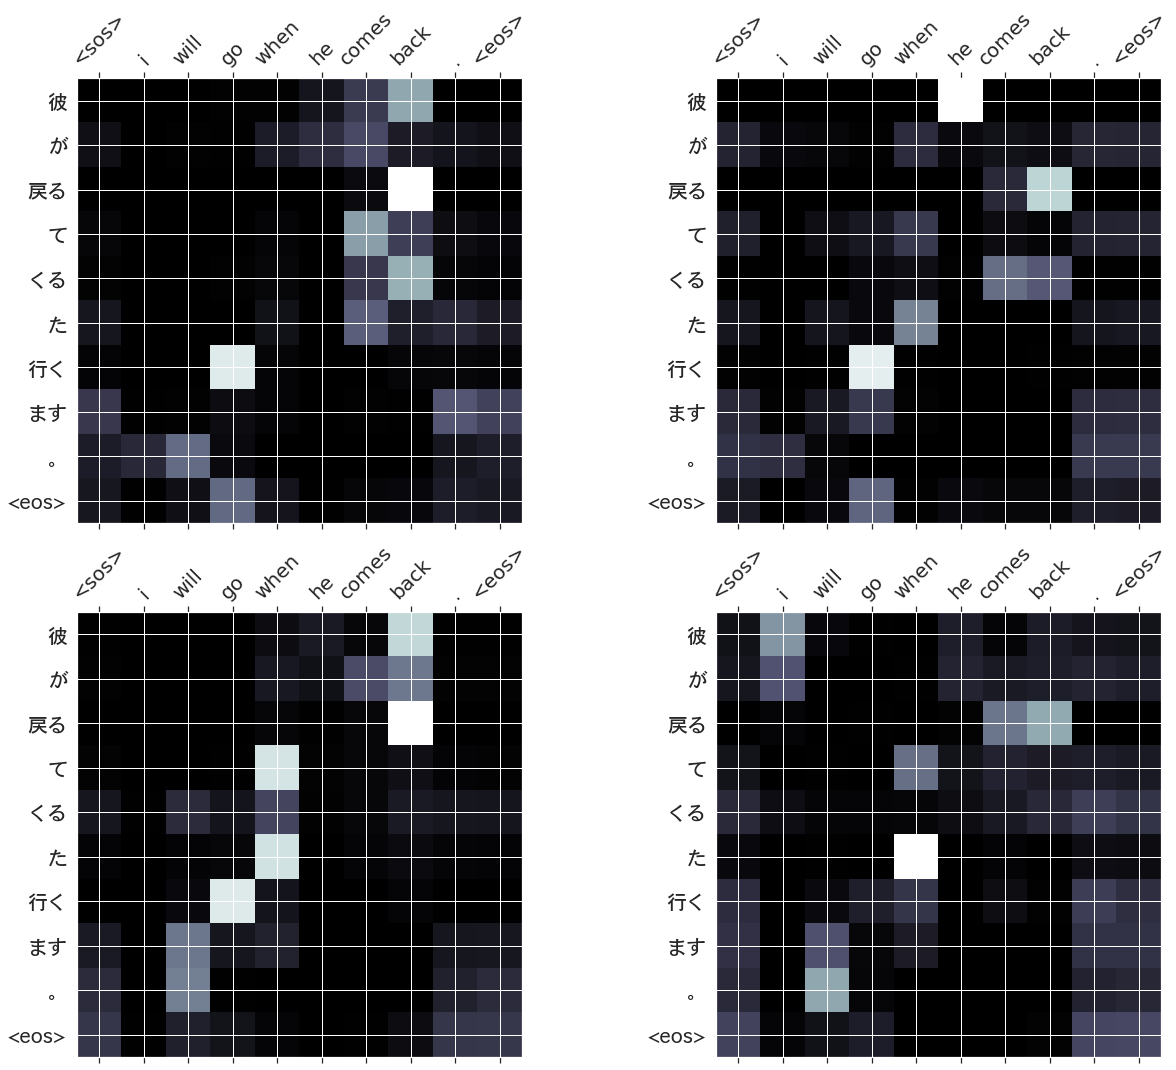

7
src      : his story may be true .
trg      : 彼 の 話 は 本当 かも しれる ない 。
predicted: 彼 の 話 は 本当 かも しれる ない 。 <eos>
     blue: 100.00%


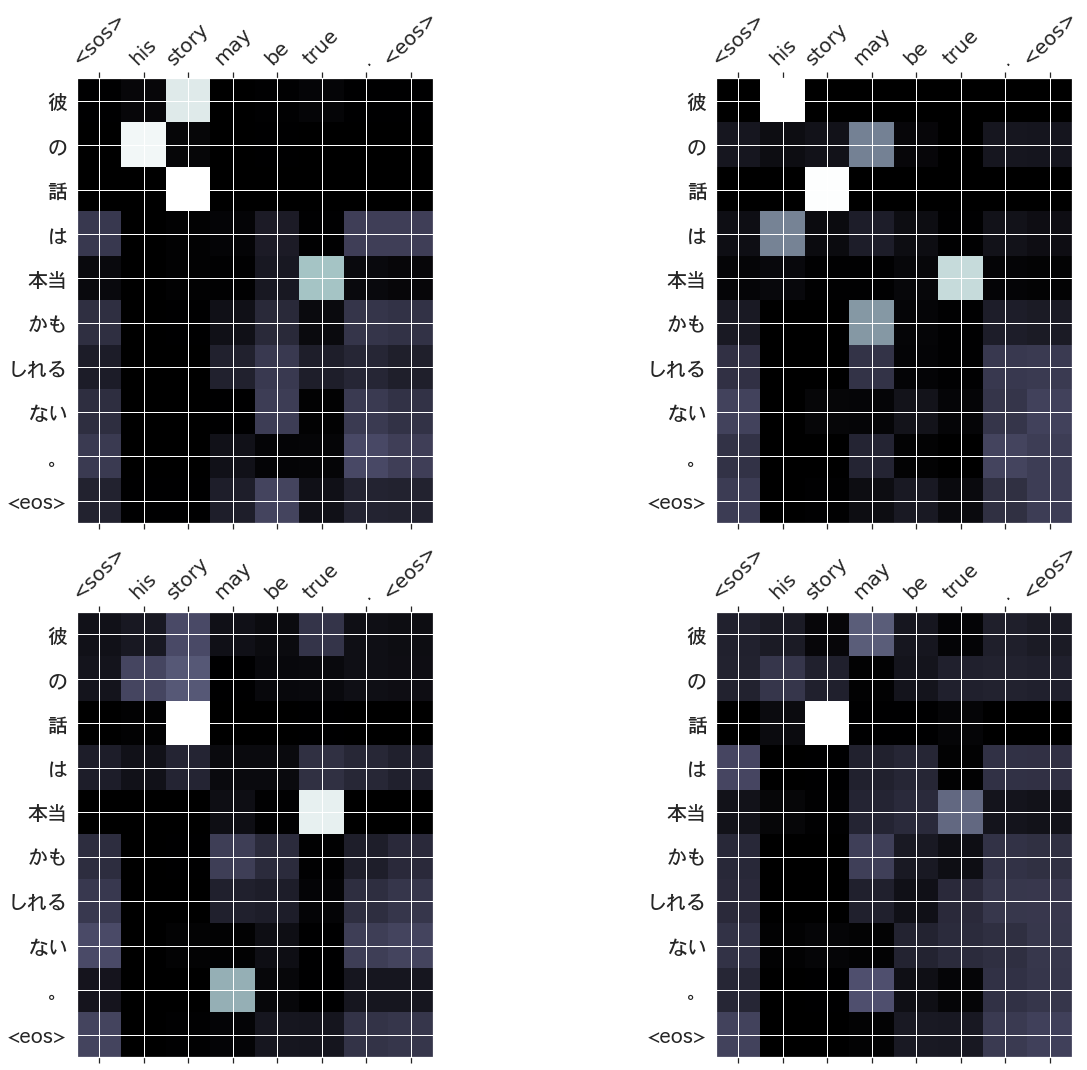

8
src      : get up early in the morning .
trg      : 朝 早い 起きる なさる 。
predicted: 朝 早い 起きる なさる 。 <eos>
     blue: 100.00%


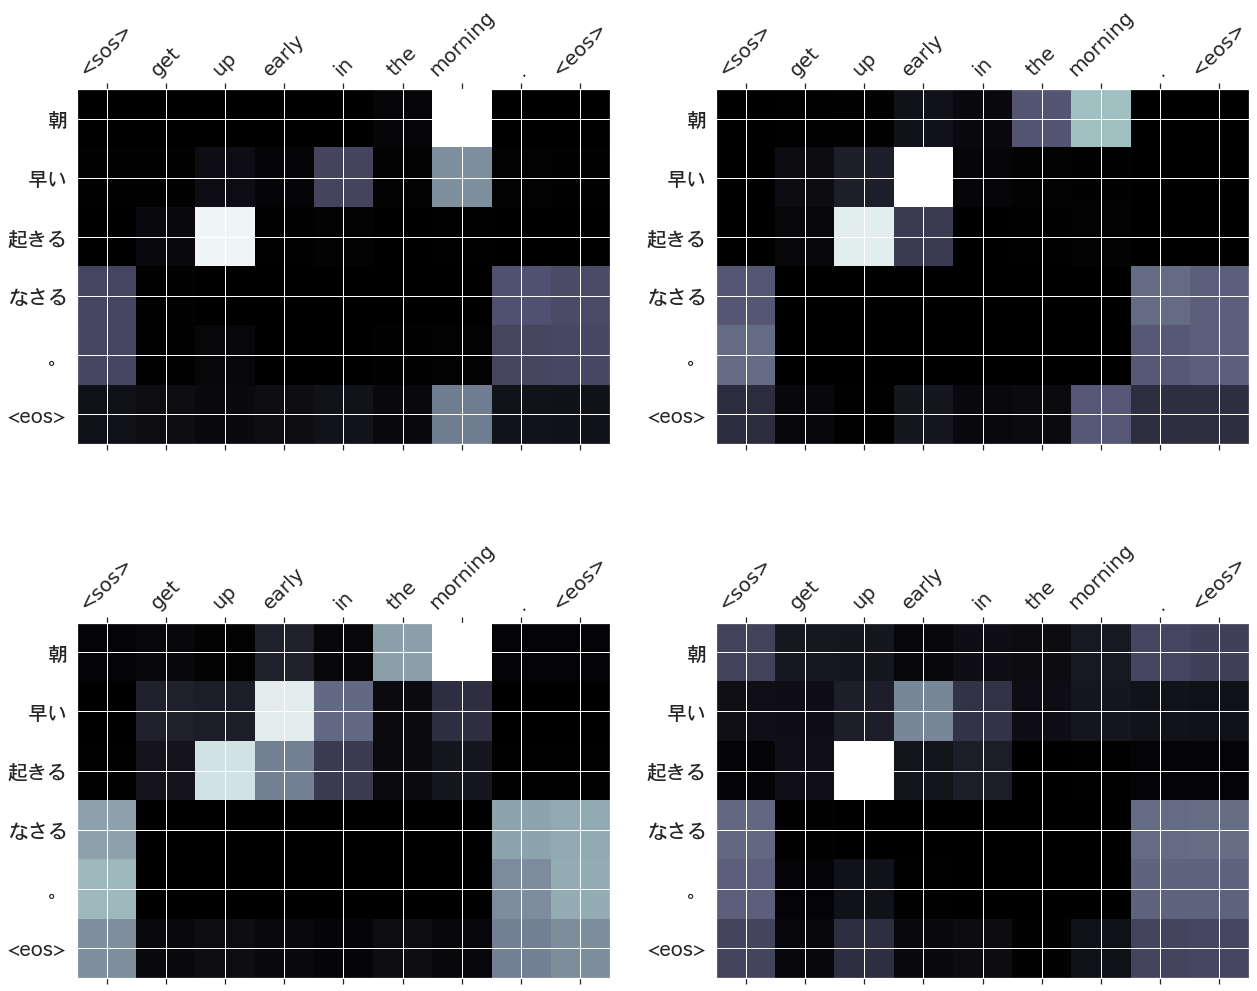

9
src      : i will wait here till he comes .
trg      : 彼 が 来る まで ここ で 待つ ます 。
predicted: 彼 が 来る まで ここ で 待つ ます 。 <eos>
     blue: 100.00%


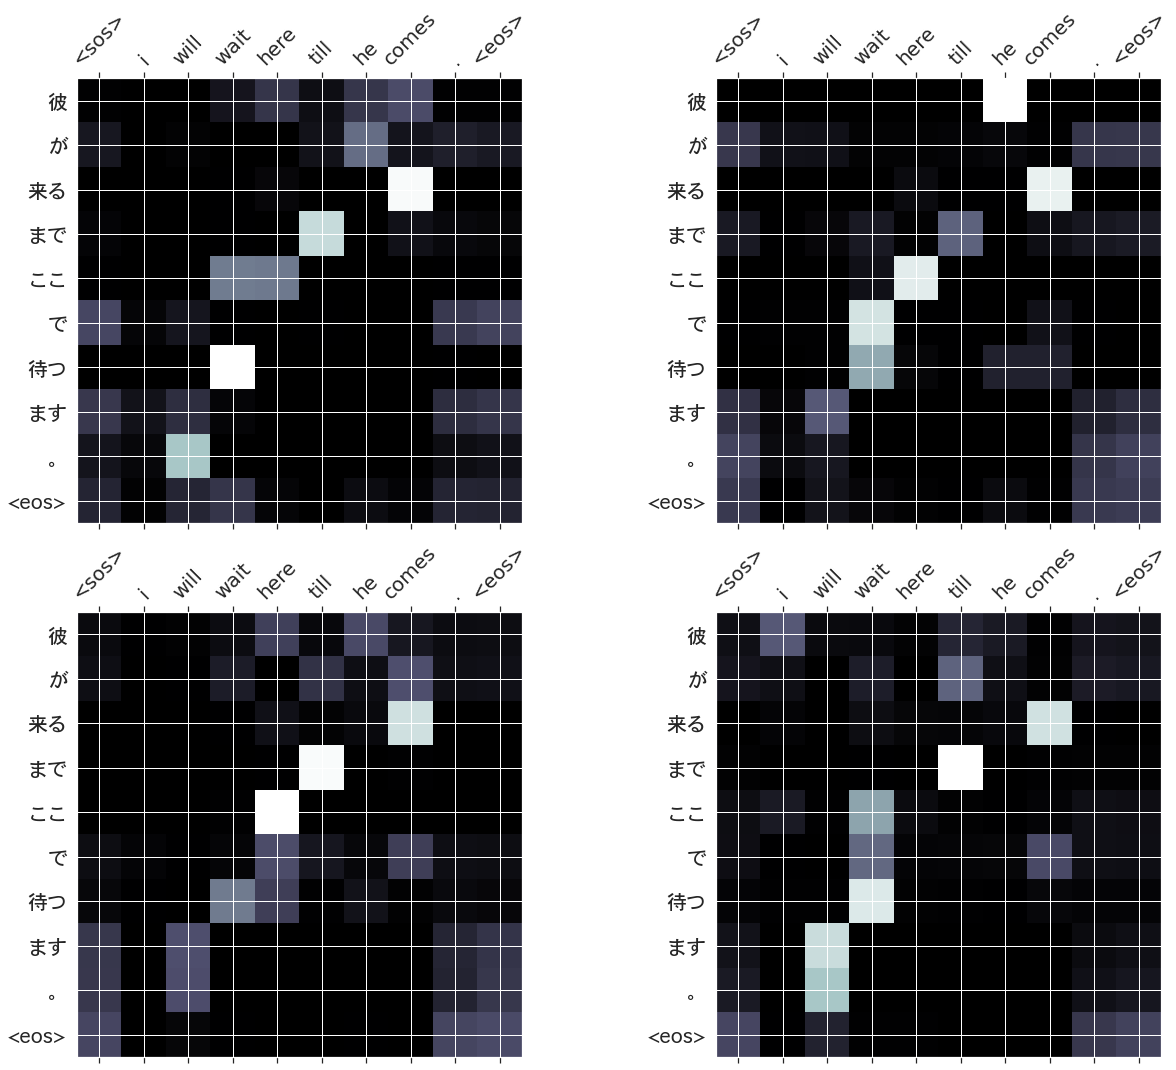

10
src      : his story may be true .
trg      : 彼 の 話 は 本当 かも しれる ない 。
predicted: 彼 の 話 は 本当 かも しれる ない 。 <eos>
     blue: 100.00%


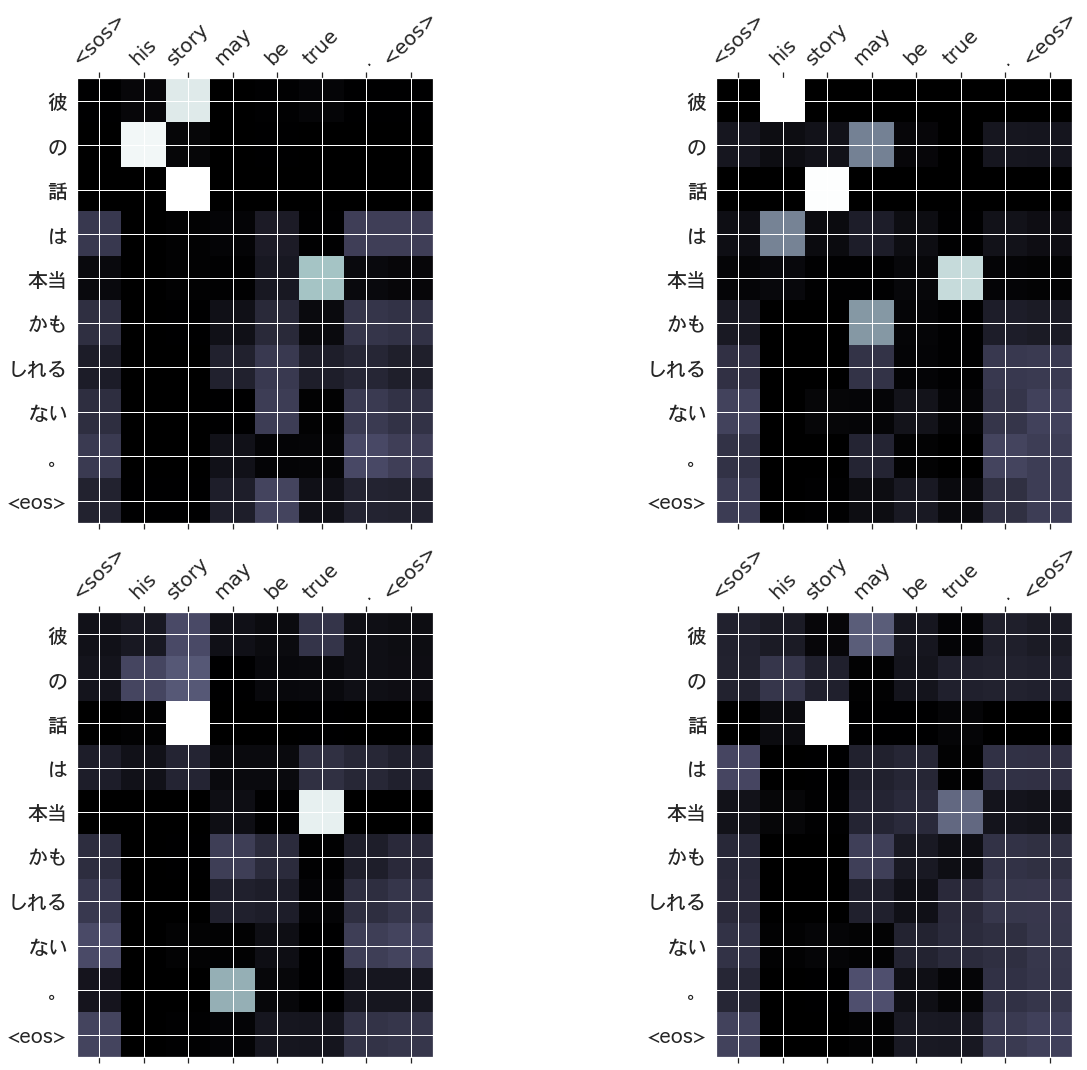

11
src      : it was not long before the rumor died out .
trg      : まもなく その 噂 は 消える た 。
predicted: まもなく その 噂 は 消える た 。 <eos>
     blue: 100.00%


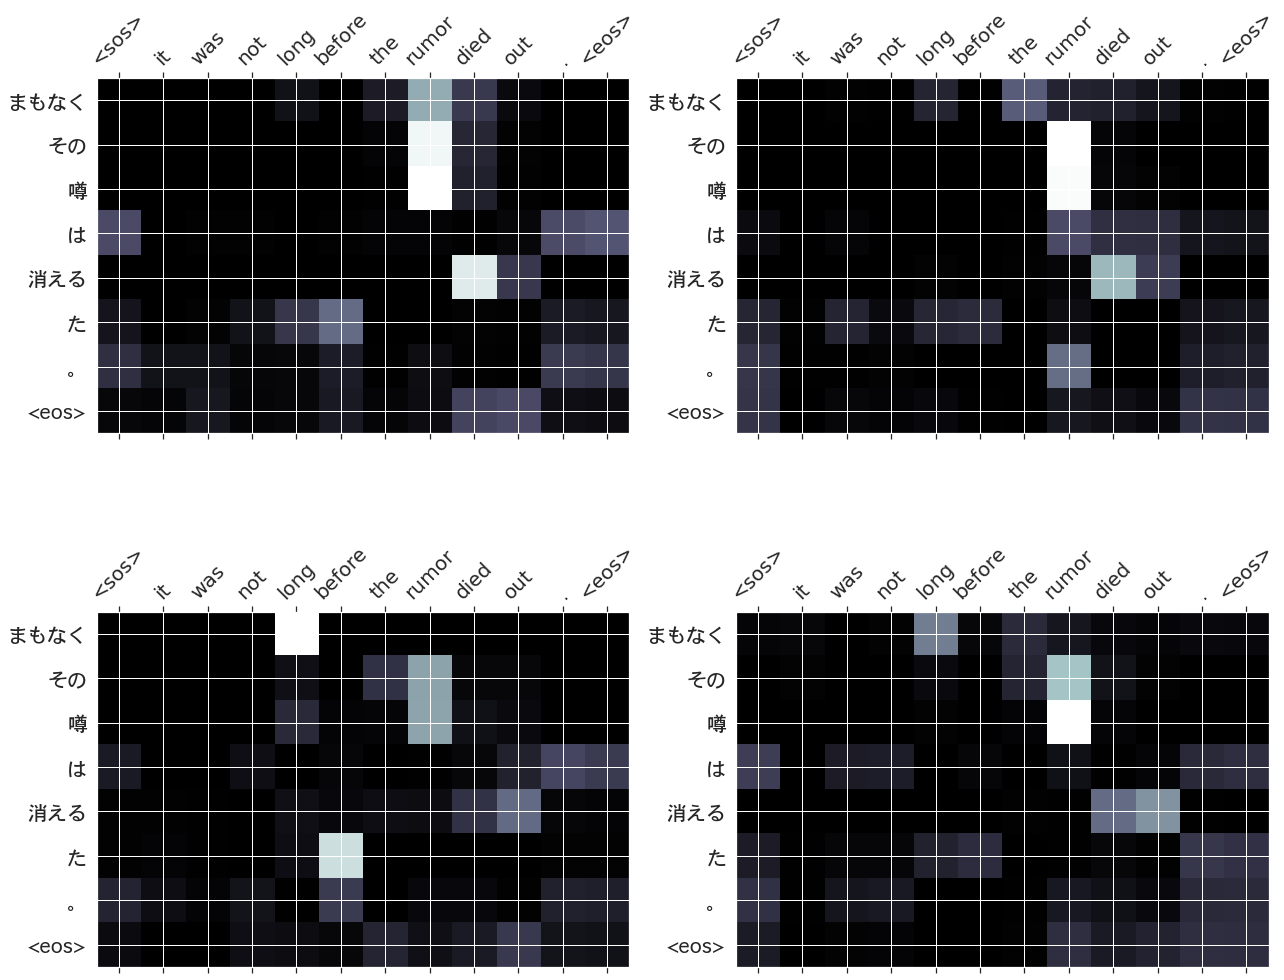

12
src      : are you in favor of the proposal ?
trg      : あなた は その 提案 に 賛成 です か 。
predicted: あなた は その 提案 に 賛成 です か 。 <eos>
     blue: 100.00%


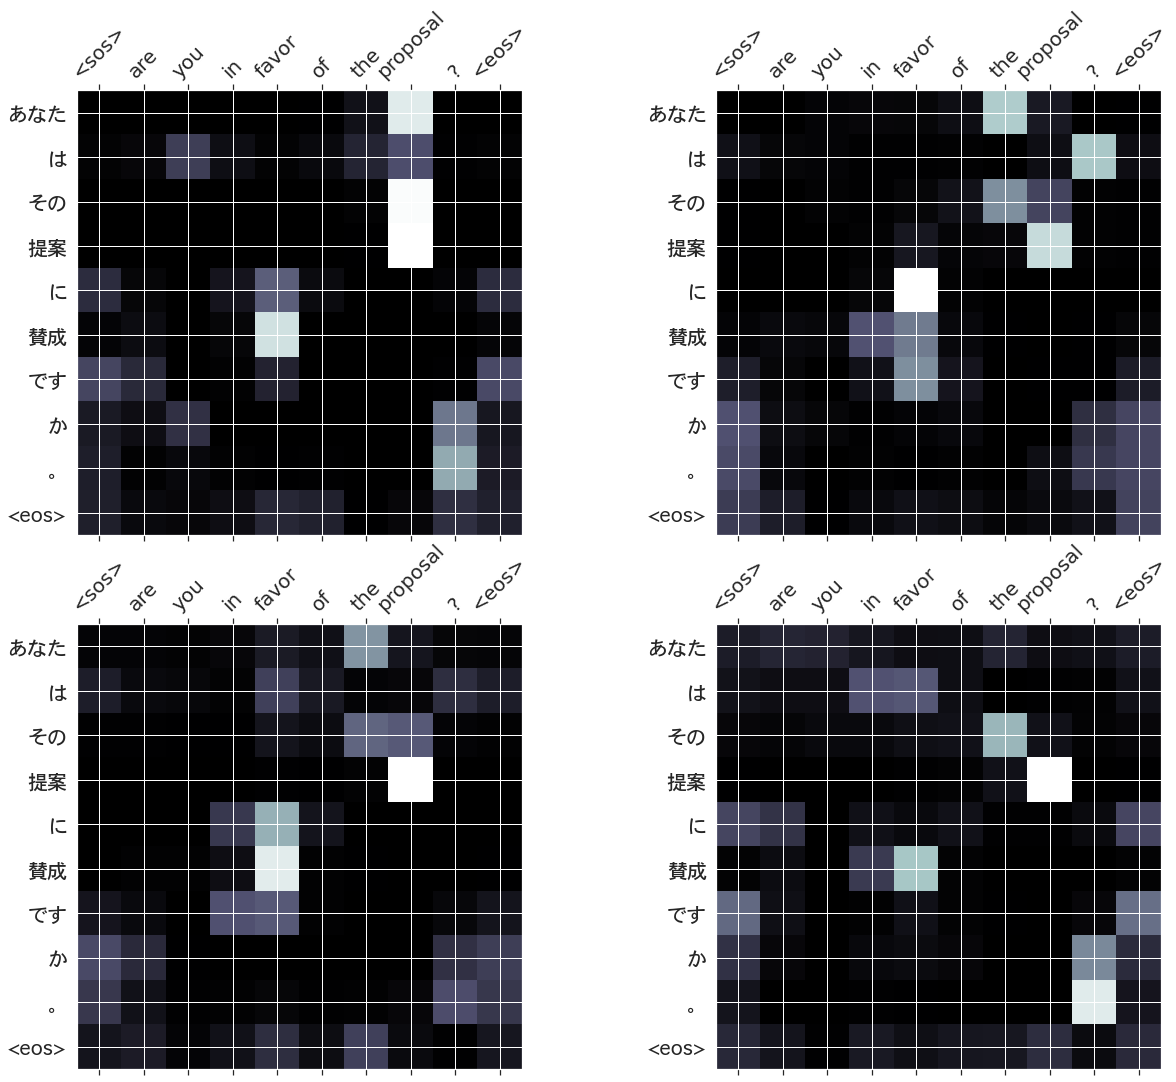

13
src      : i agree to your plan .
trg      : あなた の 計画 に 賛成 です 。
predicted: あなた の 計画 に 賛成 です 。 <eos>
     blue: 100.00%


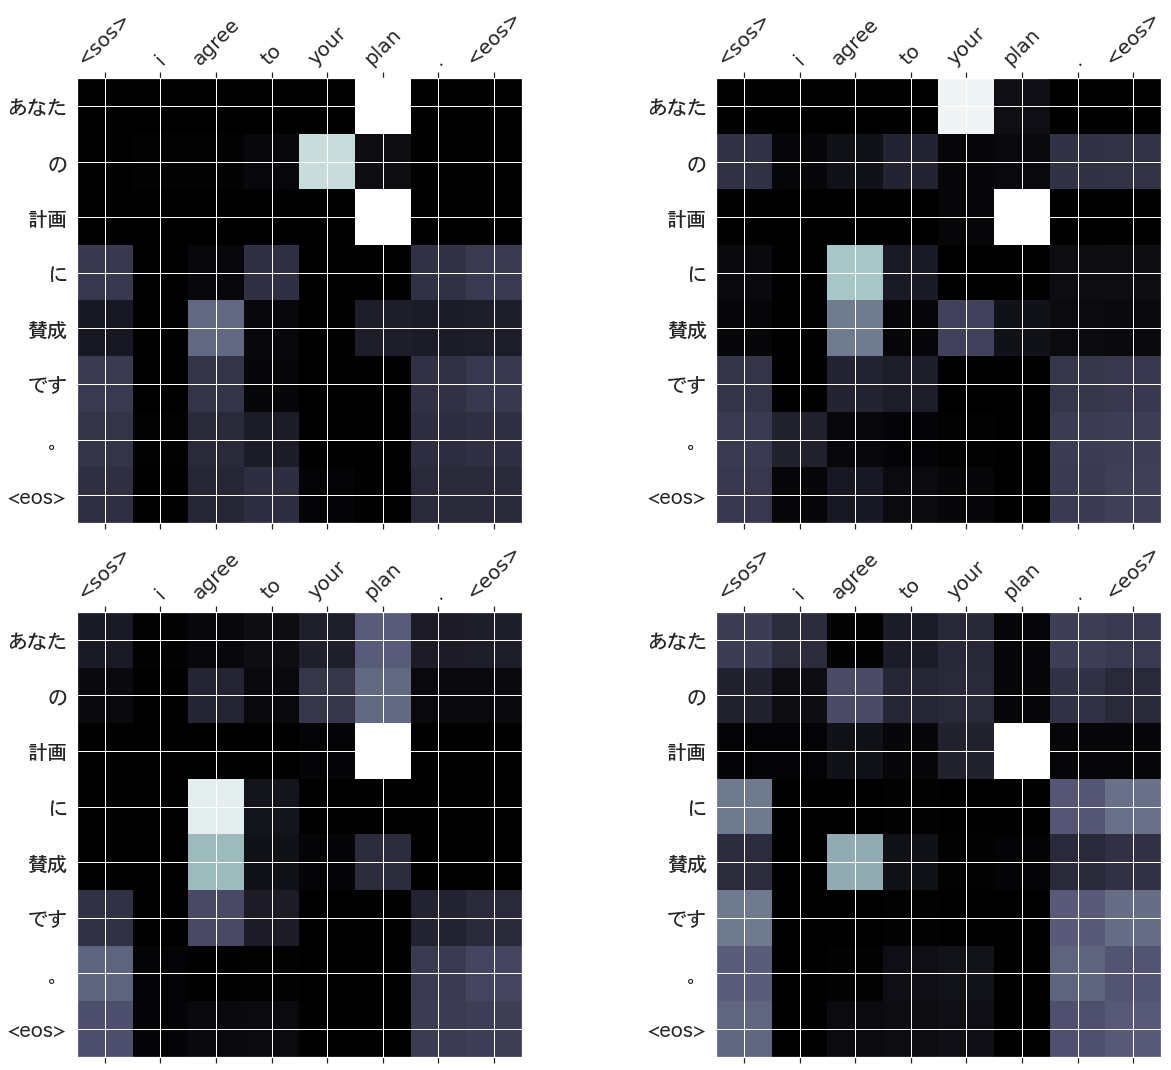

14
src      : tom is taller than i.
trg      : トム は 私 より 背 が 高い 。
predicted: トム は 私 より 背 が 高い 。 <eos>
     blue: 100.00%


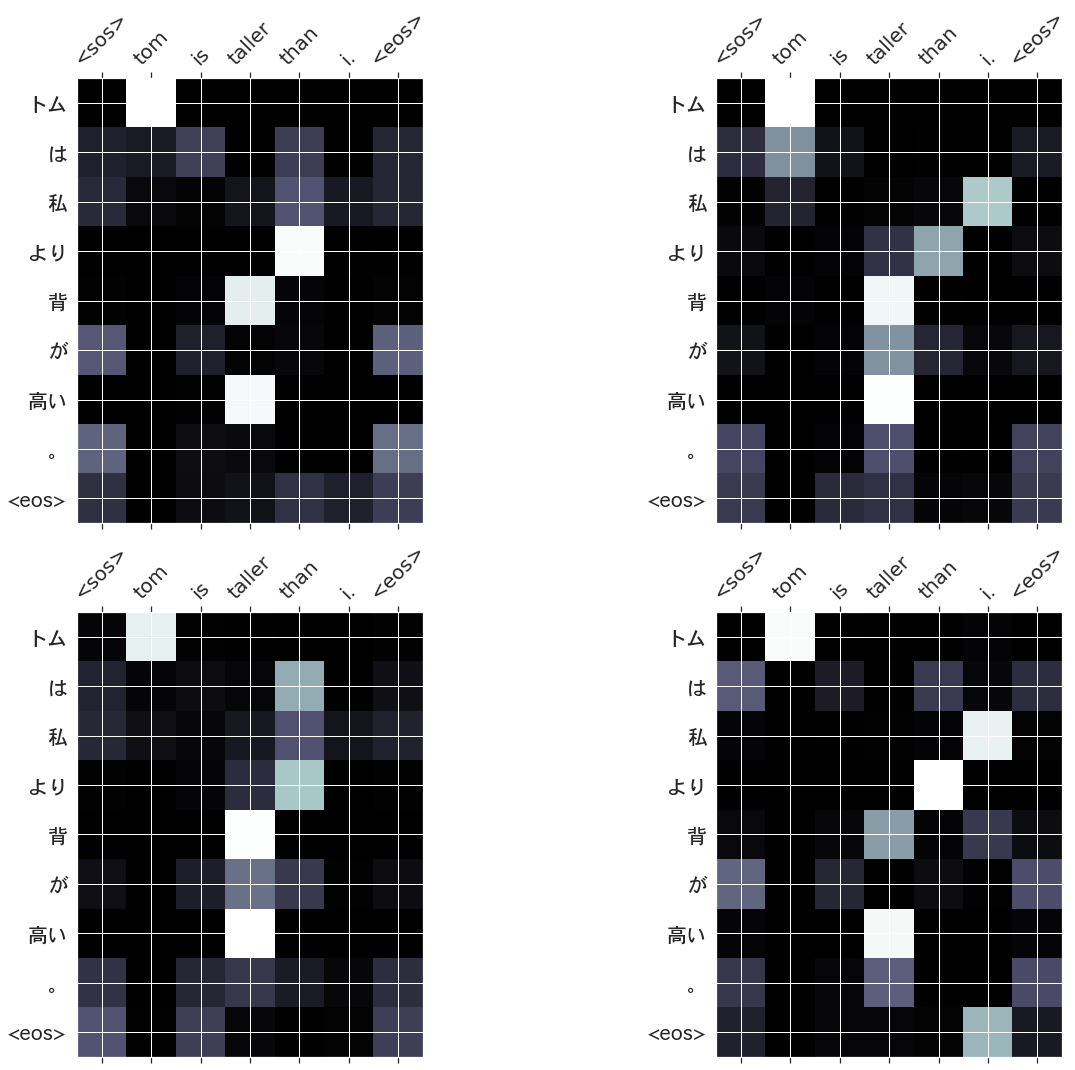

15
src      : the soldier was killed in action .
trg      : その 兵士 は 戦死 する た 。
predicted: その 兵士 は 戦死 する た 。 <eos>
     blue: 100.00%


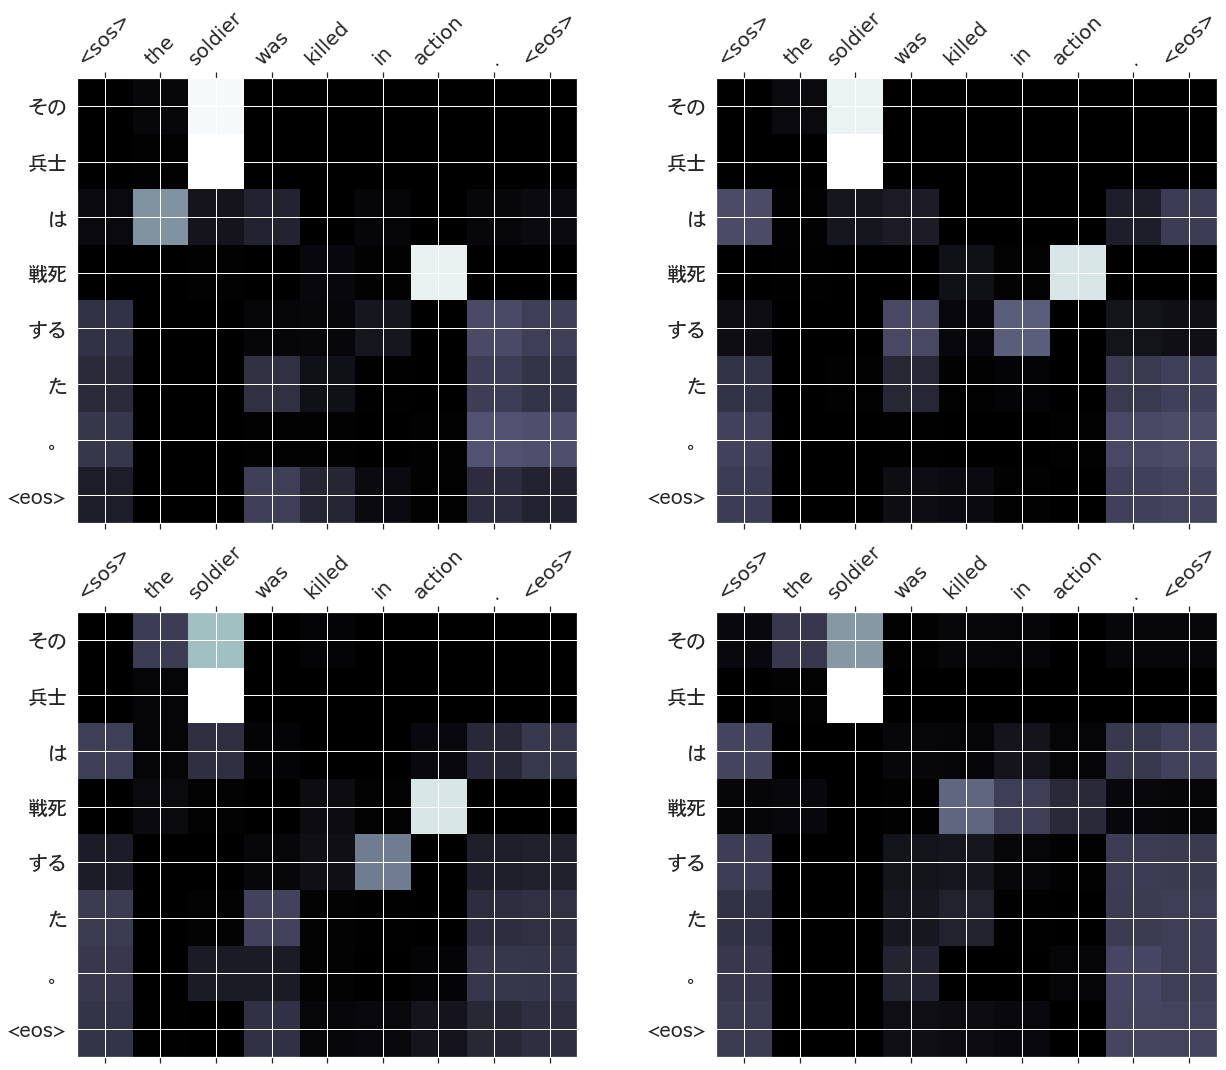

16
src      : i agree to your plan .
trg      : あなた の 計画 に 賛成 です 。
predicted: あなた の 計画 に 賛成 です 。 <eos>
     blue: 100.00%


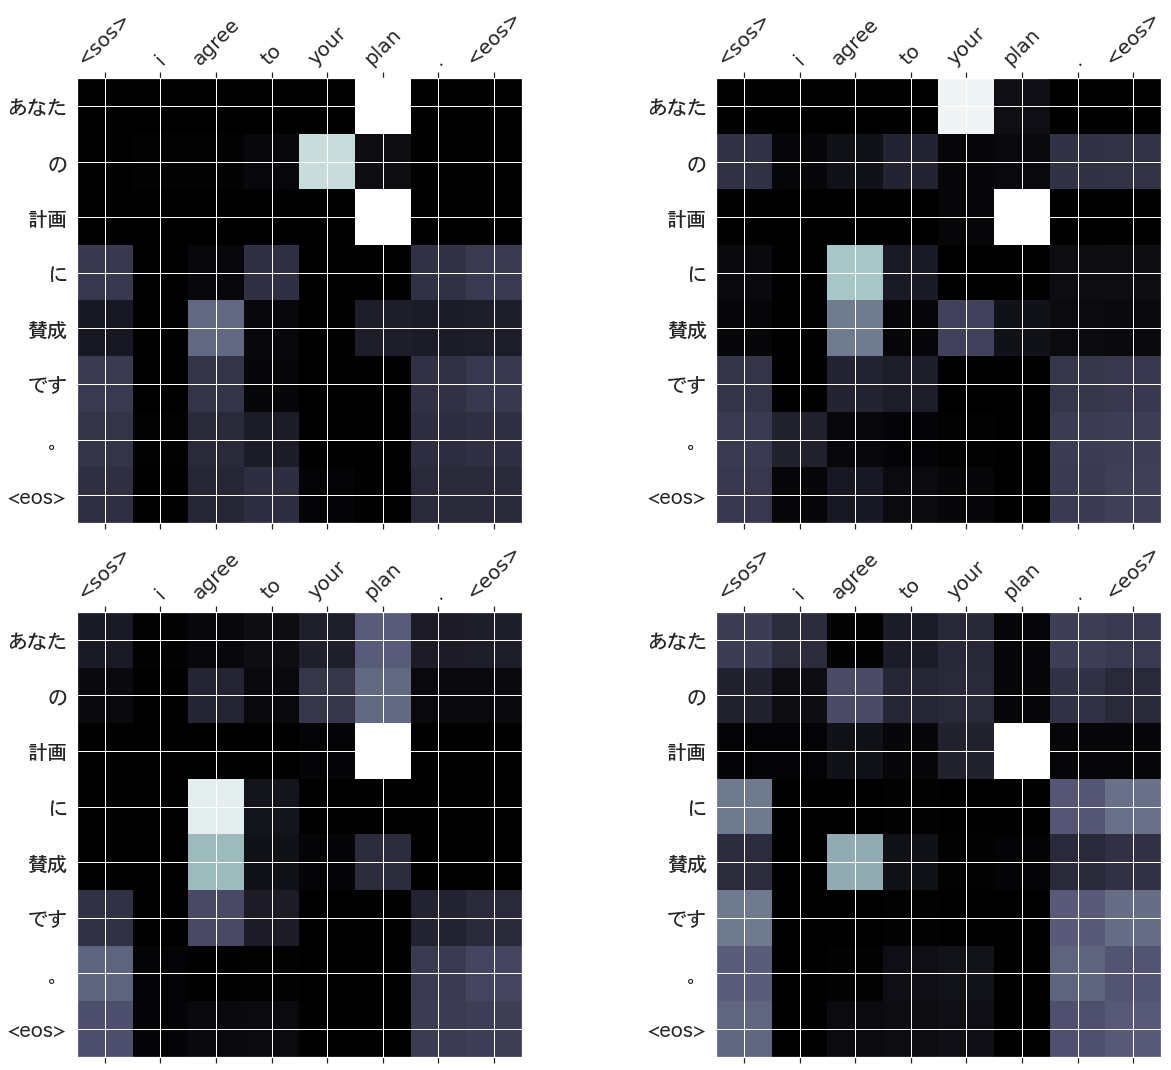

17
src      : he read this book yesterday .
trg      : 彼 は 昨日 この 本 を 読む だ 。
predicted: 彼 は 昨日 この 本 を 読む だ 。 <eos>
     blue: 100.00%


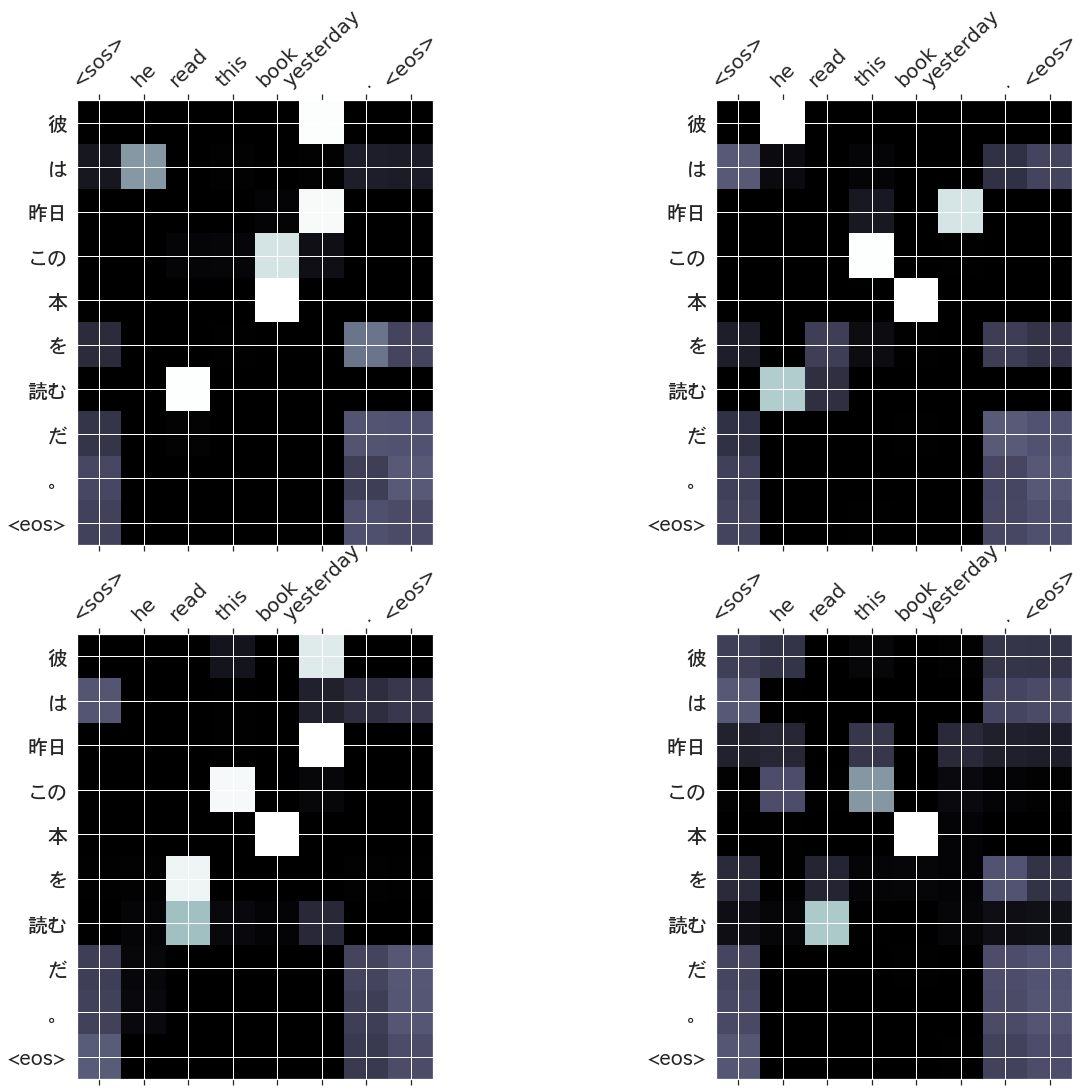

18
src      : fortunately , he was free of debt .
trg      : 幸運 に も 彼 は 借金 が ない た 。
predicted: 幸運 に も 彼 は 借金 が ない た 。 <eos>
     blue: 100.00%


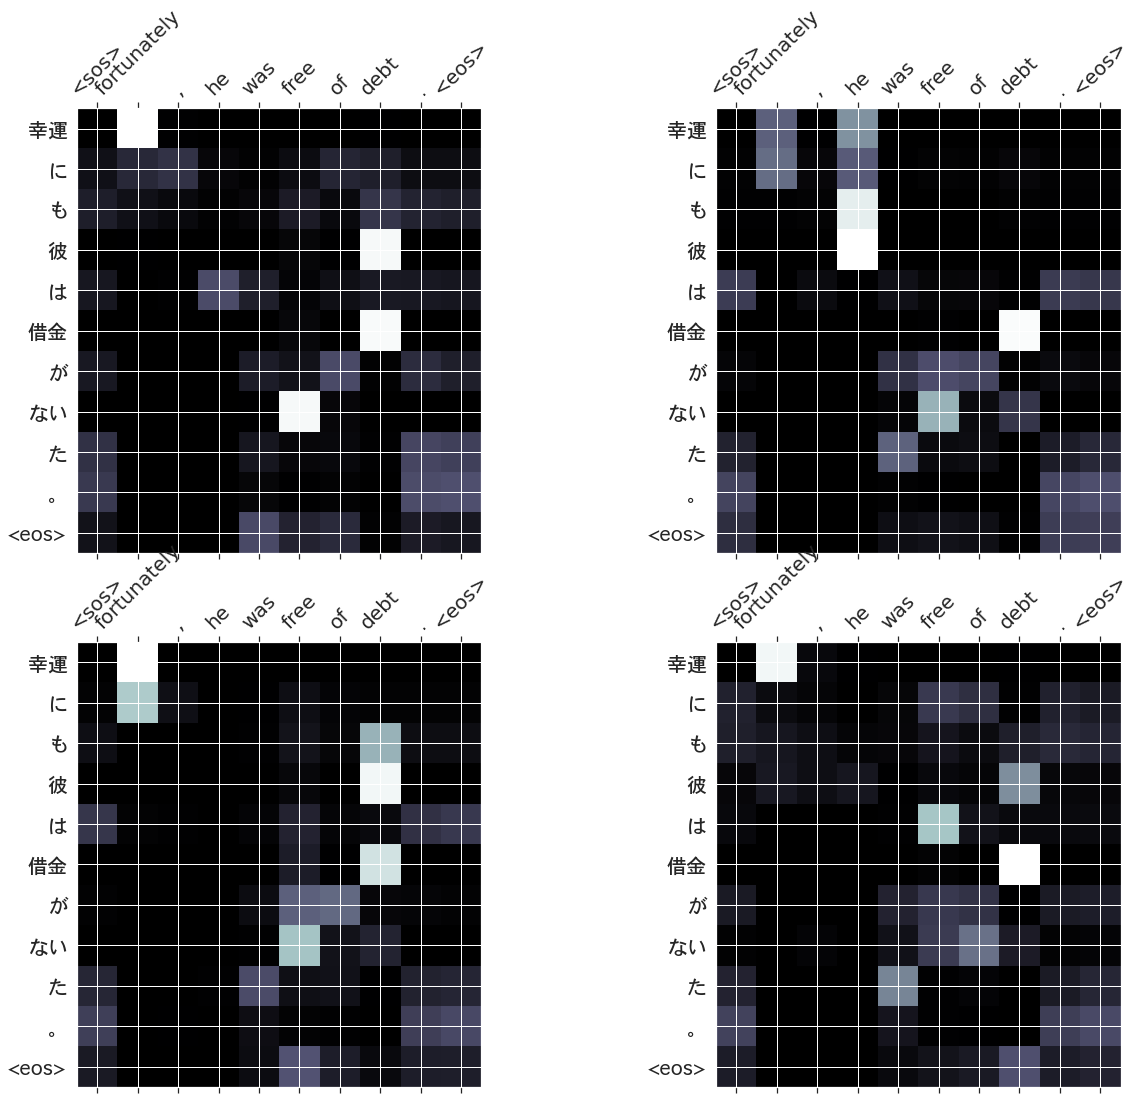

19
src      : this cake is very sweet .
trg      : この ケーキ は とても 甘い 。
predicted: この ケーキ は とても 甘い 。 <eos>
     blue: 100.00%


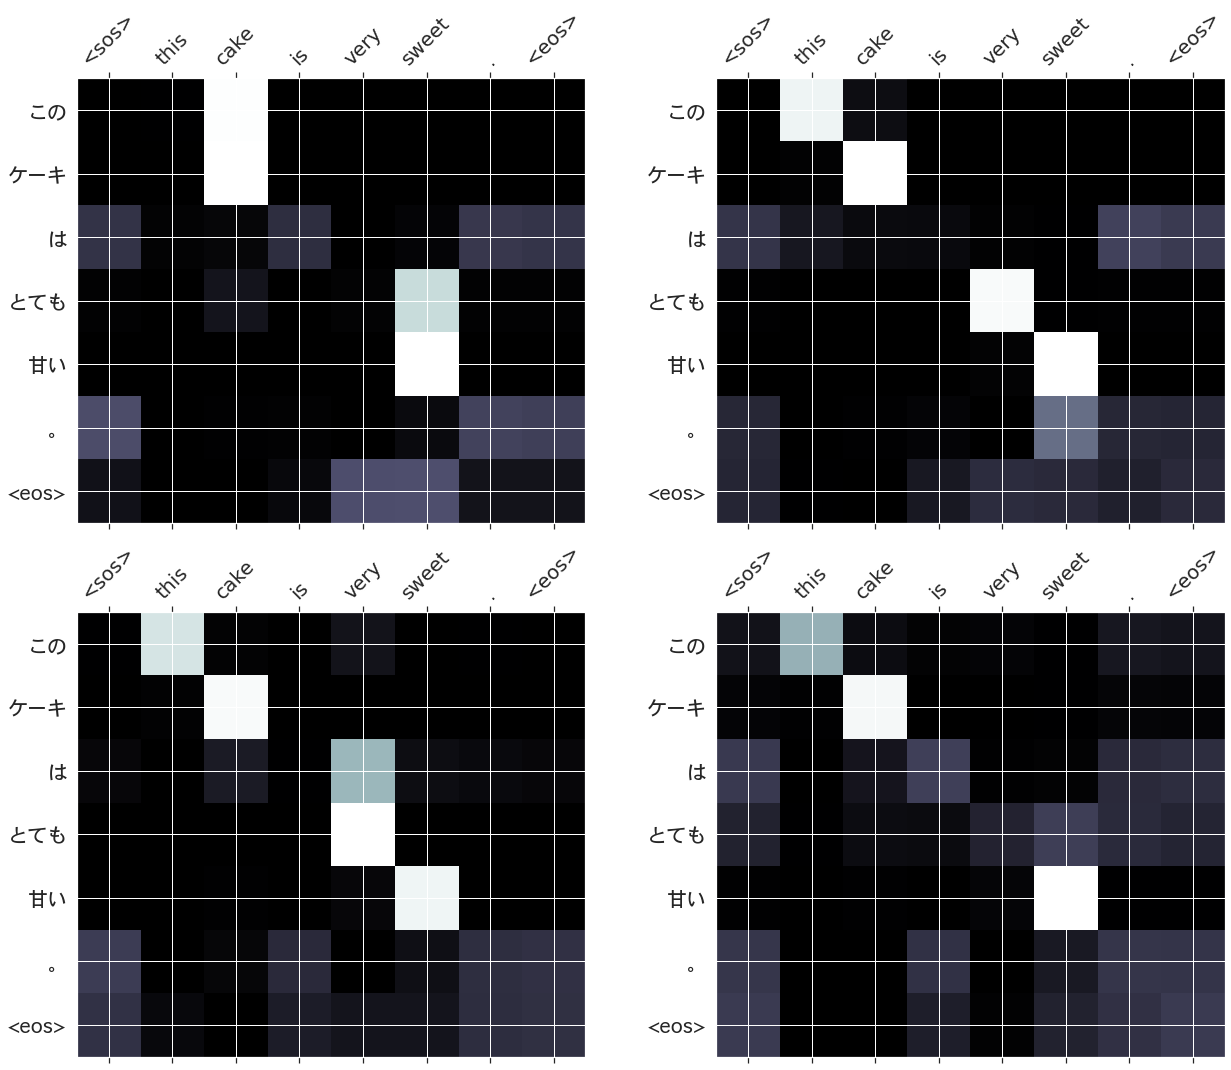

20
src      : these shoes are a little loose .
trg      : この 靴 は 少し 緩い 。
predicted: この 靴 は 少し 緩い 。 <eos>
     blue: 100.00%


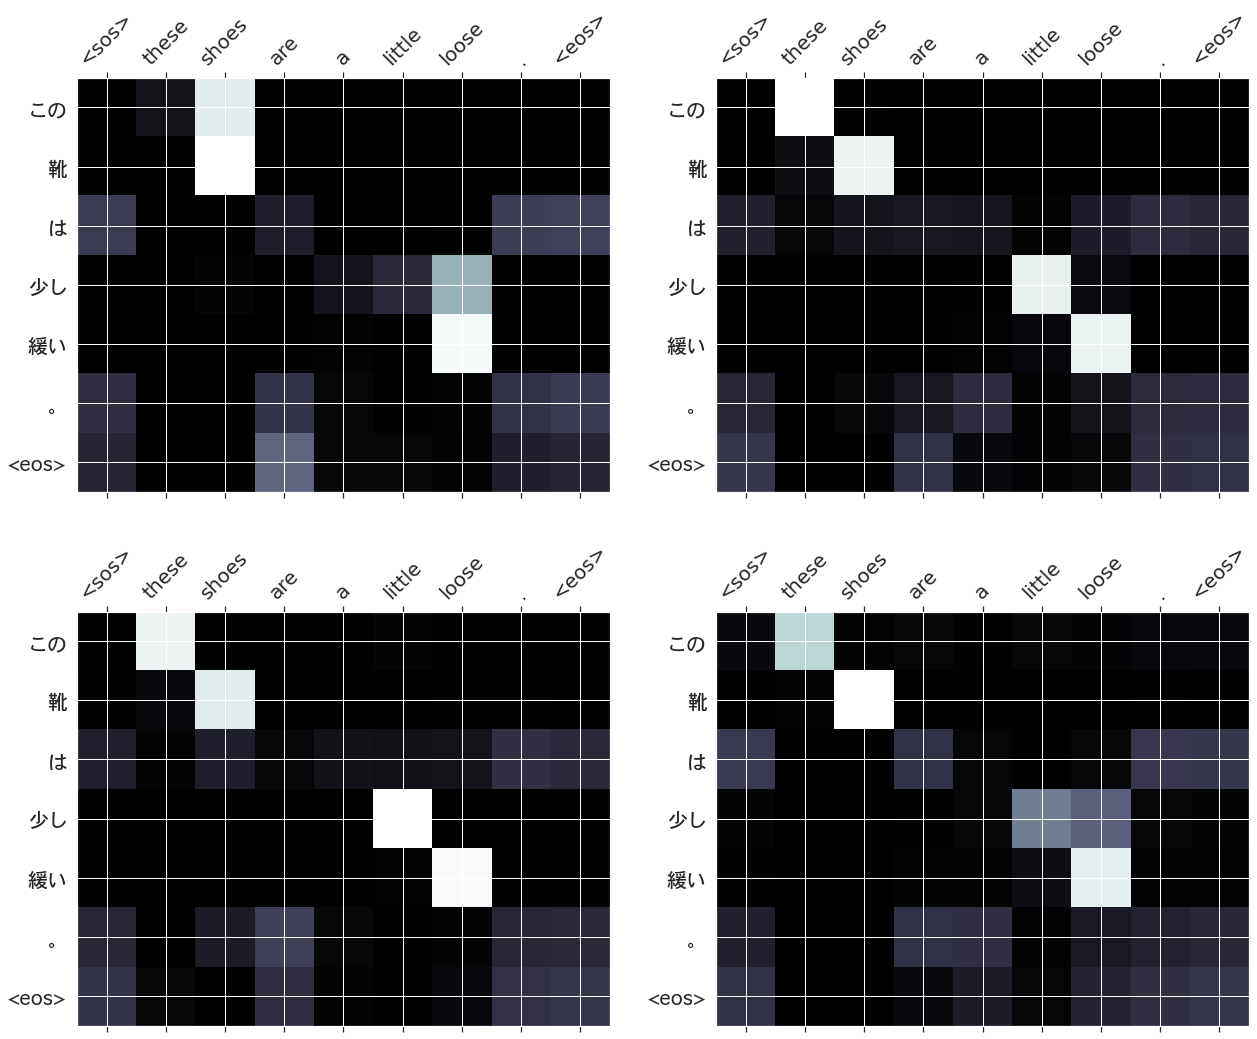

21
src      : she got angry .
trg      : 彼女 は 怒る た 。
predicted: 彼女 は 怒る た 。 <eos>
     blue: 100.00%


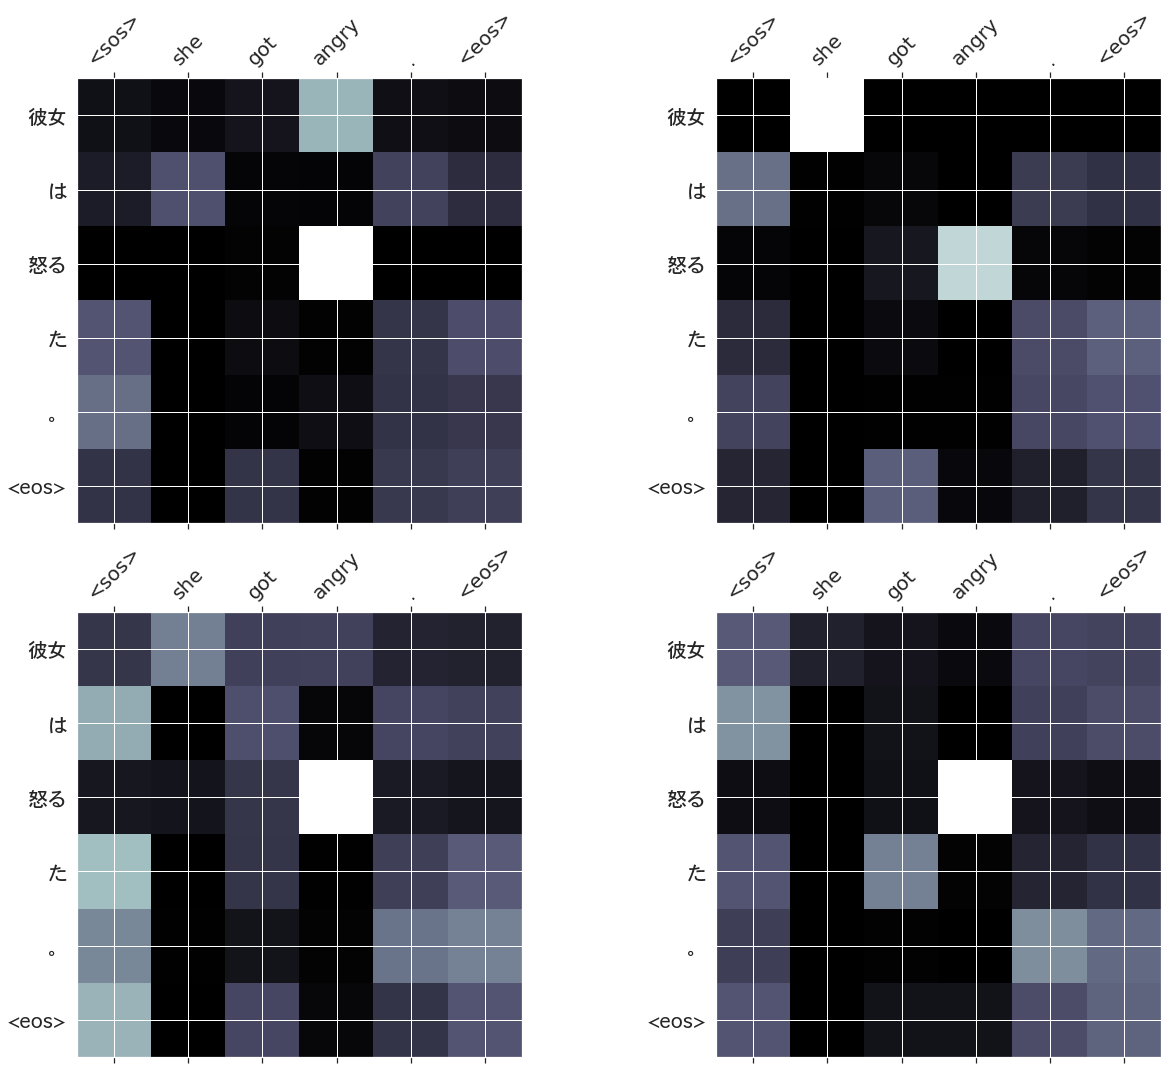

22
src      : i will wait here till he comes .
trg      : 彼 が 来る まで ここ で 待つ ます 。
predicted: 彼 が 来る まで ここ で 待つ ます 。 <eos>
     blue: 100.00%


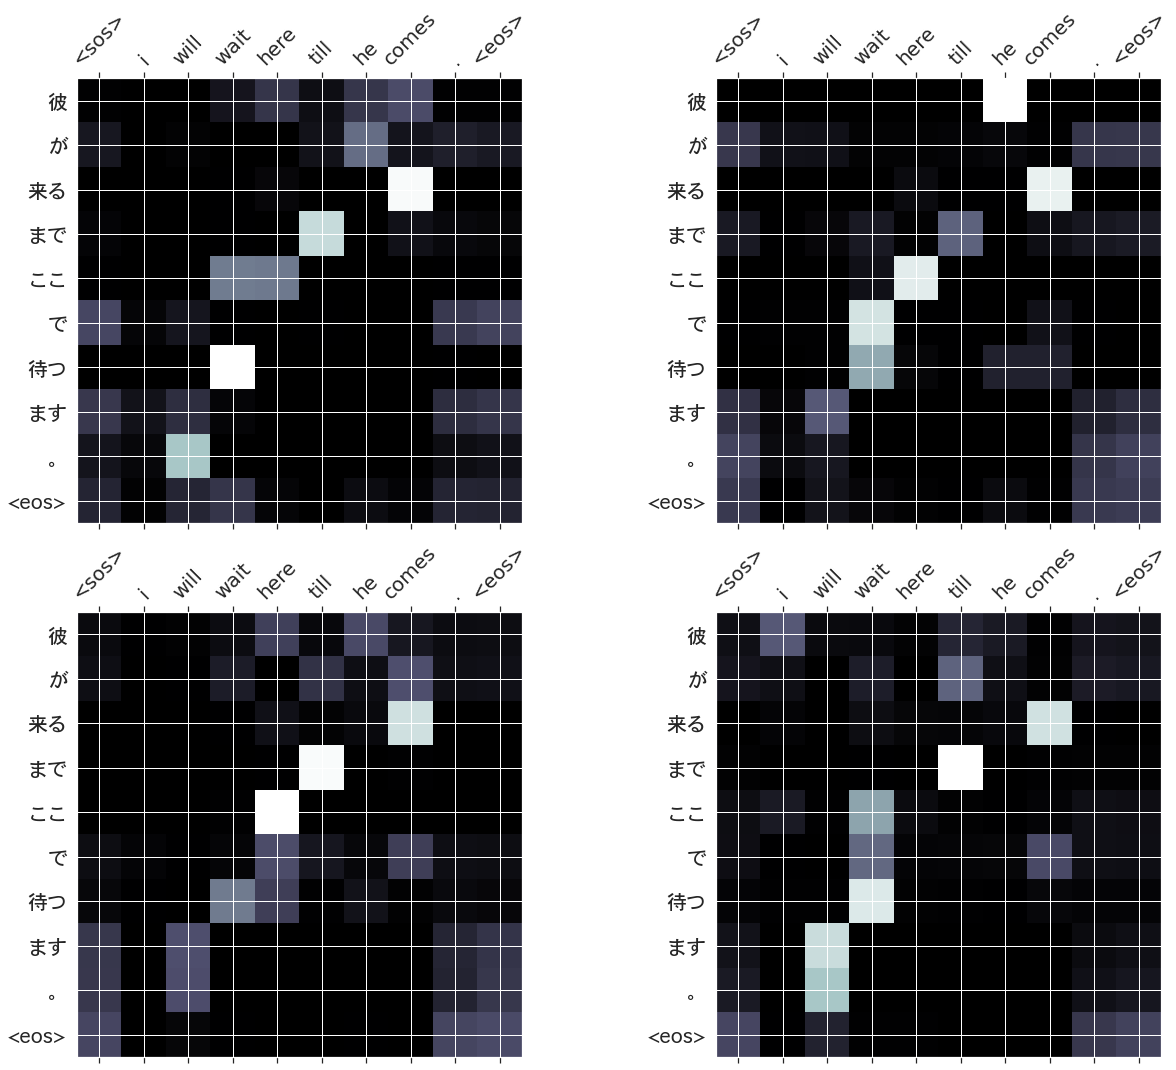

23
src      : she is a poor cook .
trg      : 彼女 は 料理 が 下手 だ 。
predicted: 彼女 は 料理 が 下手 だ 。 <eos>
     blue: 100.00%


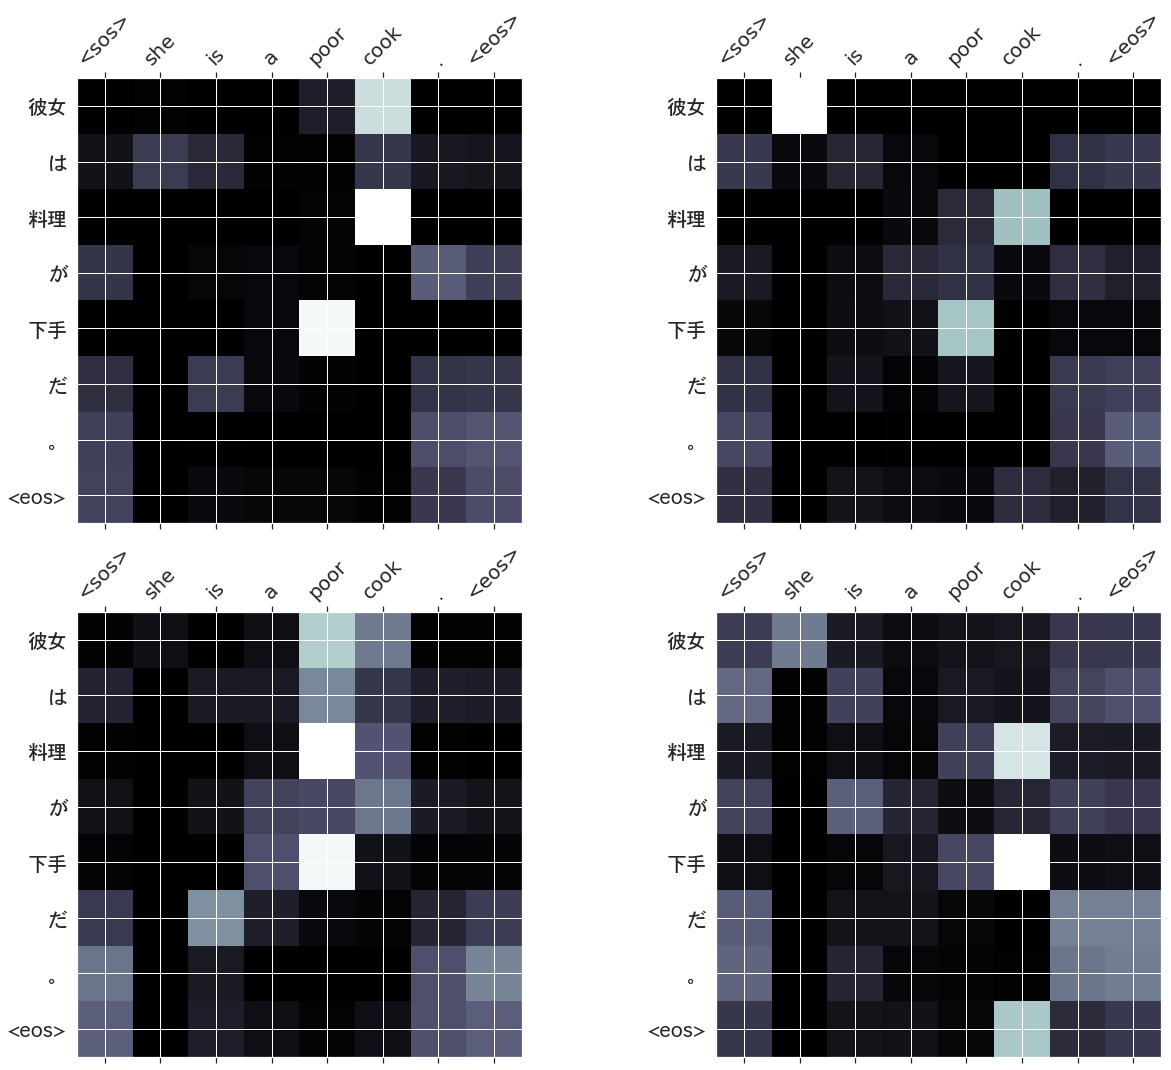

24
src      : she is hard at work .
trg      : 彼女 は 一生懸命 働く て いる 。
predicted: 彼女 は 一生懸命 働く て いる 。 <eos>
     blue: 100.00%


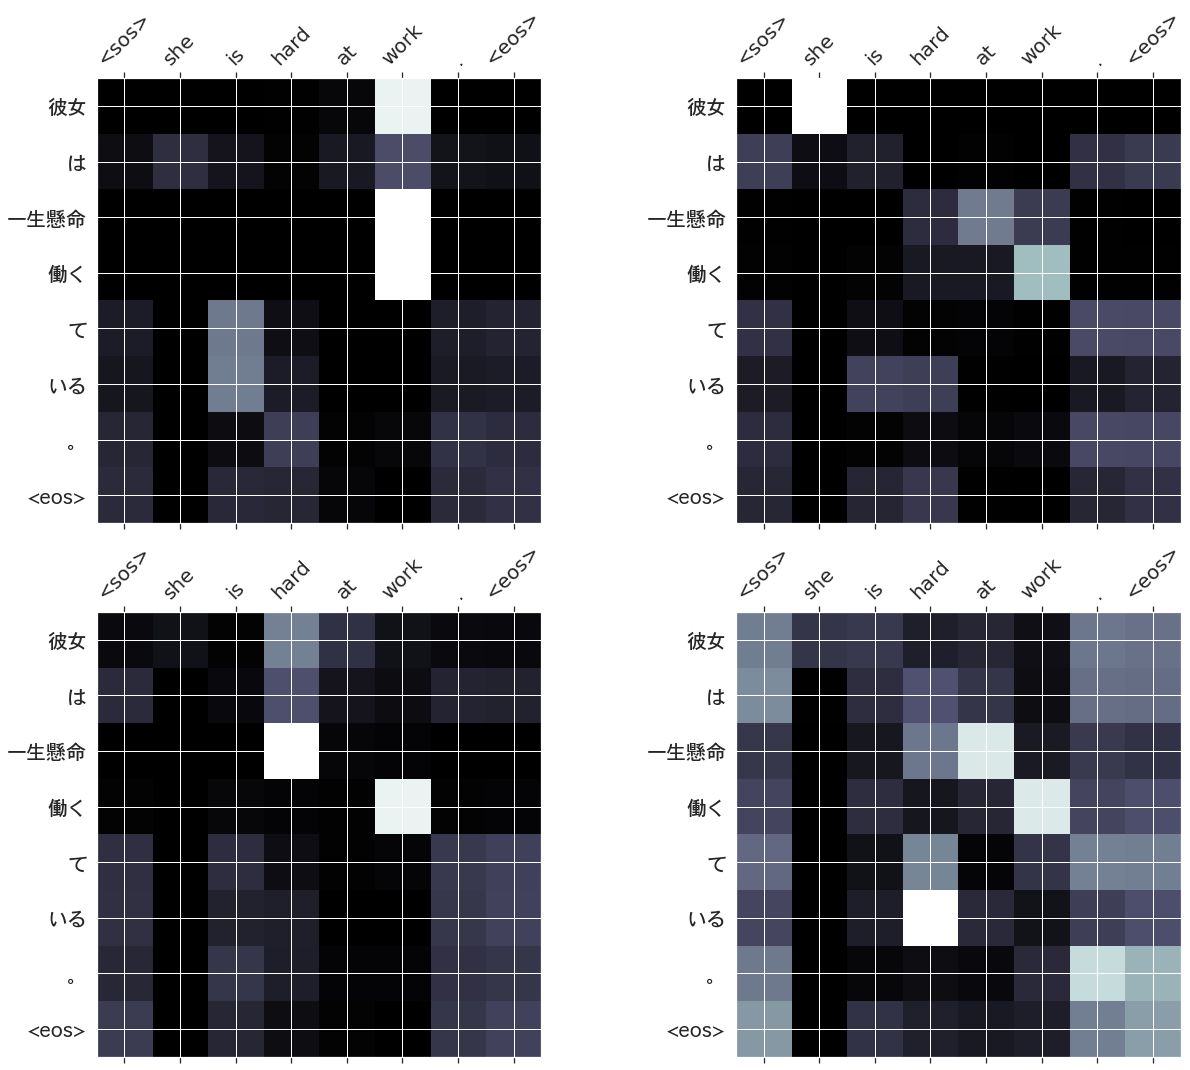

25
src      : he crossed over the sea .
trg      : 彼 は 海 を 渡る た 。
predicted: 彼 は 海 を 渡る た 。 <eos>
     blue: 100.00%


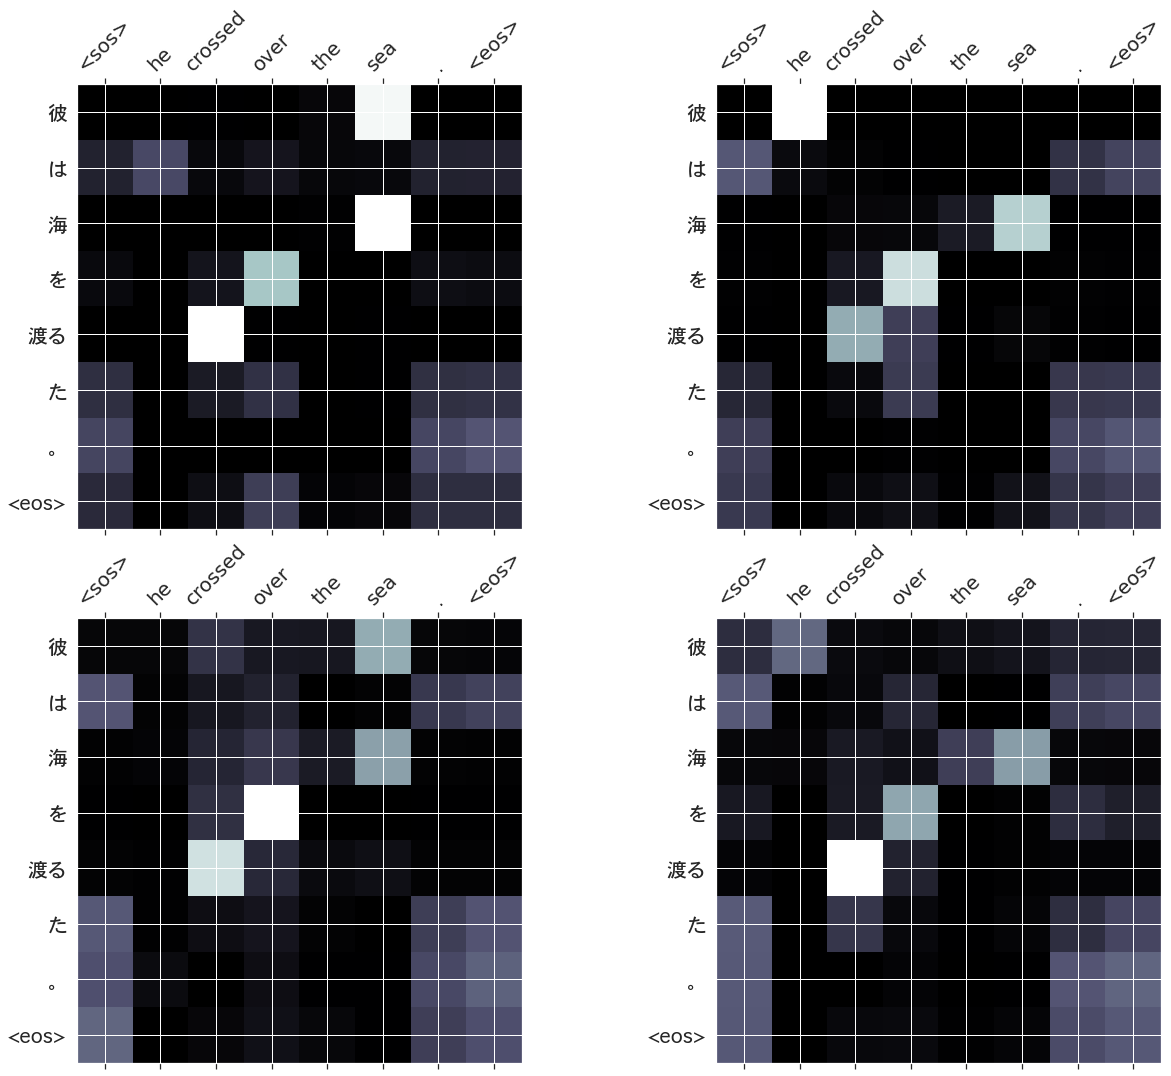

26
src      : i would rather die than do it .
trg      : 私 は それ を する より むしろ 死ぬ たい 。
predicted: 私 は それ を する より むしろ 死ぬ たい 。 <eos>
     blue: 100.00%


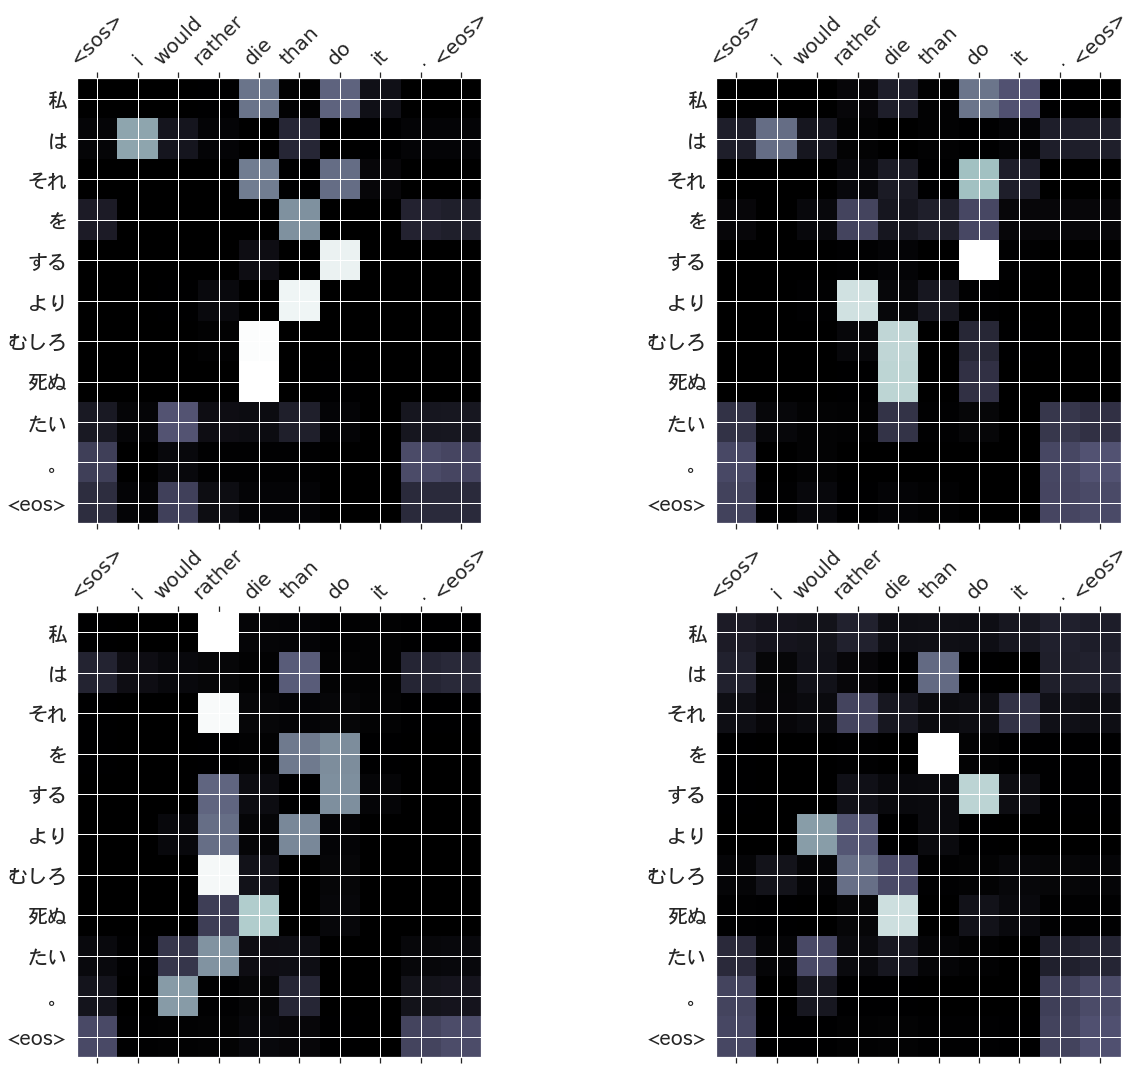

27
src      : i remember my school days very well .
trg      : 私 は 学校 時代 を よく 覚える て いる 。
predicted: 私 は 学校 時代 を よく 覚える て いる 。 <eos>
     blue: 100.00%


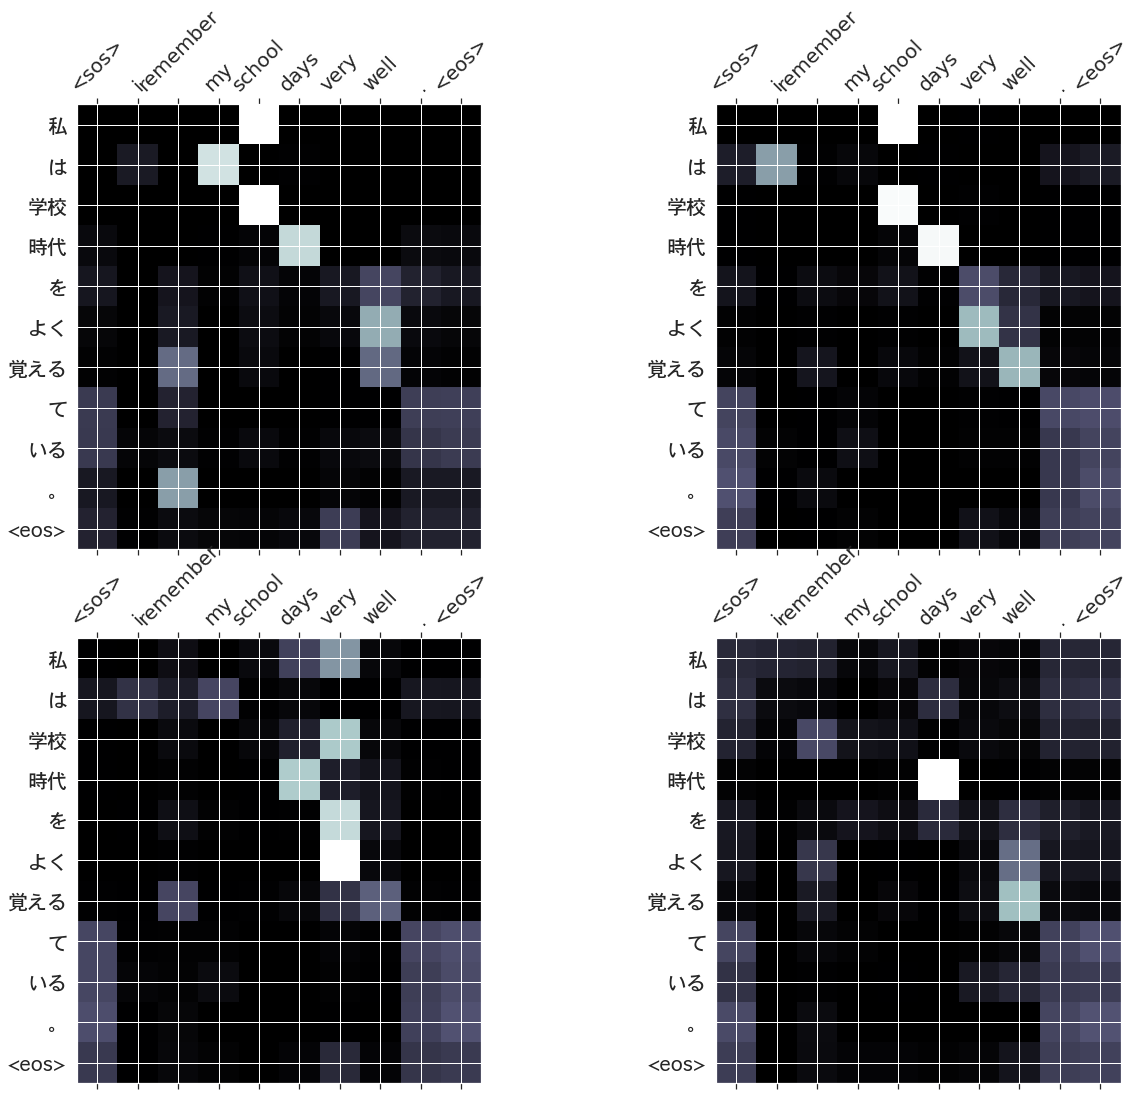

28
src      : his story may be true .
trg      : 彼 の 話 は 本当 かも しれる ない 。
predicted: 彼 の 話 は 本当 かも しれる ない 。 <eos>
     blue: 100.00%


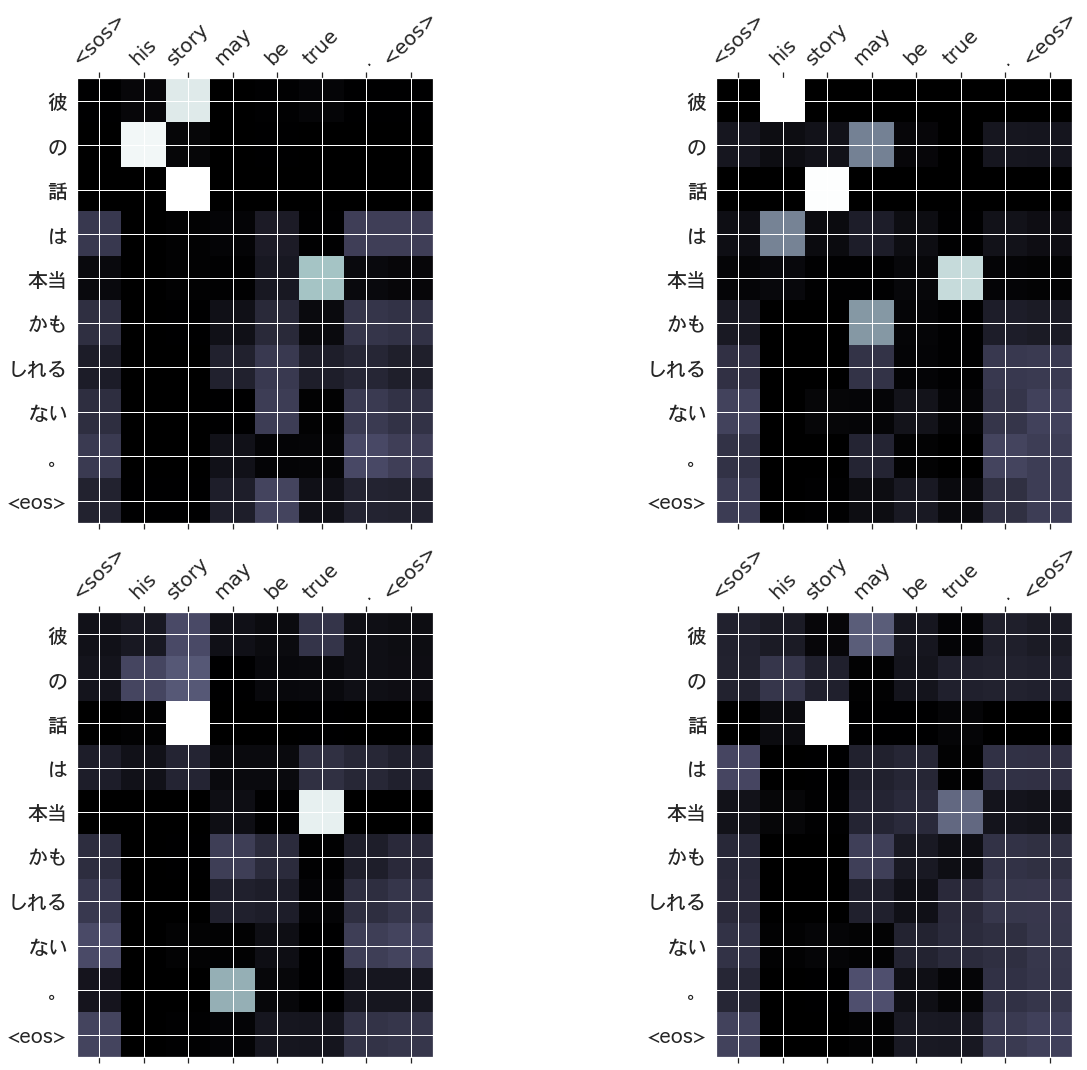

29
src      : george did business in the same manner as his father .
trg      : ジョージ は 父親 と 同じ やり方 で 仕事 を する た 。
predicted: ジョージ は 父親 と 同じ やり方 で 仕事 を する た 。 <eos>
     blue: 100.00%


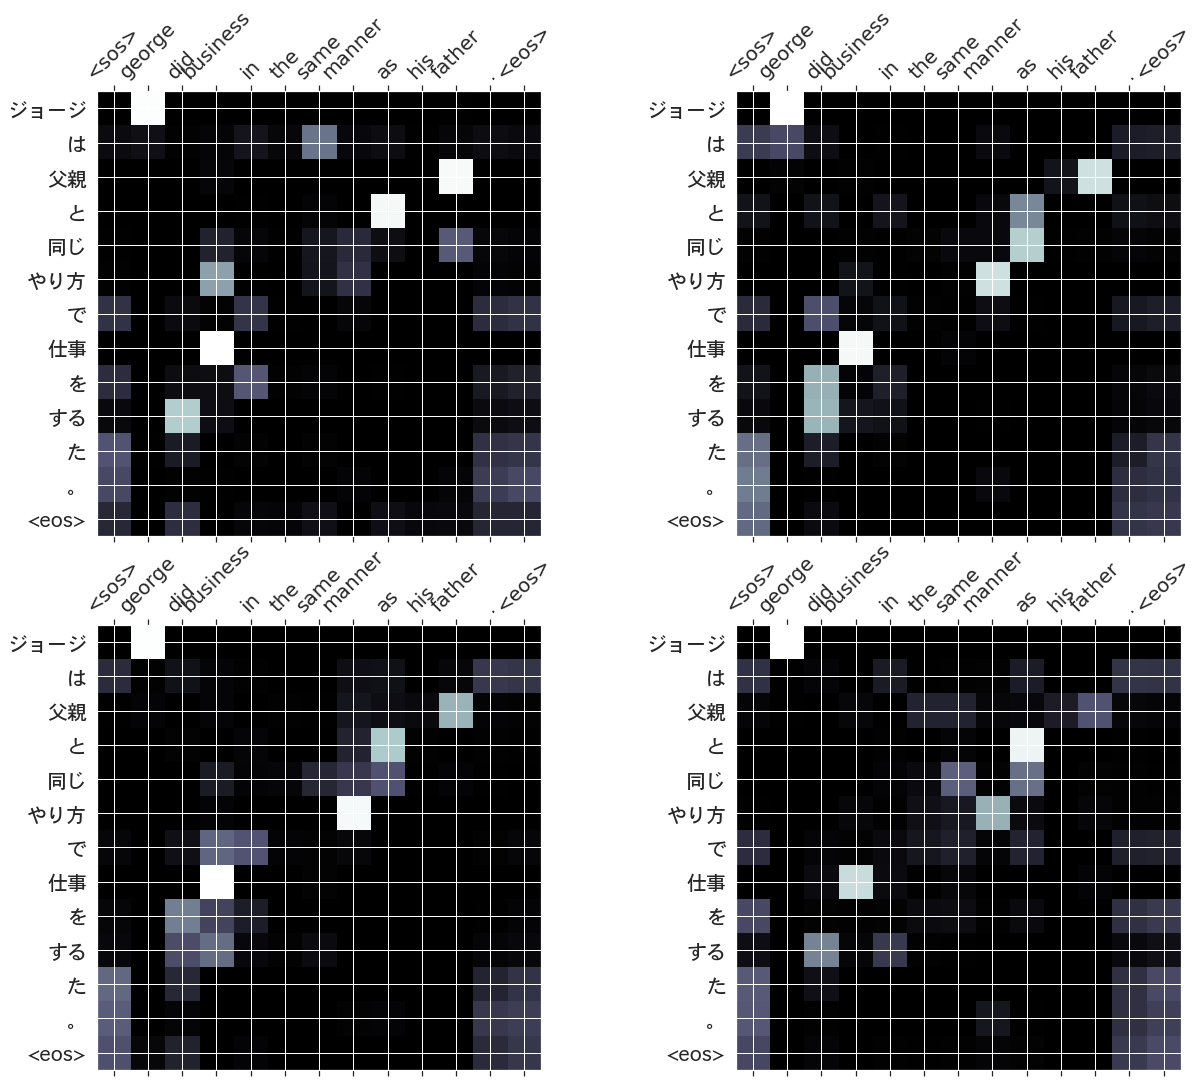

30
src      : she finally reached the hotel .
trg      : 彼女 は やっと その ホテル に 着く た 。
predicted: 彼女 は やっと その ホテル に 着く た 。 <eos>
     blue: 100.00%


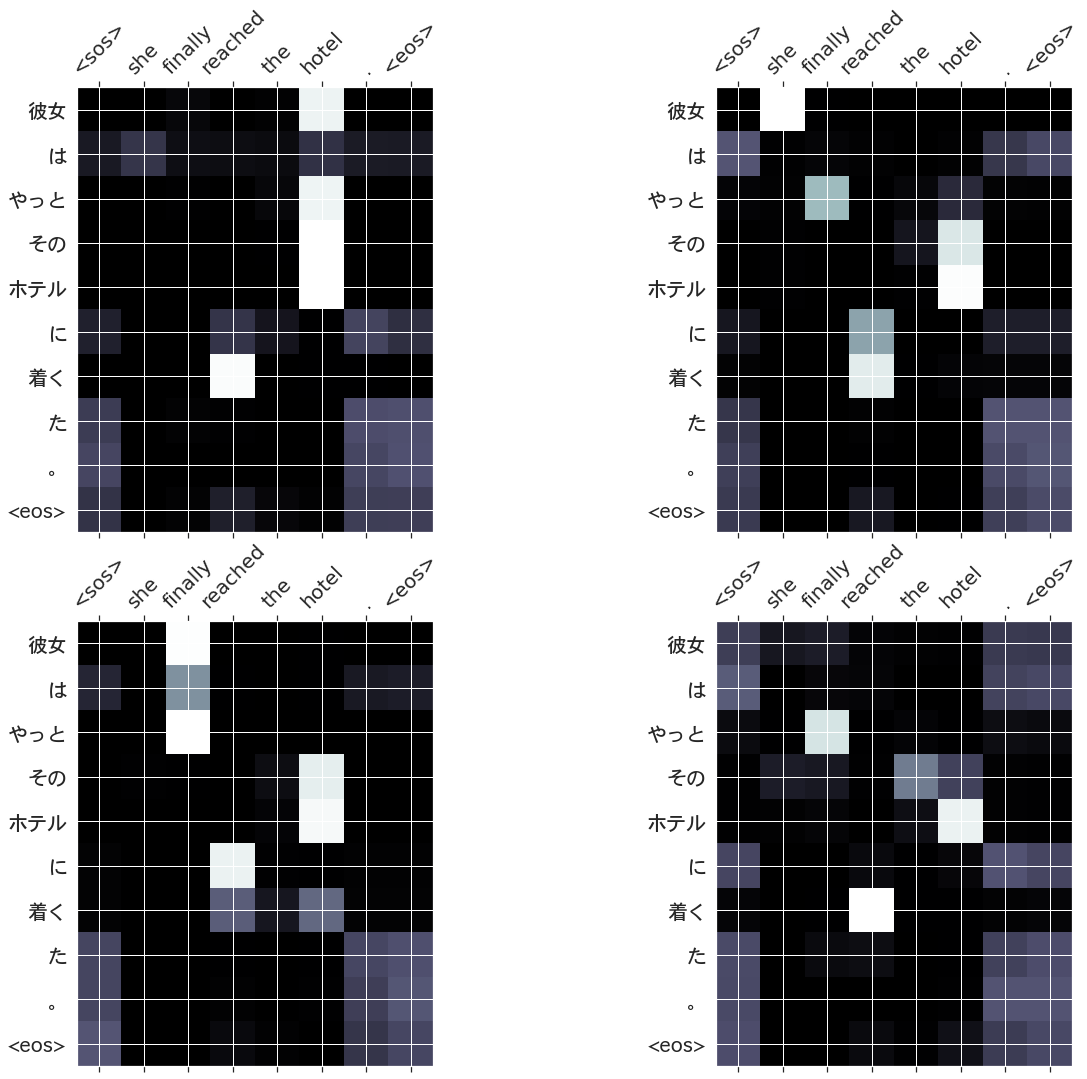

31
src      : the soldier was killed in action .
trg      : その 兵士 は 戦死 する た 。
predicted: その 兵士 は 戦死 する た 。 <eos>
     blue: 100.00%


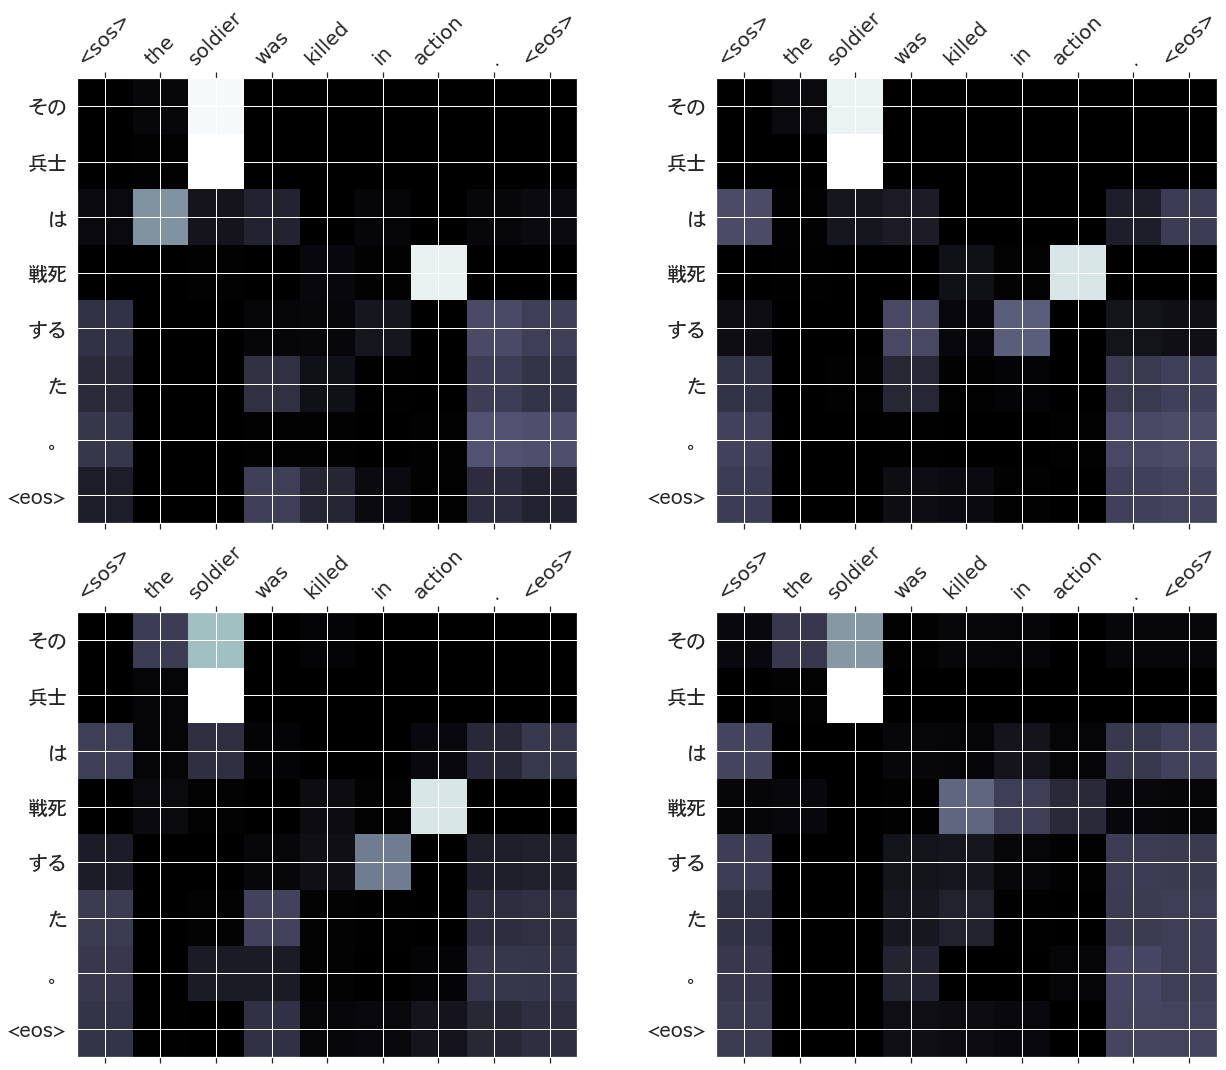

32
src      : she was absent from school owing to sickness .
trg      : 彼女 は 病気 の ため 学校 を 欠席 する た 。
predicted: 彼女 は 病気 の ため 学校 を 欠席 する た 。 <eos>
     blue: 100.00%


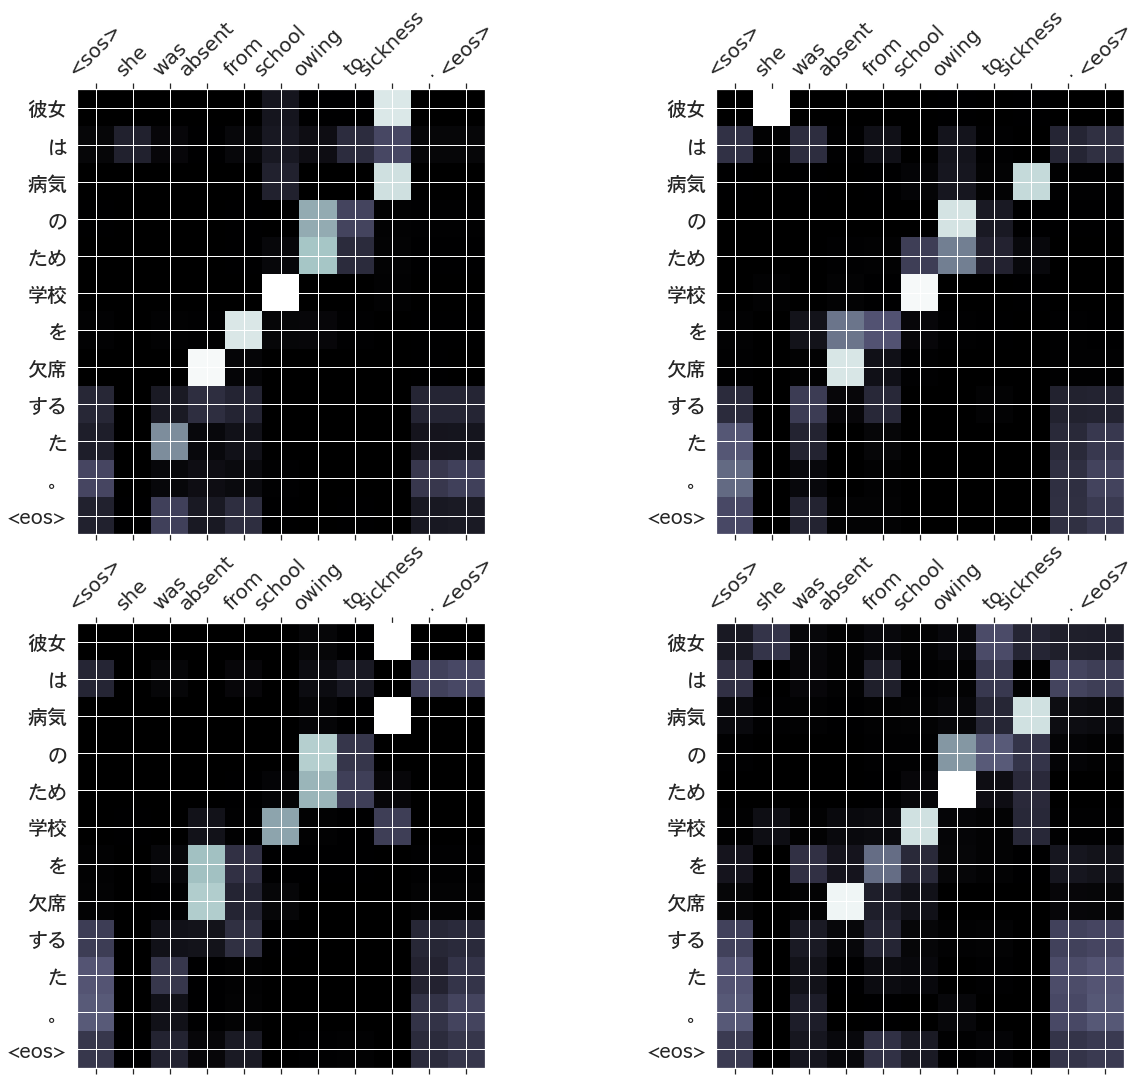

33
src      : fortunately , he was free of debt .
trg      : 幸運 に も 彼 は 借金 が ない た 。
predicted: 幸運 に も 彼 は 借金 が ない た 。 <eos>
     blue: 100.00%


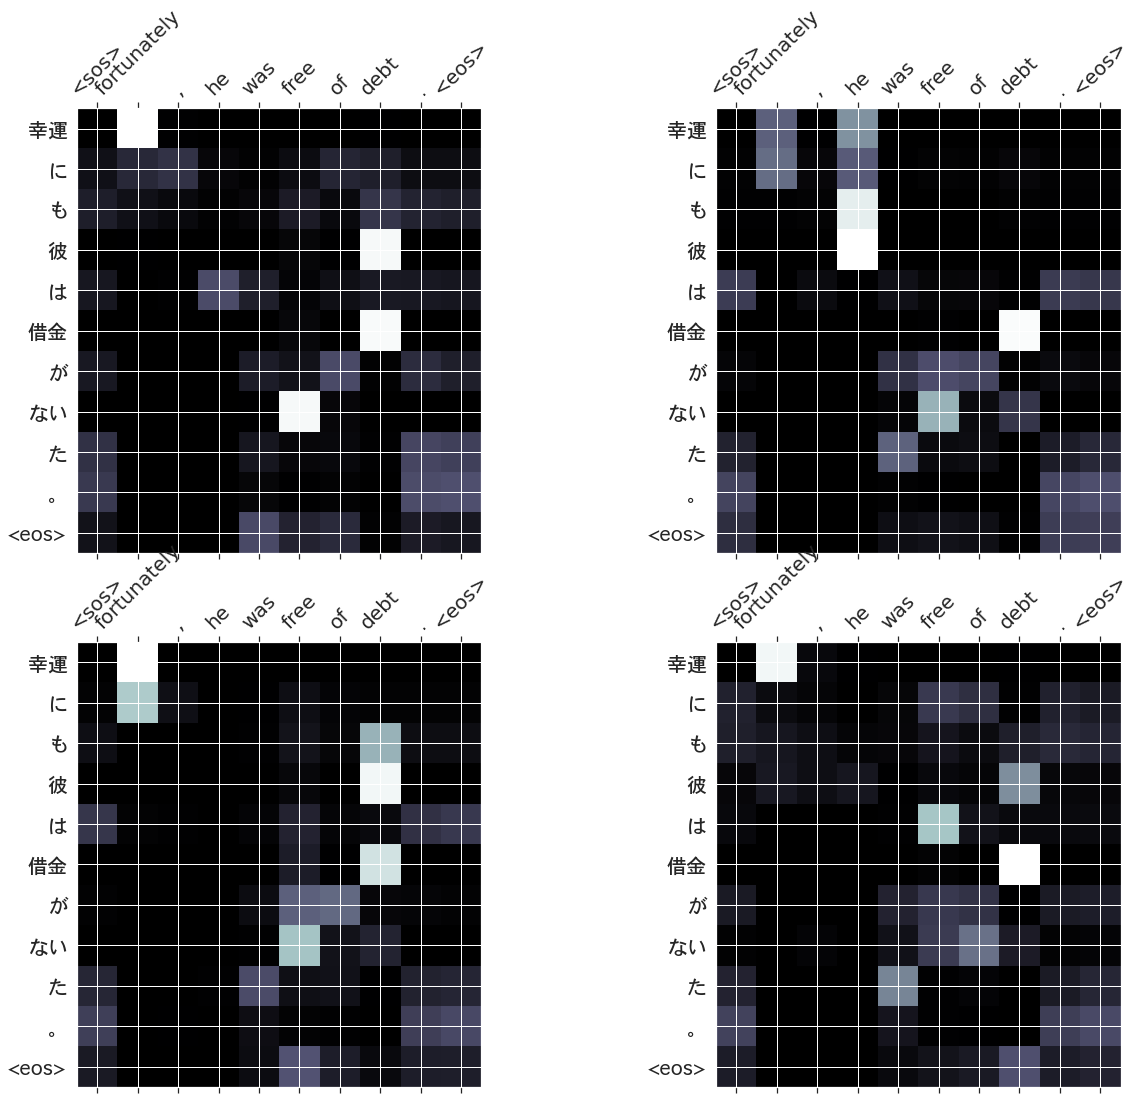

34
src      : the soldier was killed in action .
trg      : その 兵士 は 戦死 する た 。
predicted: その 兵士 は 戦死 する た 。 <eos>
     blue: 100.00%


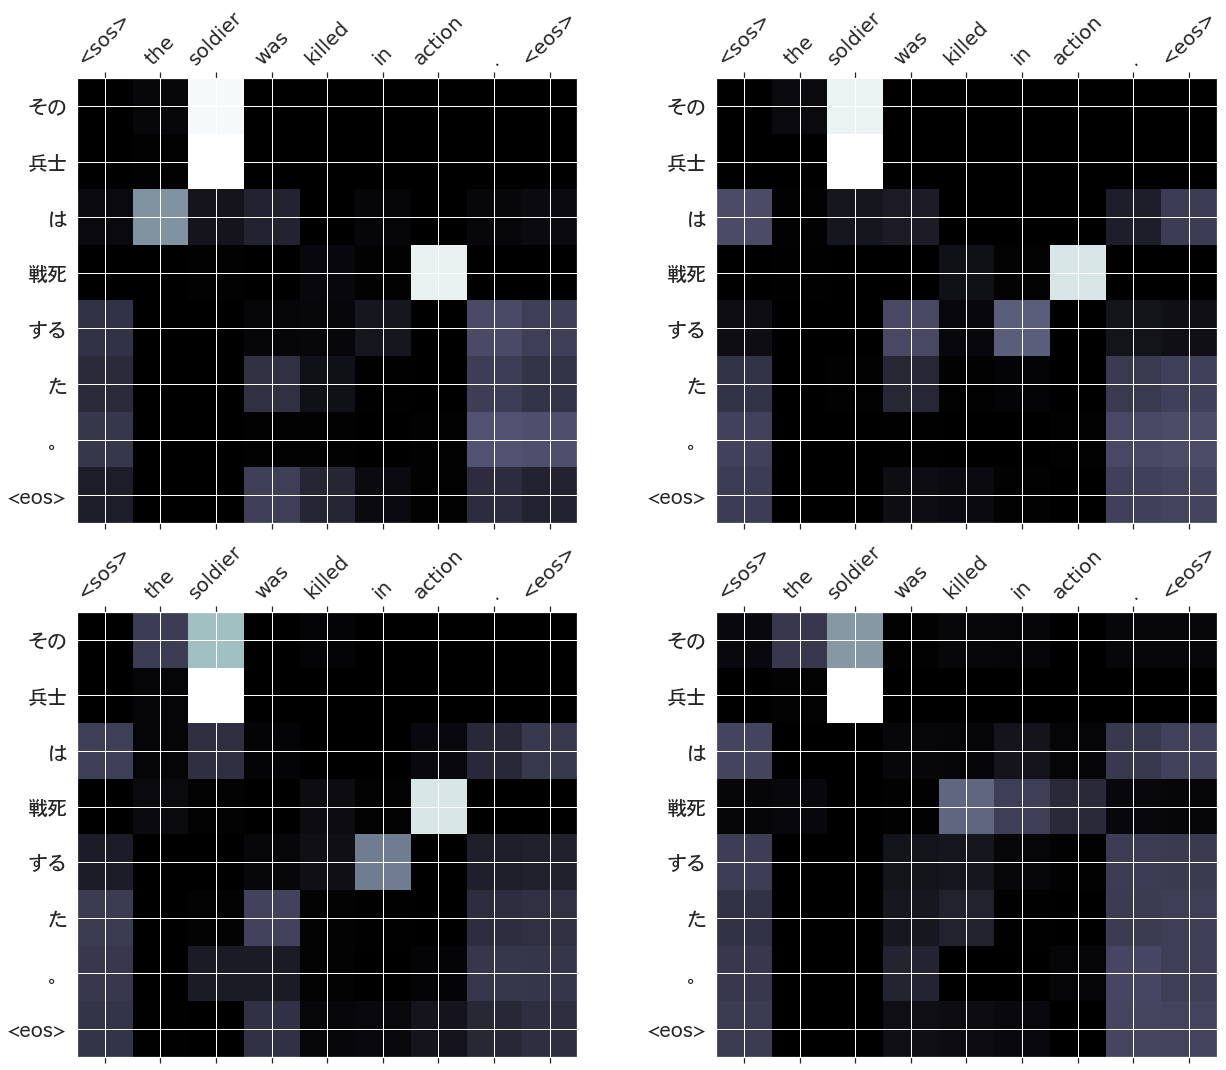

35
src      : the soldier was killed in action .
trg      : その 兵士 は 戦死 する た 。
predicted: その 兵士 は 戦死 する た 。 <eos>
     blue: 100.00%


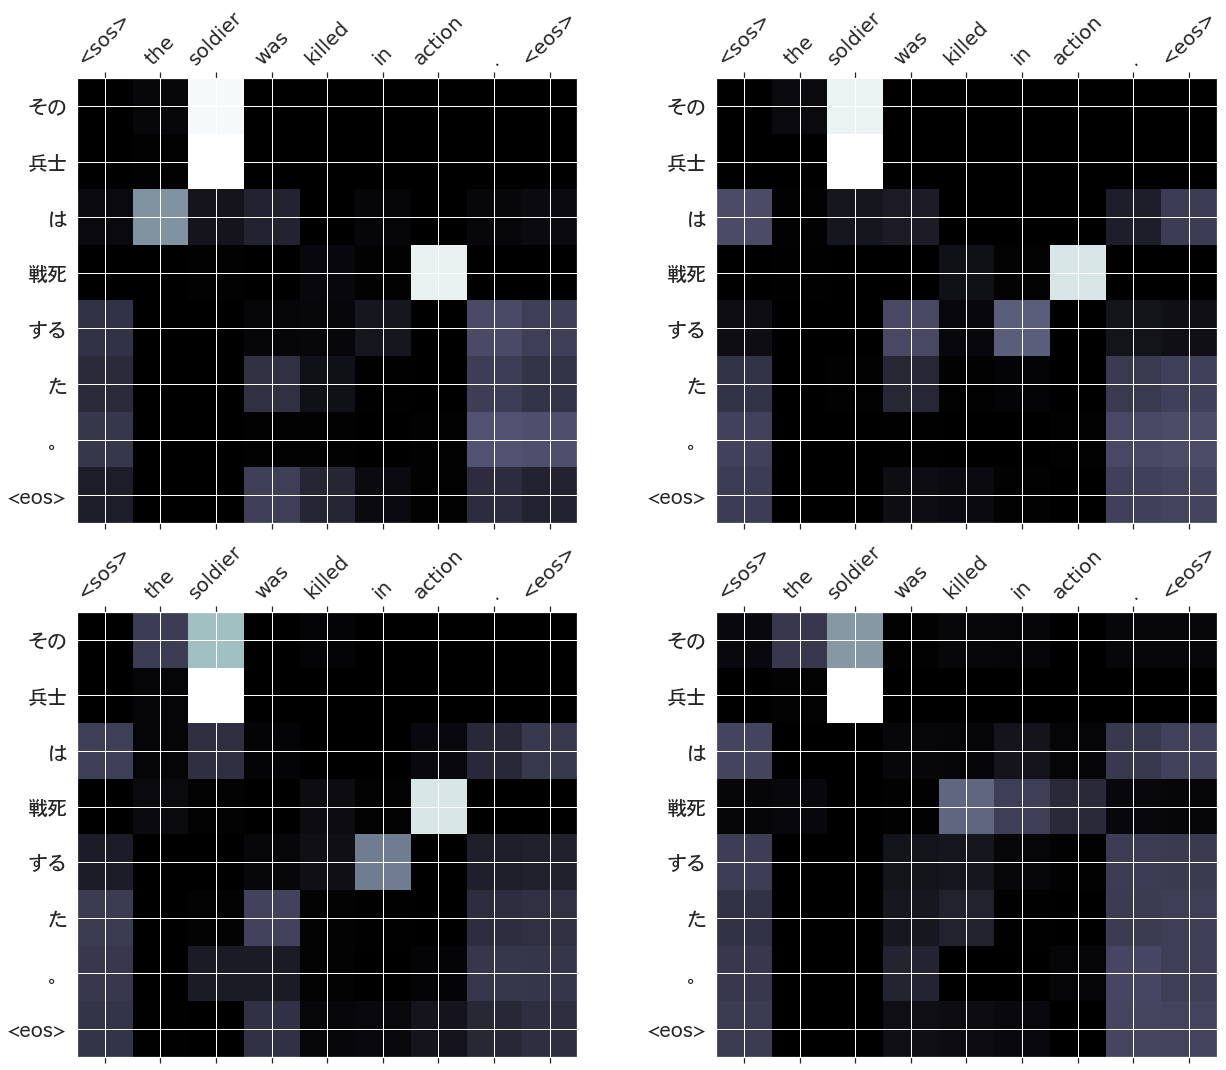

36
src      : his hair style is behind the time .
trg      : 彼 の 髪型 は 時代遅れ だ 。
predicted: 彼 の 髪型 は 時代遅れ だ 。 <eos>
     blue: 100.00%


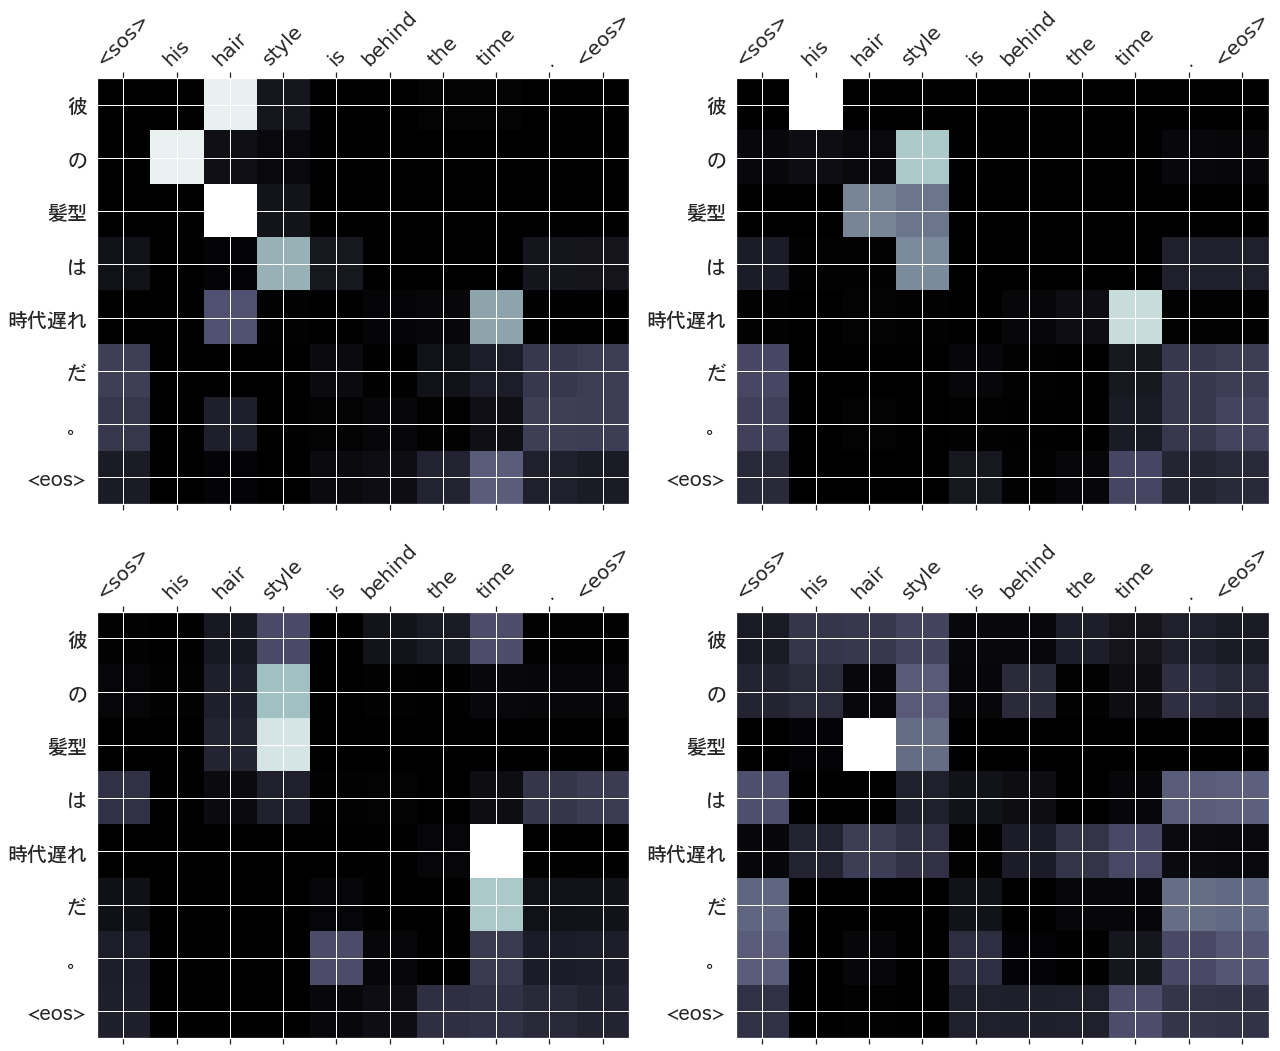

37
src      : tom is taller than i.
trg      : トム は 私 より 背 が 高い 。
predicted: トム は 私 より 背 が 高い 。 <eos>
     blue: 100.00%


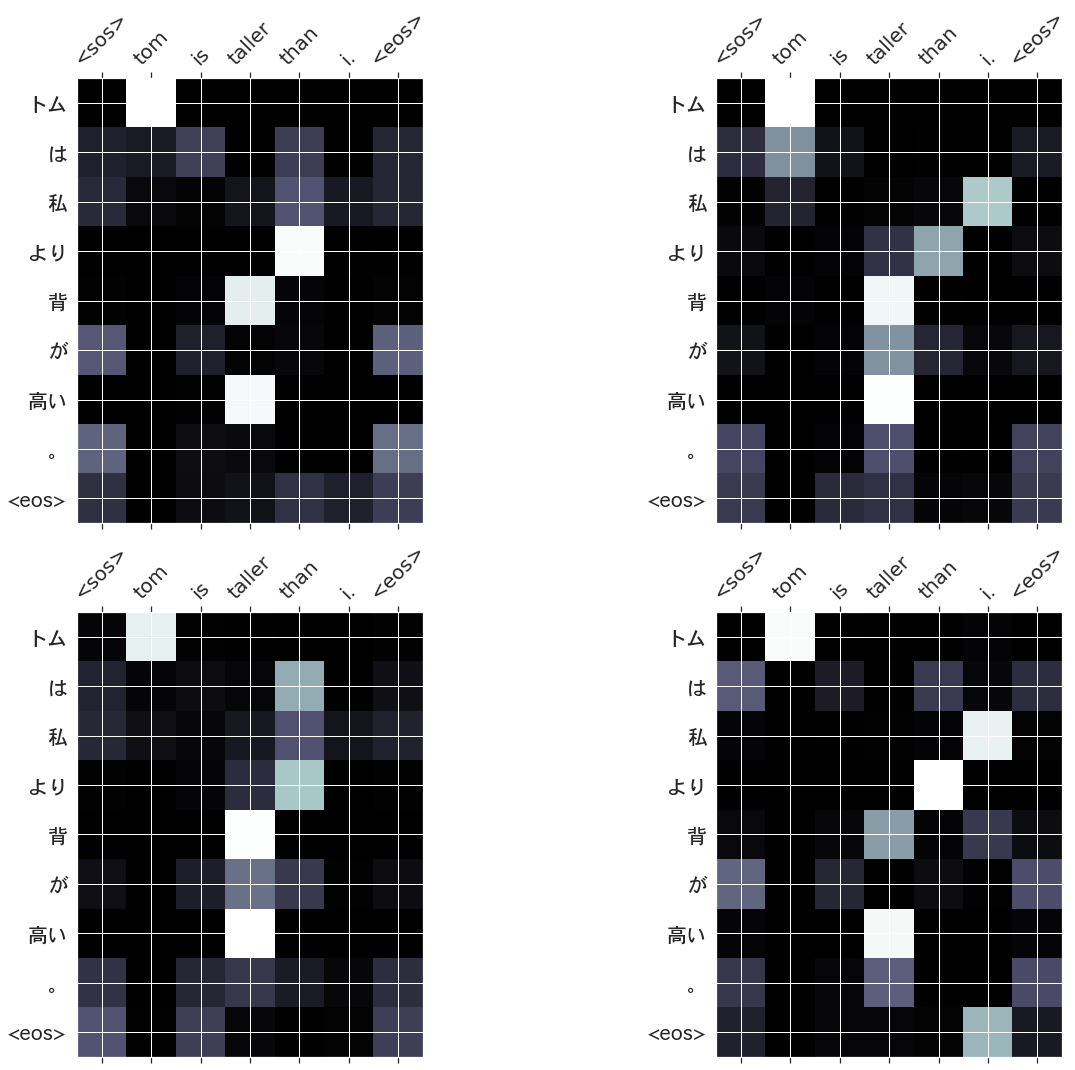

38
src      : it was not long before the rumor died out .
trg      : まもなく その 噂 は 消える た 。
predicted: まもなく その 噂 は 消える た 。 <eos>
     blue: 100.00%


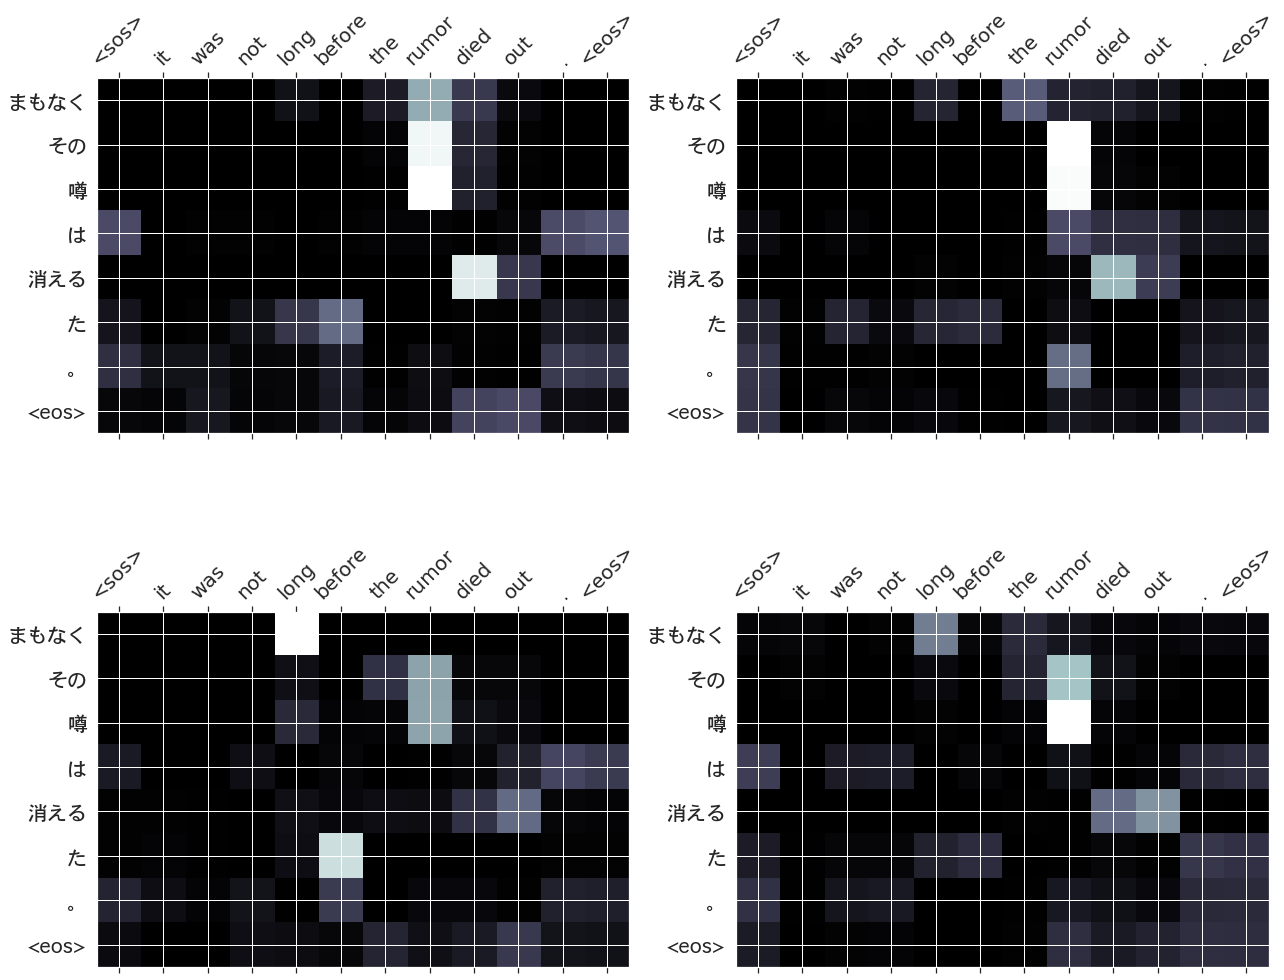

39
src      : kim and i are the same age .
trg      : キム と 私 は 同じ 年齢 だ 。
predicted: キム と 私 は 同じ 年齢 だ 。 <eos>
     blue: 100.00%


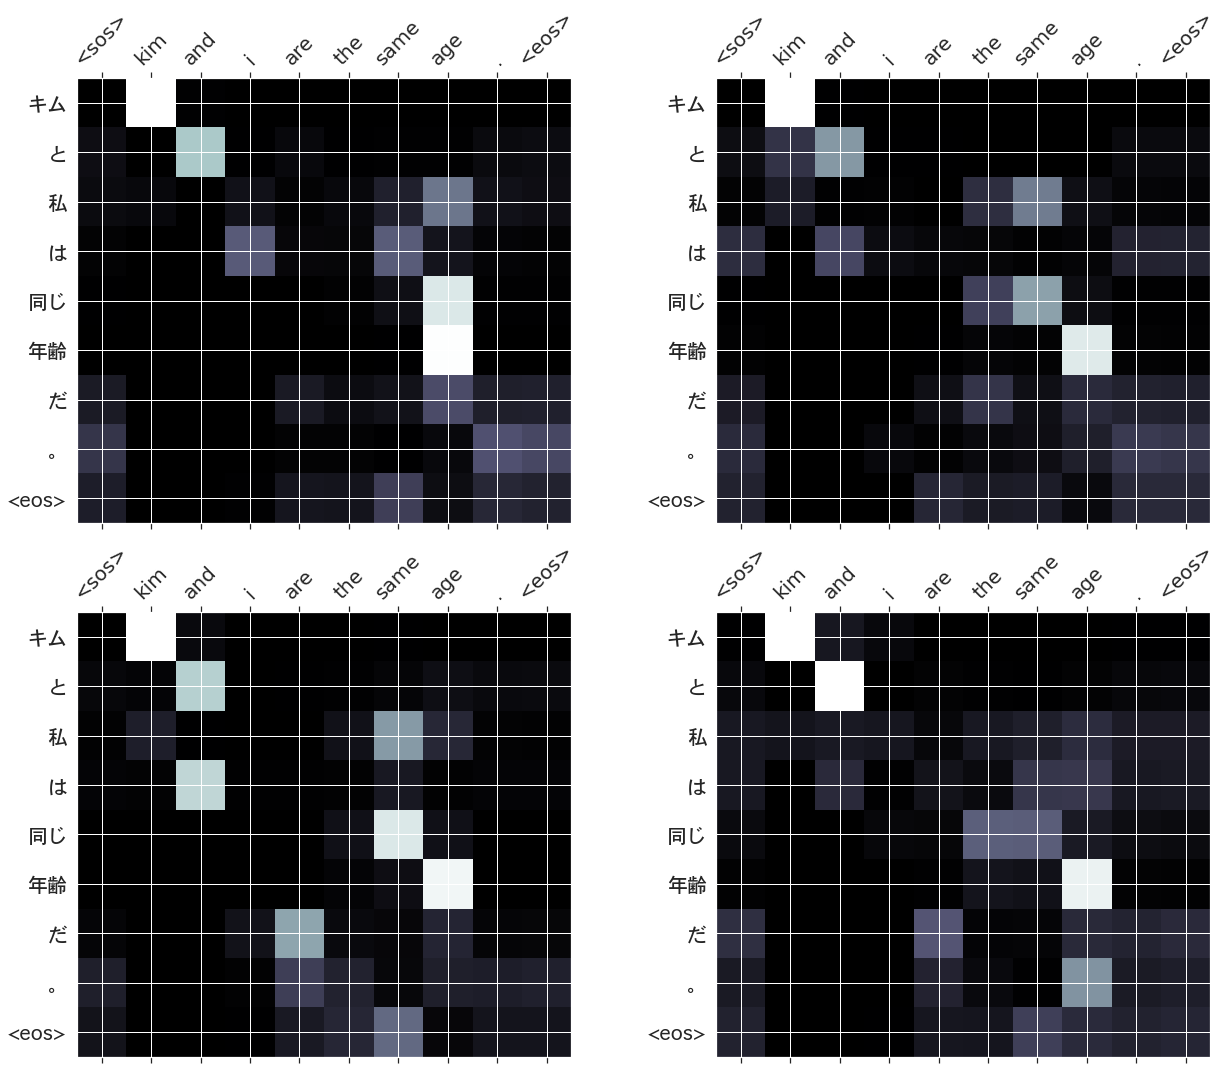

40
src      : i got this bicycle for nothing .
trg      : 私 は この 自転車 を ただ で 手 に 入れる た 。
predicted: 私 は この 自転車 を ただ で 手 に 入れる た 。 <eos>
     blue: 100.00%


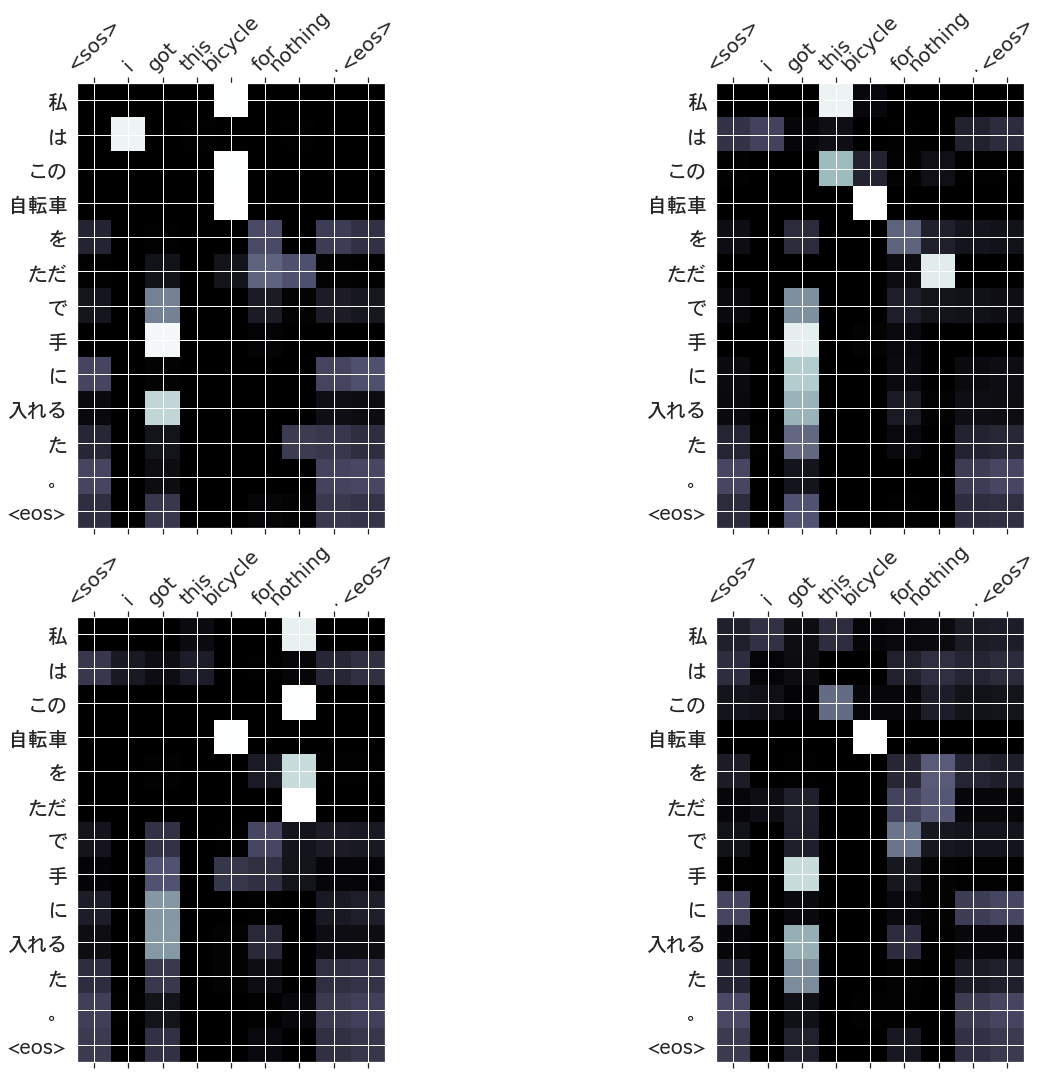

41
src      : kim and i are the same age .
trg      : キム と 私 は 同じ 年齢 だ 。
predicted: キム と 私 は 同じ 年齢 だ 。 <eos>
     blue: 100.00%


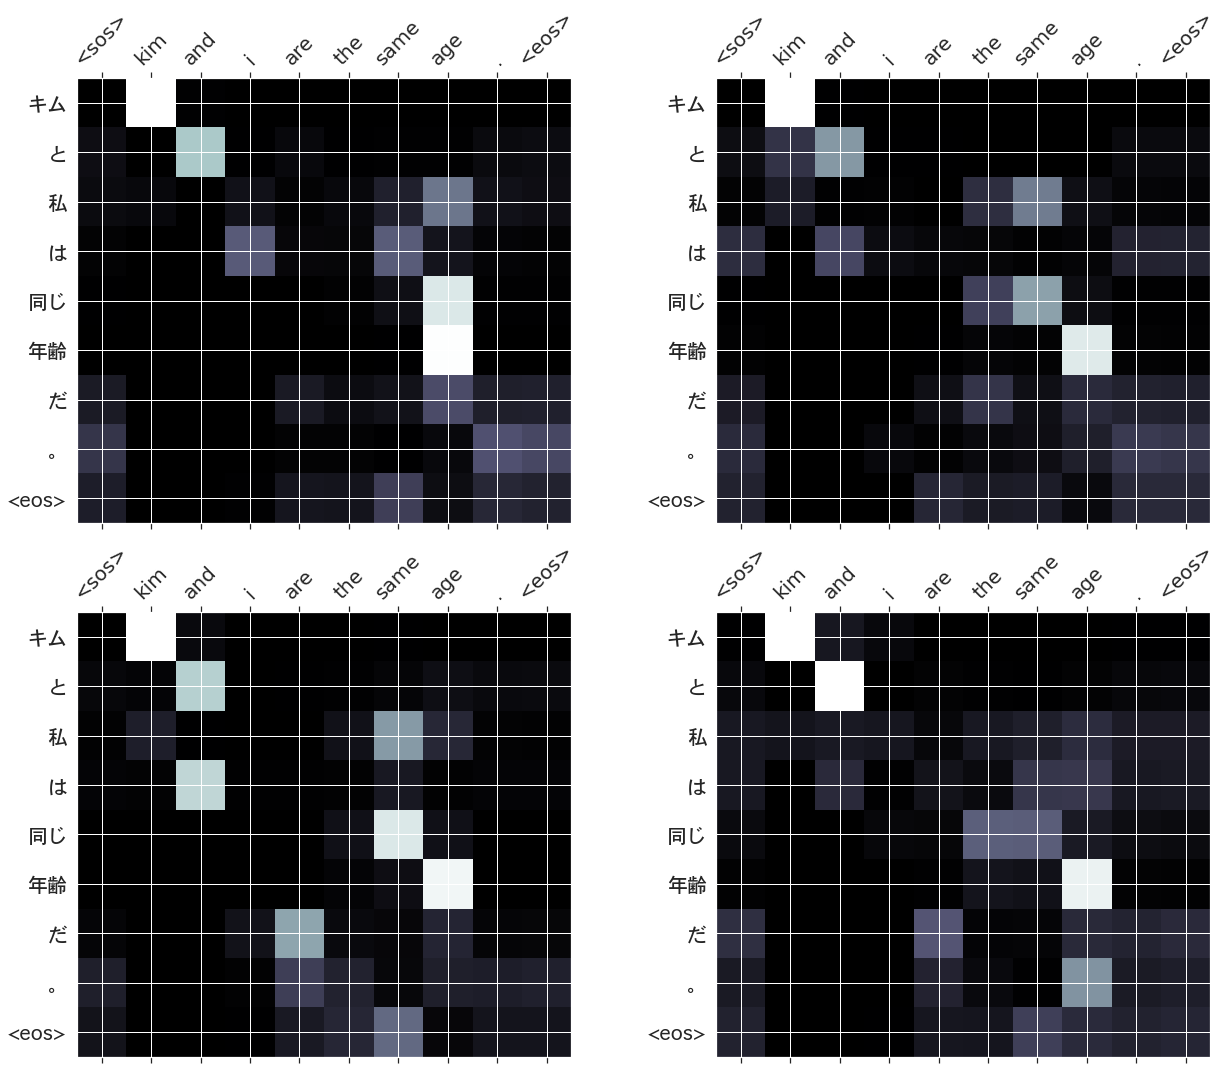

42
src      : i agree to your plan .
trg      : あなた の 計画 に 賛成 です 。
predicted: あなた の 計画 に 賛成 です 。 <eos>
     blue: 100.00%


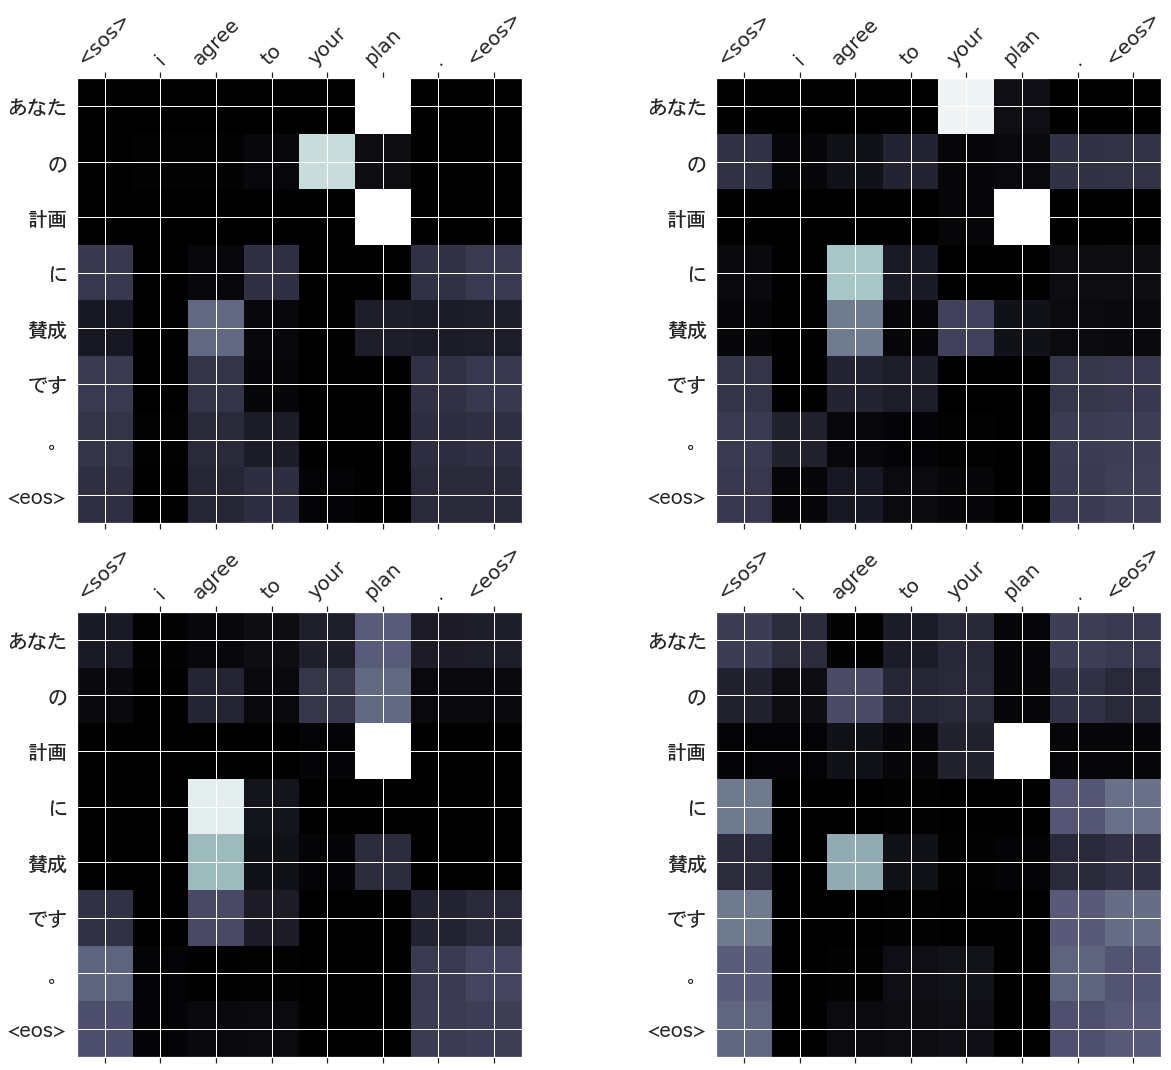

43
src      : he 's always looking at you .
trg      : 彼 は いつも 君 を 見る て いる 。
predicted: 彼 は いつも 君 を 見る て いる 。 <eos>
     blue: 100.00%


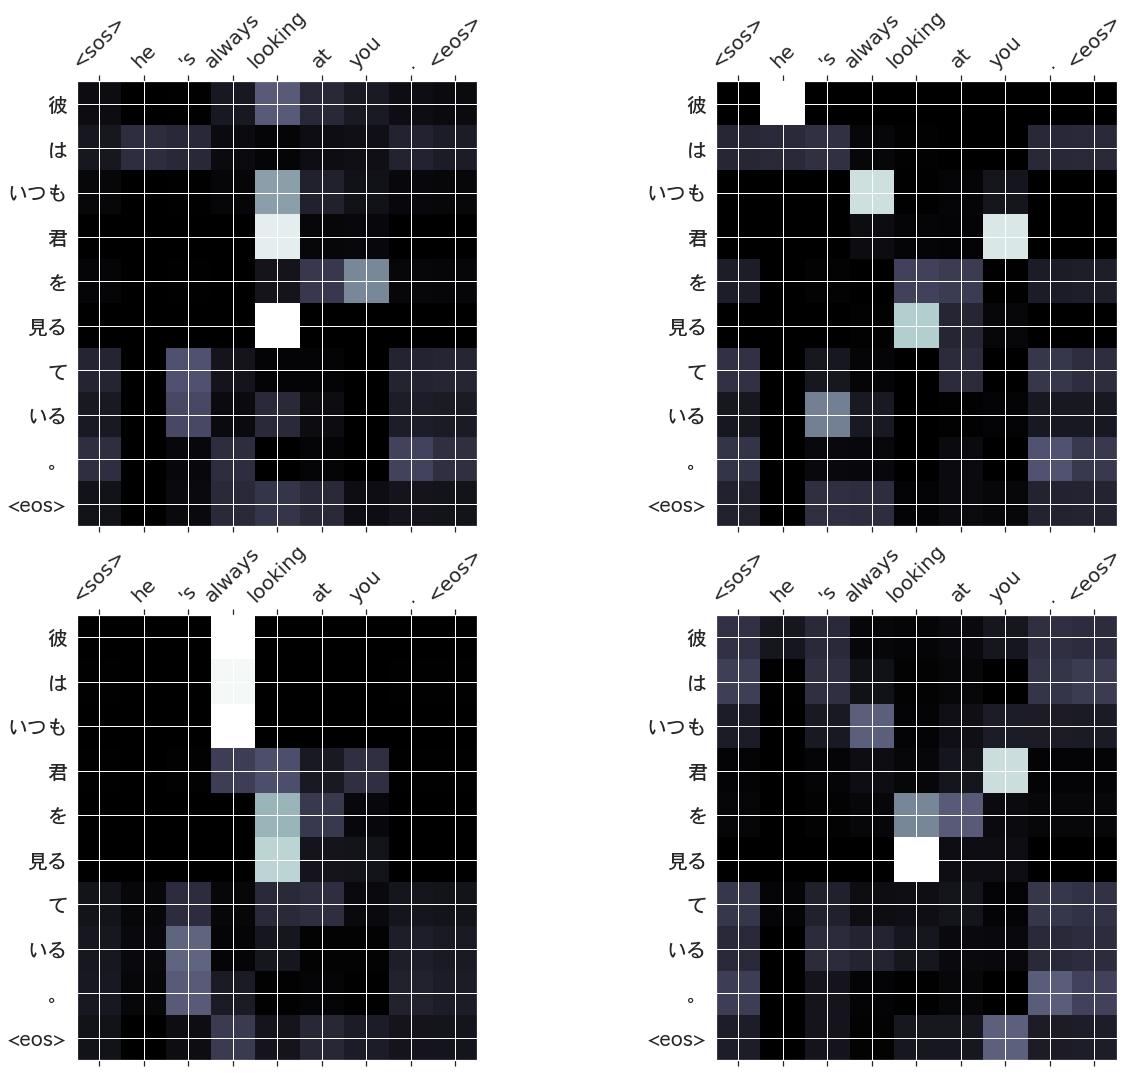

44
src      : our house faces the beach .
trg      : 私 たち の 家 は 海岸 に 面す て いる 。
predicted: 私 たち の 家 は 海岸 に 面す て いる 。 <eos>
     blue: 100.00%


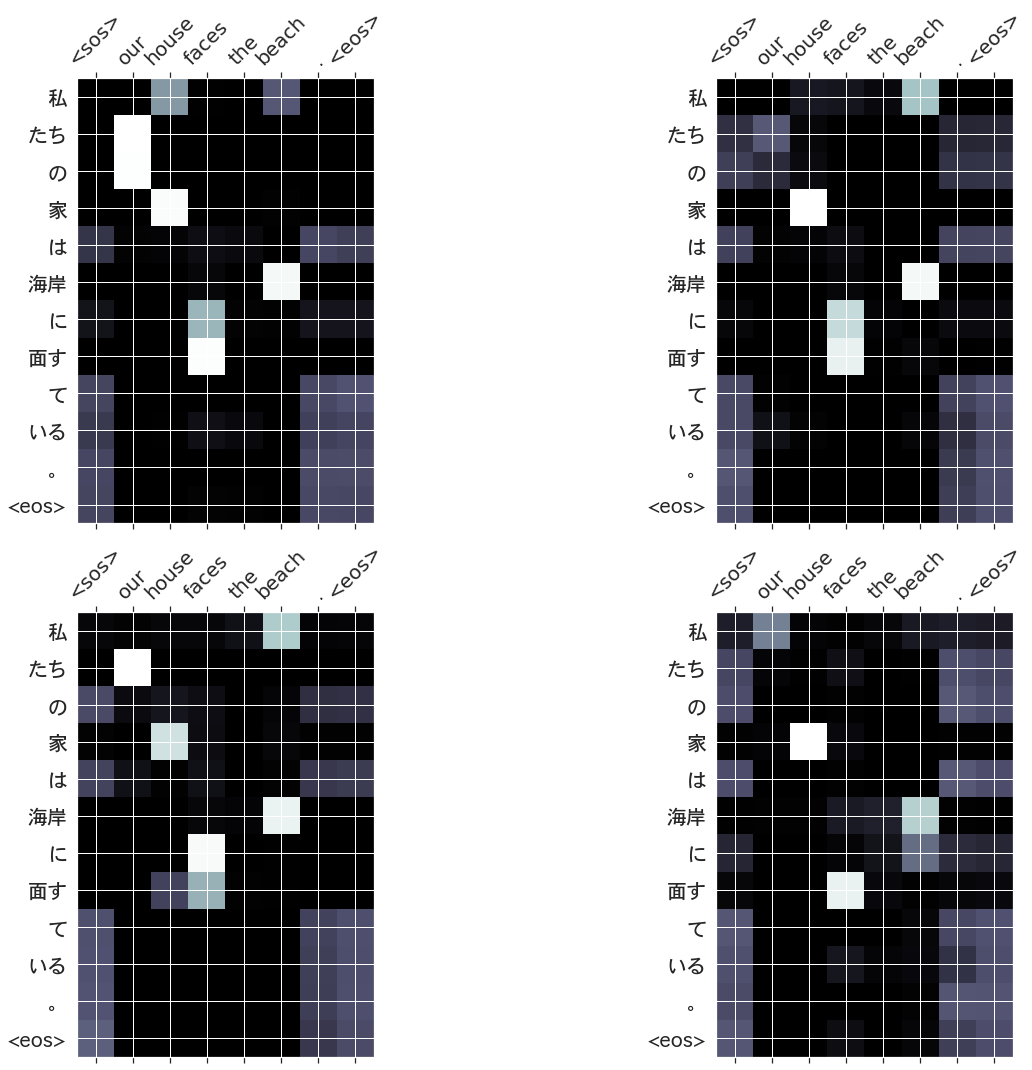

45
src      : do you think this book is worth reading ?
trg      : この 本 は 読む 価値 が ある と 思う ます か 。
predicted: この 本 は 読む 価値 が ある と 思う ます か 。 <eos>
     blue: 100.00%


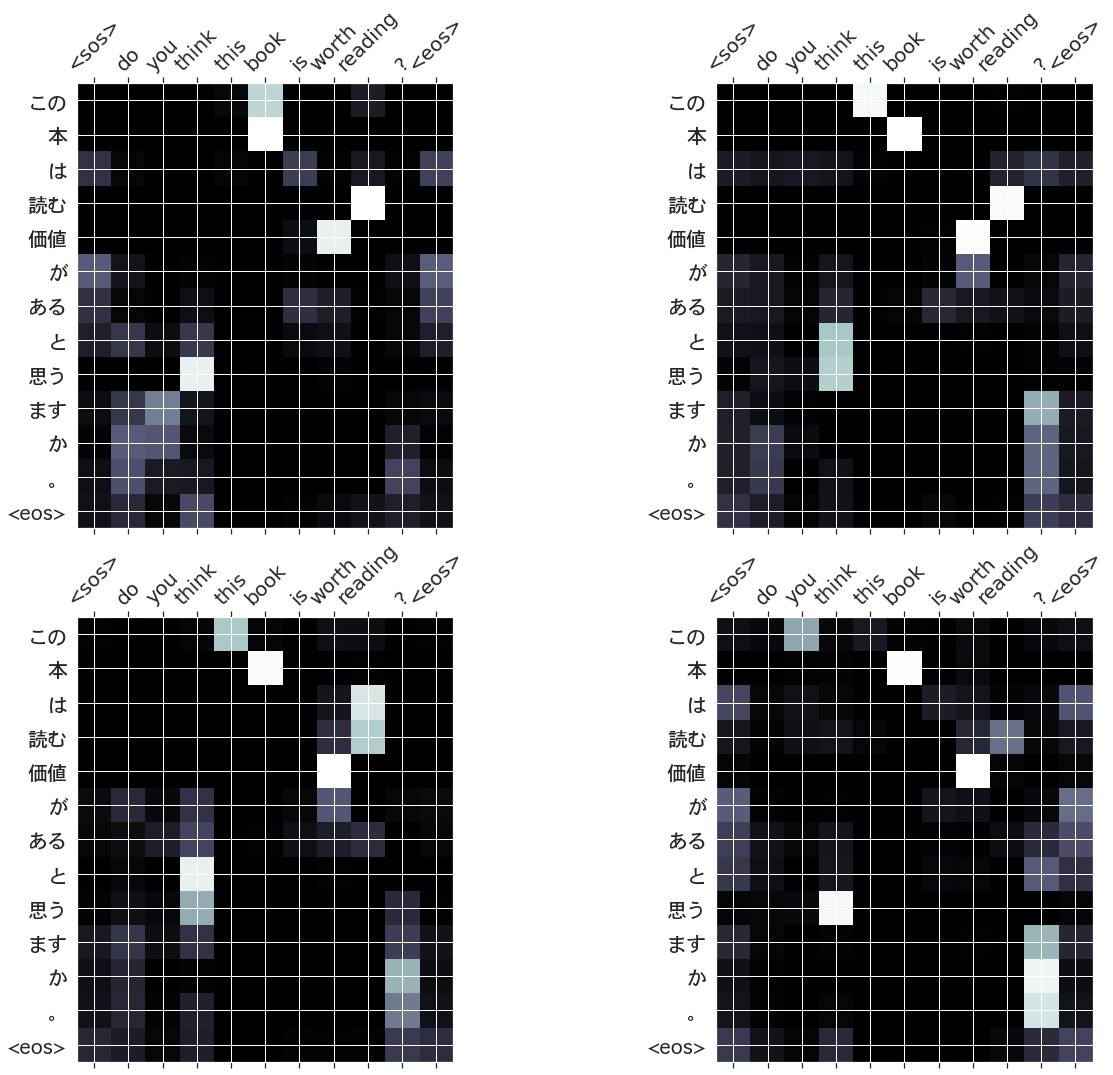

46
src      : i got this bicycle for nothing .
trg      : 私 は この 自転車 を ただ で 手 に 入れる た 。
predicted: 私 は この 自転車 を ただ で 手 に 入れる た 。 <eos>
     blue: 100.00%


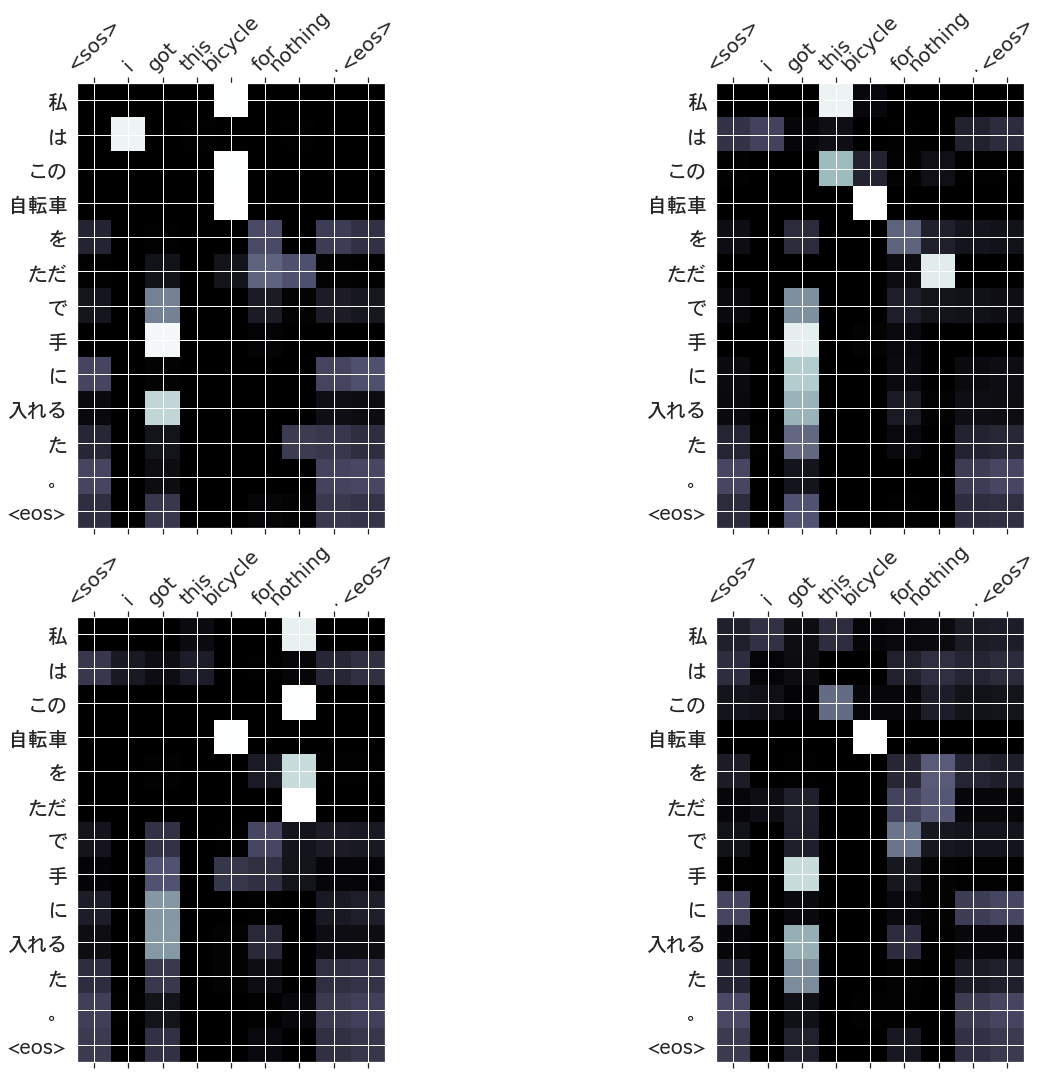

47
src      : george did business in the same manner as his father .
trg      : ジョージ は 父親 と 同じ やり方 で 仕事 を する た 。
predicted: ジョージ は 父親 と 同じ やり方 で 仕事 を する た 。 <eos>
     blue: 100.00%


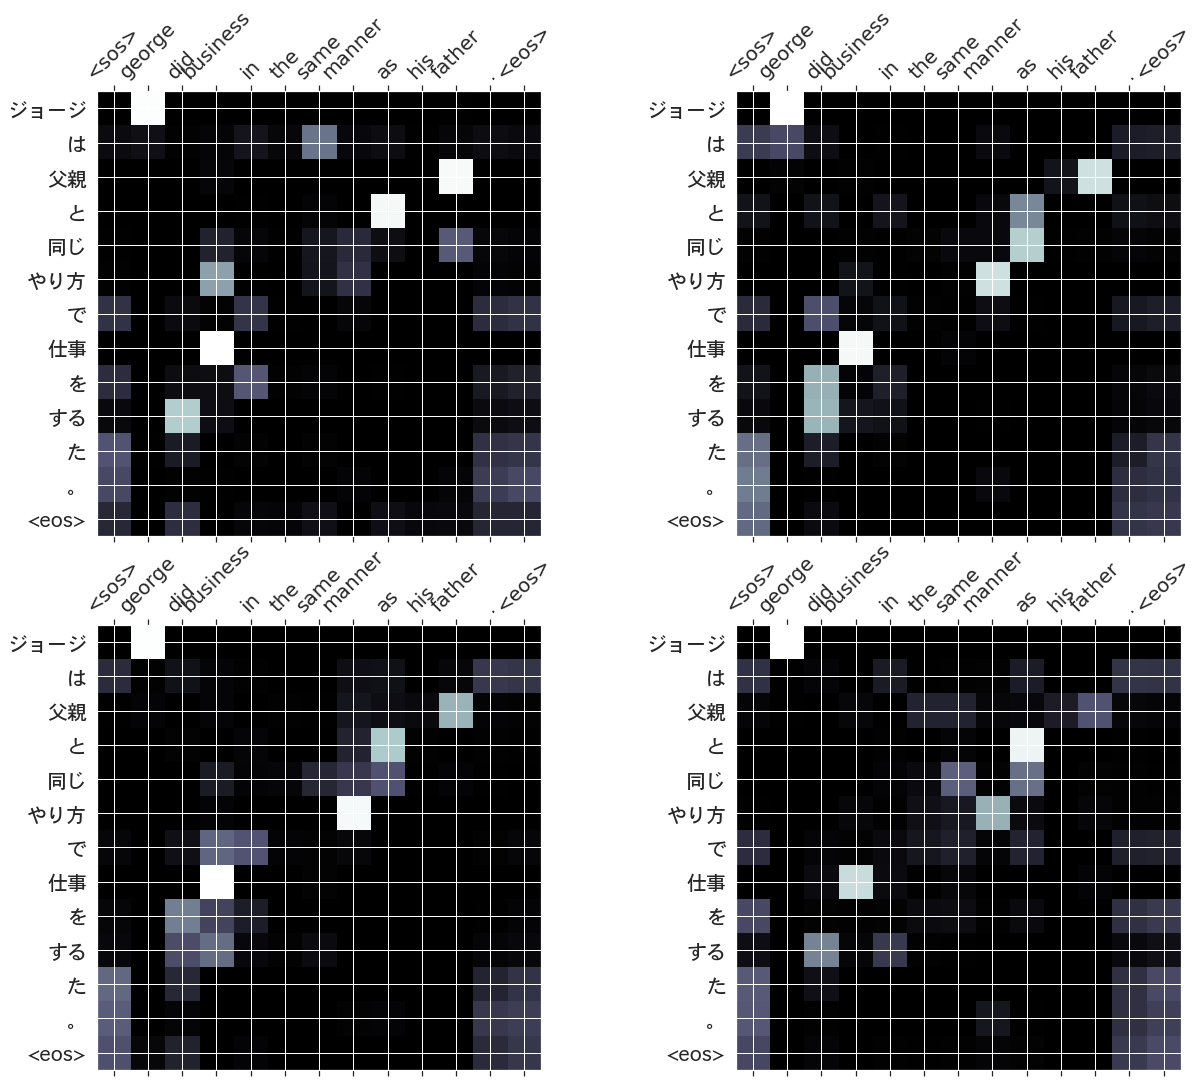

48
src      : i want to be a baseball player .
trg      : 私 は 野球 選手 に なる たい 。
predicted: 私 は 野球 選手 に なる たい 。 <eos>
     blue: 100.00%


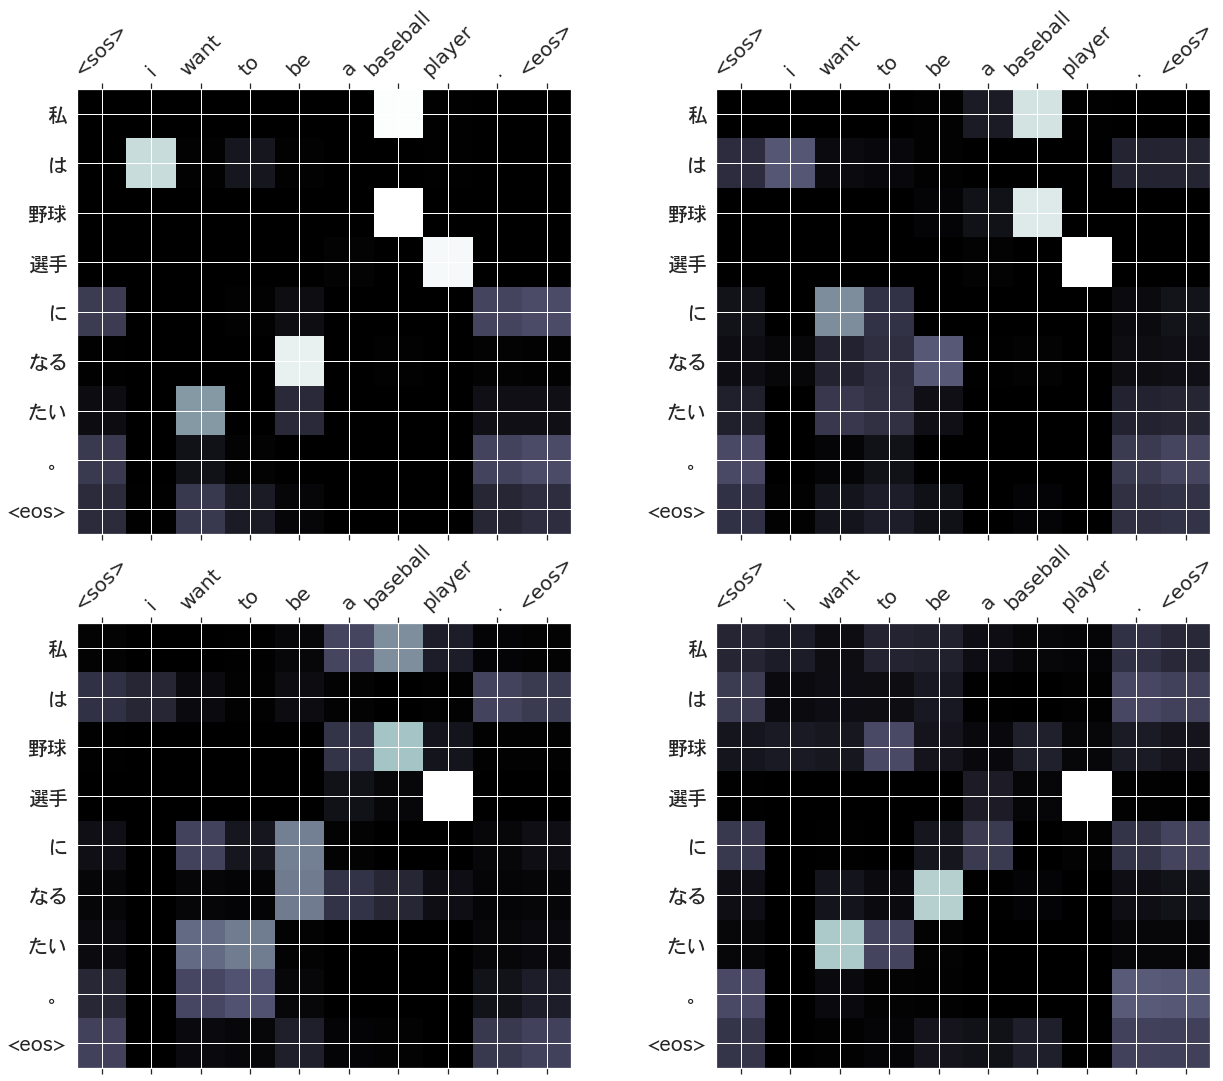

49
src      : i will wait here till he comes .
trg      : 彼 が 来る まで ここ で 待つ ます 。
predicted: 彼 が 来る まで ここ で 待つ ます 。 <eos>
     blue: 100.00%


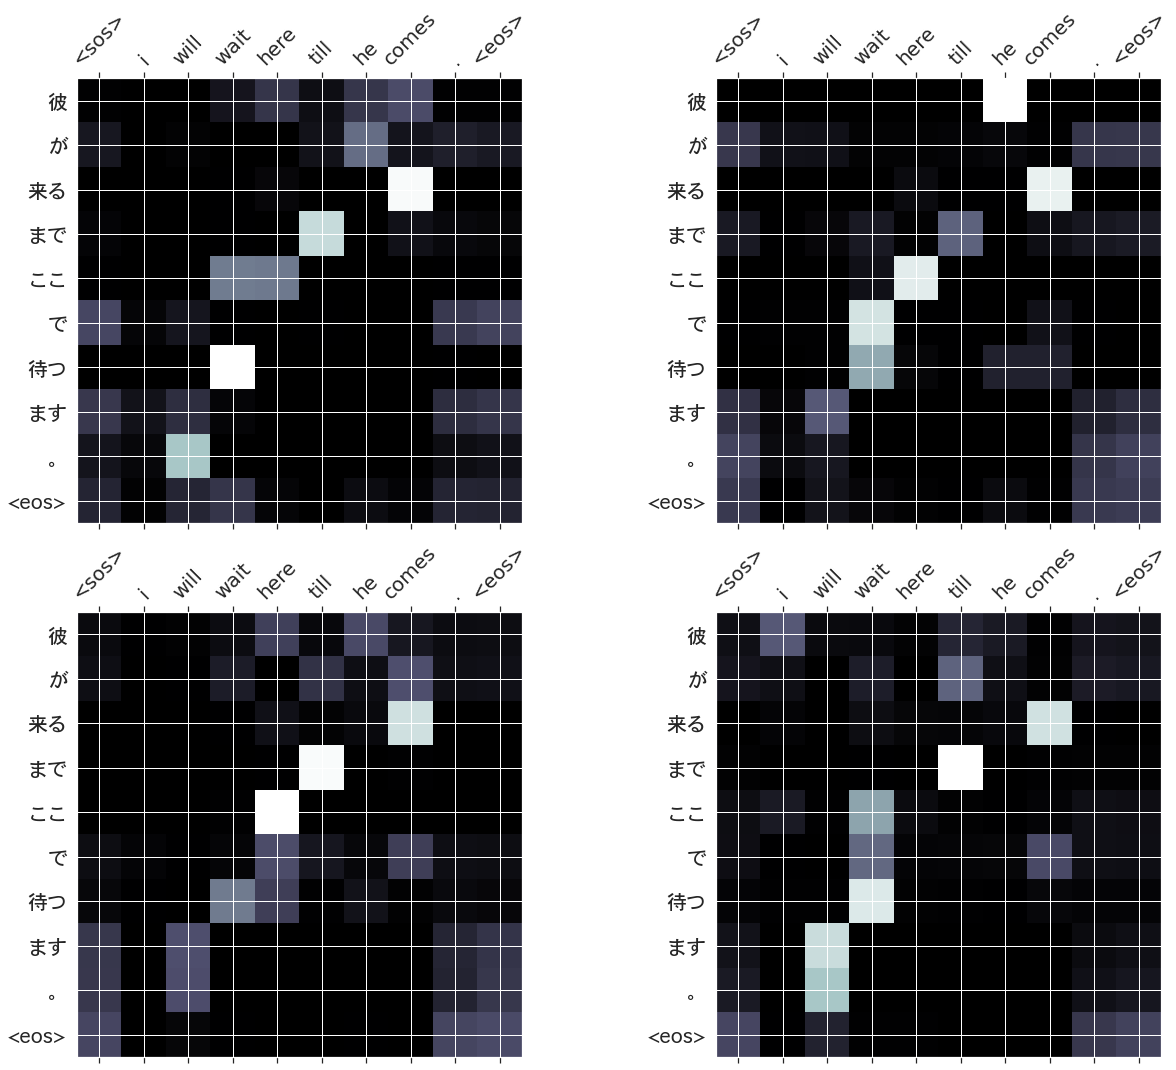

50
src      : tom is taller than i.
trg      : トム は 私 より 背 が 高い 。
predicted: トム は 私 より 背 が 高い 。 <eos>
     blue: 100.00%


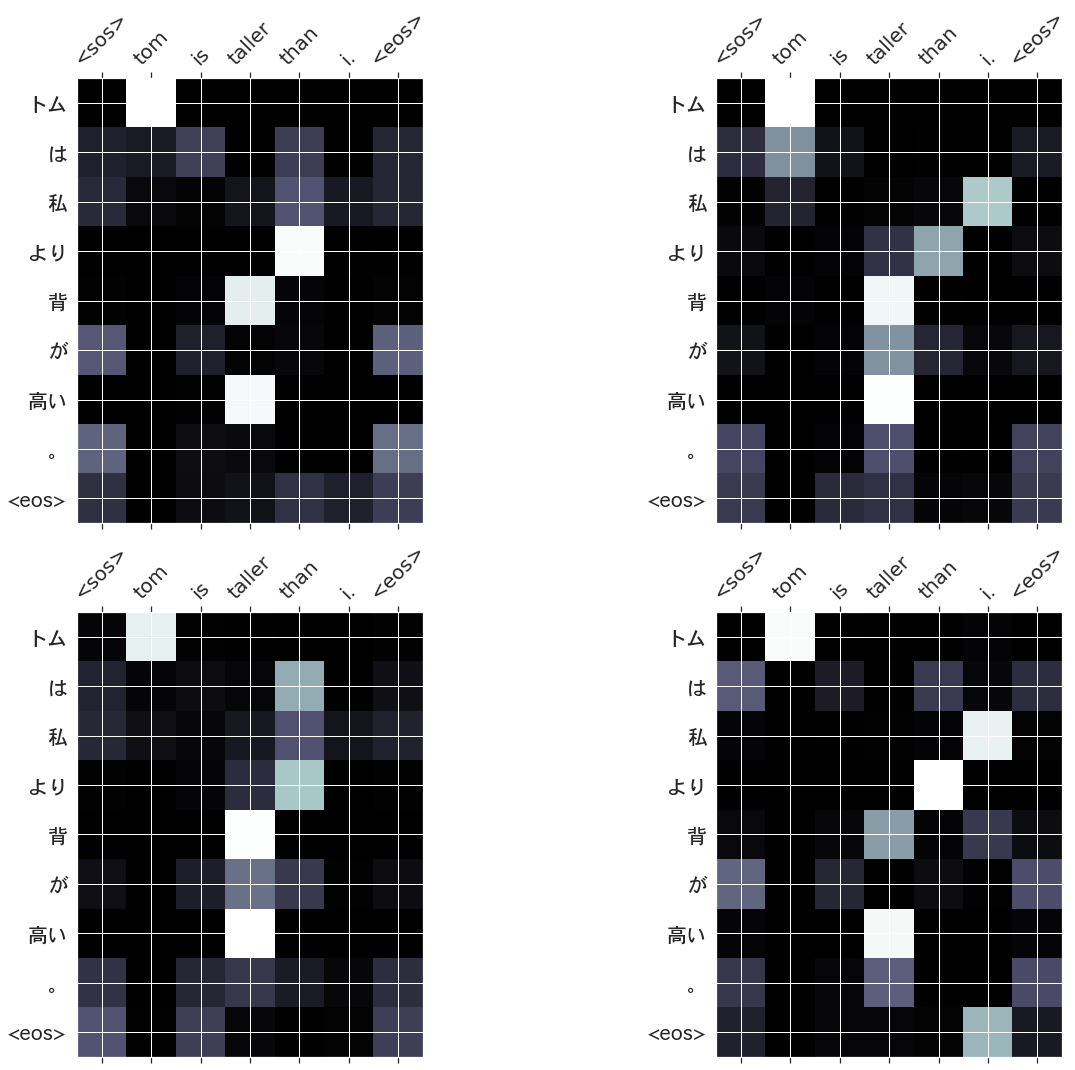

In [47]:
idxs = list(range(len(test_data)))
random.shuffle(idxs)

count = 1

for example_idx in idxs:
    example_idx = random.randint(0, 1219)
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)
    result = [translation[0]]
    
    blue = sentence_blue(trg, translation, 4)
    if blue < .9:
        continue


    for token in translation:
        if token != result[-1]:
            result.append(token)
    if reverse_src:
        src.reverse()

    if reverse_trg:
        trg.reverse()
        translation.reverse()

    print(count)

    print(f'src      : {" ".join(src)}')
    print(f'trg      : {" ".join(trg)}')
    print(f'predicted: {" ".join(translation)}')
    print(f'     blue: {100 * blue:.2f}%')
    display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

    count += 1
    if count > 50:
        break